In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i)[0:100])
    break
    
train_df = pd.concat(frames, sort=False)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
    break
    
test_df = pd.concat(frames, sort=False)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i)[0:100])
    break
    
val_df = pd.concat(frames, sort=False)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

min_price = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
max_price = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())
#min_long = min(train_df['longitude'].min(), test_df['longitude'].min(), val_df['longitude'].min())
#max_long = max(train_df['longitude'].max(), test_df['longitude'].max(), val_df['longitude'].max())
min_lat = min(train_df['latitude'].min(), test_df['latitude'].min(), val_df['latitude'].min())
max_lat = max(train_df['latitude'].max(), test_df['latitude'].max(), val_df['latitude'].max())

train_df['price'] = (train_df['price'] - min_price)/(max_price - min_price)
#train_df['longitude'] = (train_df['longitude'] - min_long)/(max_long - min_long)
train_df['latitude'] = (train_df['latitude'] - min_lat)/(max_lat - min_lat)
train_df = train_df.reset_index(drop=True)

test_df['price'] = (test_df['price'] - min_price)/(max_price - min_price)
#test_df['longitude'] = (test_df['longitude'] - min_long)/(max_long - min_long)
test_df['latitude'] = (test_df['latitude'] - min_lat)/(max_lat - min_lat)
test_df = test_df.reset_index(drop=True)

val_df['price'] = (val_df['price'] - min_price)/(max_price - min_price)
#val_df['longitude'] = (val_df['longitude'] - min_long)/(max_long - min_long)
val_df['latitude'] = (val_df['latitude'] - min_lat)/(max_lat - min_lat)
val_df = val_df.reset_index(drop=True)
#train_df = train_df.drop(columns=["minimum_nights", "maximum_nights"])
#test_df = test_df.drop(columns=["minimum_nights", "maximum_nights"])
#val_df = val_df.drop(columns=["minimum_nights", "maximum_nights"])

print(min_price, max_price)
bounds = [min_price, max_price]

36 349


In [3]:
train_df.head(5)

latitude  accommodates  bathrooms  bedrooms  beds     price  amenities_TV  \
0  0.295877             2        1.0       0.0   2.0  0.047923             1   
1  0.308621             2        1.0       1.0   2.0  0.348243             0   
2  0.441983             3        1.0       1.0   2.0  0.303514             1   
3  0.730529             2        1.0       1.0   1.0  0.204473             1   
4  0.268638             4        1.5       1.0   1.0  0.316294             1   

   amenities_Air conditioning  amenities_Kitchen  amenities_Indoor fireplace  \
0                           1                  1                           0   
1                           0                  1                           0   
2                           1                  1                           1   
3                           1                  1                           0   
4                           1                  1                           0   

   ...  property_type_House  property_type_Loft  \
0  ...                    0                   1   
1  ...                    0                   0   
2  ...                    0                   0   
3  ...                    1                   0   
4  ...                    0                   0   

   property_type_Serviced apartment  room_type_Entire home/apt  \
0                                 0                          1   
1                                 0                          0   
2                                 0                          1   
3                                 0                          1   
4                                 0                          1   

   room_type_Private room  room_type_Shared room  instant_bookable_f  \
0                       0                      0                   1   
1                       1                      0                   1   
2                       0                      0                   1   
3                       0                      0                   0   
4                       0                      0                   1   

   instant_bookable_t  cancellation_policy_flexible  \
0                   0                             1   
1                   0                             0   
2                   0                             1   
3                   1                             1   
4                   0                             0   

   cancellation_policy_strict_14_with_grace_period  
0                                                0  
1                                                1  
2                                                0  
3                                                0  
4                                                0  

[5 rows x 67 columns]

In [4]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [5]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=0)

In [6]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(66, 528)
        self.layer2 = nn.Linear(528, 528)
        self.layer3 = nn.Linear(528, 250)
        self.layer4 = nn.Linear(250, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

In [12]:
def train(net, train_loader, val_loader, bounds, folder):
    criterion = nn.MSELoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum = 0.9)
    optimizer = optim.Adam(net.parameters(),lr = 0.01)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(200):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            #print(label, output)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30], bounds)
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    

def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    #plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        #plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    return None

In [8]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

Starting Training...
[EPOCH 1] loss: 0.064291  time: 2.291
[EPOCH 2] loss: 124.596619  time: 0.642
[EPOCH 3] loss: 0.171556  time: 0.655
[EPOCH 4] loss: 0.055672  time: 0.613
[EPOCH 5] loss: 0.055699  time: 0.663
[EPOCH 6] loss: 0.052553  time: 0.812
[EPOCH 7] loss: 0.049138  time: 0.609
[EPOCH 8] loss: 0.043045  time: 0.431
[EPOCH 9] loss: 0.033115  time: 0.334
[EPOCH 10] loss: 0.031641  time: 0.899


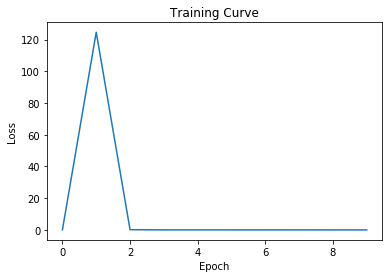

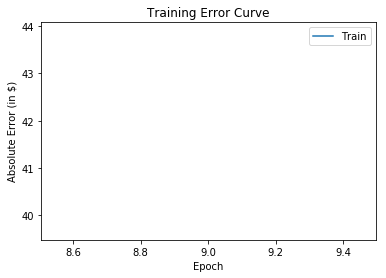

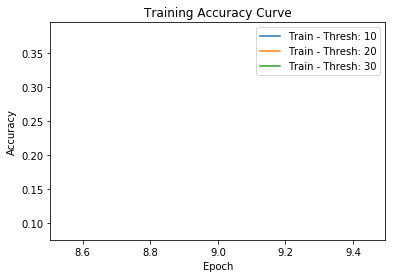

[EPOCH 11] loss: 0.026394  time: 0.203
[EPOCH 12] loss: 0.028547  time: 0.279
[EPOCH 13] loss: 0.028587  time: 0.265
[EPOCH 14] loss: 0.025651  time: 0.247
[EPOCH 15] loss: 0.022737  time: 0.238
[EPOCH 16] loss: 0.020544  time: 0.272
[EPOCH 17] loss: 0.018751  time: 0.279
[EPOCH 18] loss: 0.016712  time: 0.268
[EPOCH 19] loss: 0.014695  time: 0.255
[EPOCH 20] loss: 0.013766  time: 0.770


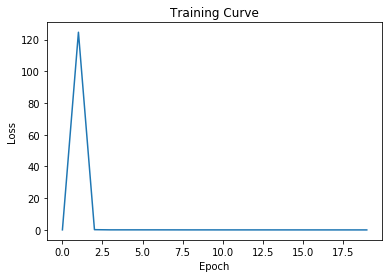

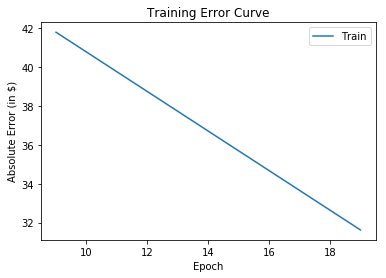

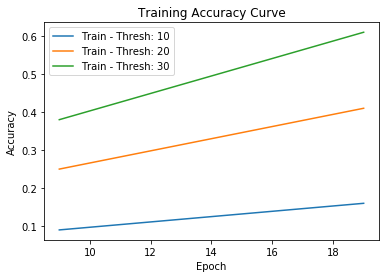

[EPOCH 21] loss: 0.016445  time: 1.000
[EPOCH 22] loss: 0.019530  time: 0.781
[EPOCH 23] loss: 0.011718  time: 0.783
[EPOCH 24] loss: 0.014961  time: 0.610
[EPOCH 25] loss: 0.011337  time: 0.628
[EPOCH 26] loss: 0.011941  time: 0.419
[EPOCH 27] loss: 0.012823  time: 0.296
[EPOCH 28] loss: 0.010564  time: 0.246
[EPOCH 29] loss: 0.010368  time: 0.471
[EPOCH 30] loss: 0.010810  time: 1.075


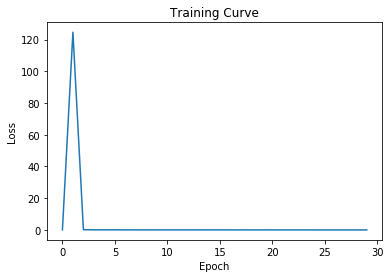

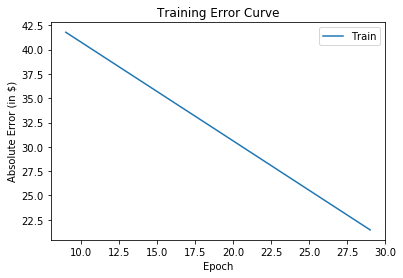

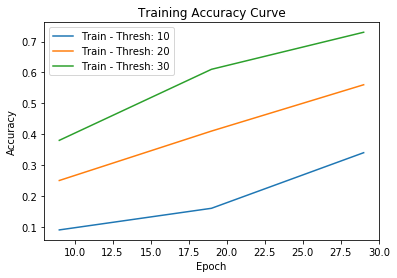

[EPOCH 31] loss: 0.008478  time: 0.498
[EPOCH 32] loss: 0.008705  time: 0.404
[EPOCH 33] loss: 0.008624  time: 0.473
[EPOCH 34] loss: 0.007320  time: 0.349
[EPOCH 35] loss: 0.008241  time: 0.386
[EPOCH 36] loss: 0.007232  time: 0.399
[EPOCH 37] loss: 0.006868  time: 0.355
[EPOCH 38] loss: 0.006837  time: 0.331
[EPOCH 39] loss: 0.005776  time: 0.372
[EPOCH 40] loss: 0.005954  time: 0.824


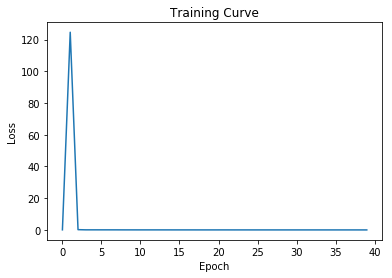

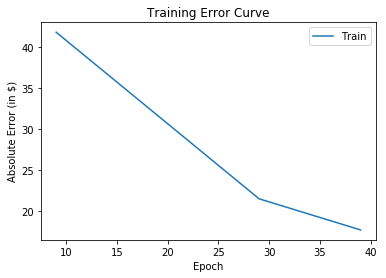

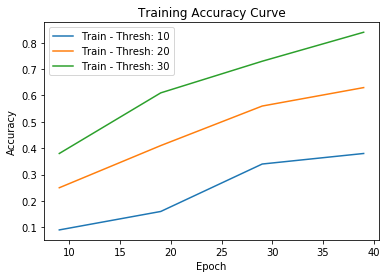

[EPOCH 41] loss: 0.005537  time: 0.186
[EPOCH 42] loss: 0.005139  time: 0.259
[EPOCH 43] loss: 0.005307  time: 0.236
[EPOCH 44] loss: 0.004794  time: 0.259
[EPOCH 45] loss: 0.004493  time: 0.298
[EPOCH 46] loss: 0.004490  time: 0.292
[EPOCH 47] loss: 0.003953  time: 0.269
[EPOCH 48] loss: 0.003954  time: 0.275
[EPOCH 49] loss: 0.003795  time: 0.253
[EPOCH 50] loss: 0.003483  time: 0.741


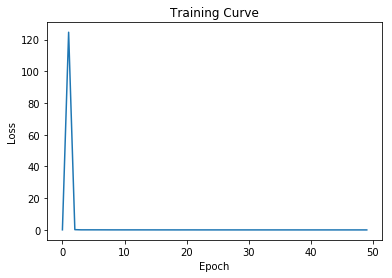

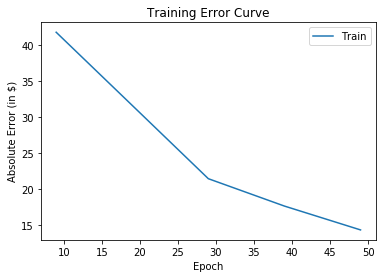

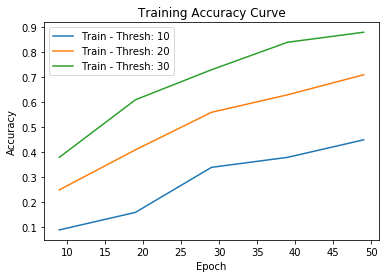

[EPOCH 51] loss: 0.003533  time: 0.400
[EPOCH 52] loss: 0.003184  time: 0.376
[EPOCH 53] loss: 0.003185  time: 0.274
[EPOCH 54] loss: 0.003020  time: 0.316
[EPOCH 55] loss: 0.002822  time: 0.336
[EPOCH 56] loss: 0.002799  time: 0.237
[EPOCH 57] loss: 0.002536  time: 0.241
[EPOCH 58] loss: 0.002543  time: 0.262
[EPOCH 59] loss: 0.002370  time: 0.226
[EPOCH 60] loss: 0.002315  time: 0.718


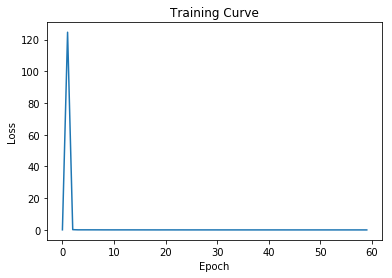

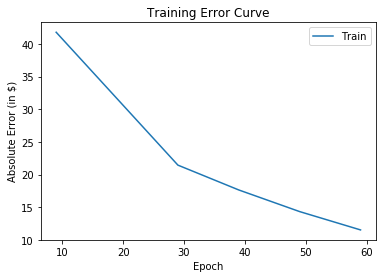

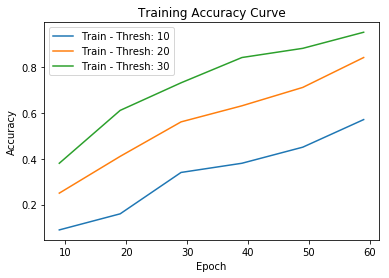

[EPOCH 61] loss: 0.002169  time: 0.192
[EPOCH 62] loss: 0.002073  time: 0.238
[EPOCH 63] loss: 0.001928  time: 0.240
[EPOCH 64] loss: 0.001863  time: 0.237
[EPOCH 65] loss: 0.001730  time: 0.228
[EPOCH 66] loss: 0.001660  time: 0.231
[EPOCH 67] loss: 0.001545  time: 0.262
[EPOCH 68] loss: 0.001492  time: 0.241
[EPOCH 69] loss: 0.001370  time: 0.244
[EPOCH 70] loss: 0.001346  time: 0.622


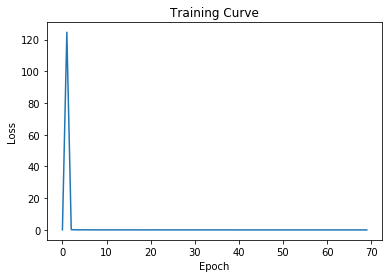

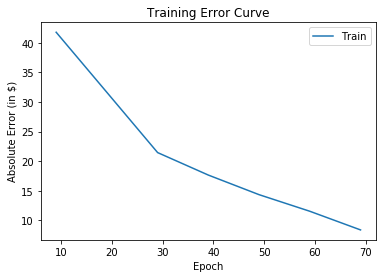

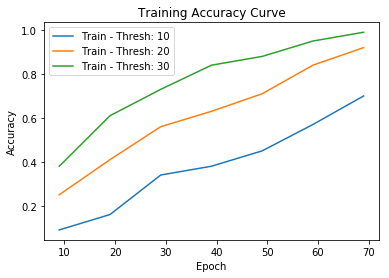

[EPOCH 71] loss: 0.001238  time: 0.980
[EPOCH 72] loss: 0.001188  time: 0.985
[EPOCH 73] loss: 0.001113  time: 0.616
[EPOCH 74] loss: 0.001037  time: 0.396
[EPOCH 75] loss: 0.001003  time: 0.455
[EPOCH 76] loss: 0.000928  time: 0.372
[EPOCH 77] loss: 0.000874  time: 0.367
[EPOCH 78] loss: 0.000827  time: 0.340
[EPOCH 79] loss: 0.000779  time: 0.310
[EPOCH 80] loss: 0.000748  time: 0.750


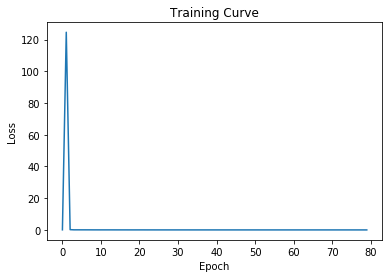

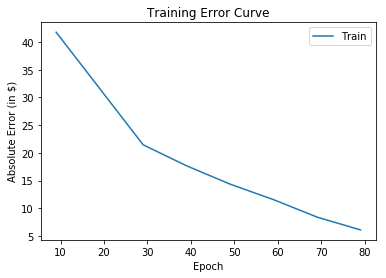

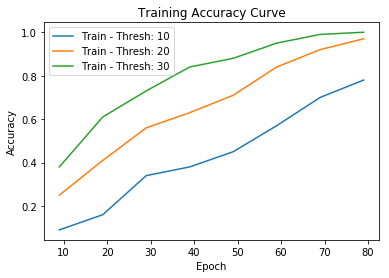

[EPOCH 81] loss: 0.000699  time: 0.569
[EPOCH 82] loss: 0.000661  time: 1.136
[EPOCH 83] loss: 0.000637  time: 1.606
[EPOCH 84] loss: 0.000603  time: 0.773
[EPOCH 85] loss: 0.000566  time: 0.566
[EPOCH 86] loss: 0.000543  time: 0.426
[EPOCH 87] loss: 0.000515  time: 0.396
[EPOCH 88] loss: 0.000483  time: 0.429
[EPOCH 89] loss: 0.000464  time: 0.365
[EPOCH 90] loss: 0.000448  time: 1.070


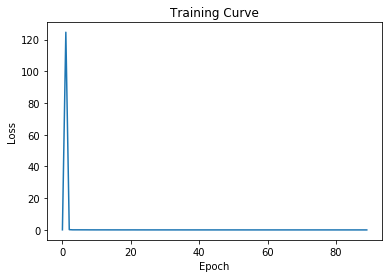

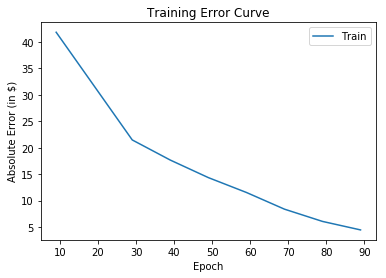

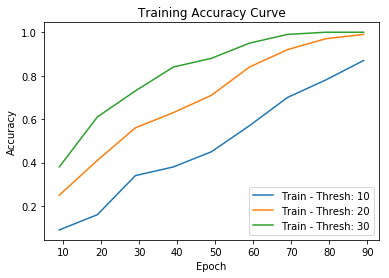

[EPOCH 91] loss: 0.000424  time: 0.187
[EPOCH 92] loss: 0.000402  time: 0.236
[EPOCH 93] loss: 0.000390  time: 0.257
[EPOCH 94] loss: 0.000376  time: 0.258
[EPOCH 95] loss: 0.000357  time: 0.267
[EPOCH 96] loss: 0.000341  time: 0.248
[EPOCH 97] loss: 0.000331  time: 0.239
[EPOCH 98] loss: 0.000321  time: 0.244
[EPOCH 99] loss: 0.000308  time: 0.243
[EPOCH 100] loss: 0.000294  time: 0.663


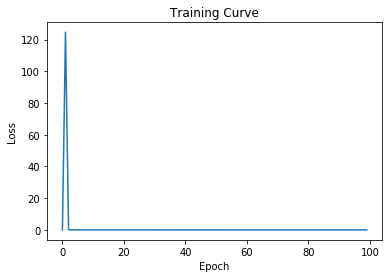

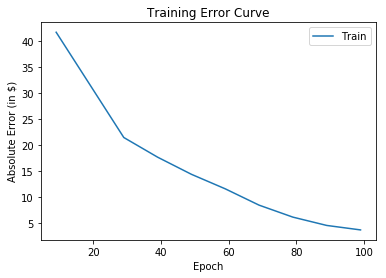

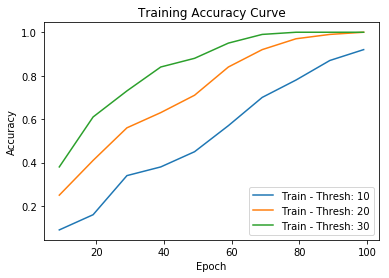

[EPOCH 101] loss: 0.000282  time: 0.664
[EPOCH 102] loss: 0.000273  time: 0.809
[EPOCH 103] loss: 0.000263  time: 0.560
[EPOCH 104] loss: 0.000254  time: 0.493
[EPOCH 105] loss: 0.000244  time: 0.475
[EPOCH 106] loss: 0.000236  time: 0.328
[EPOCH 107] loss: 0.000229  time: 0.329
[EPOCH 108] loss: 0.000222  time: 0.339
[EPOCH 109] loss: 0.000215  time: 0.355
[EPOCH 110] loss: 0.000207  time: 0.919


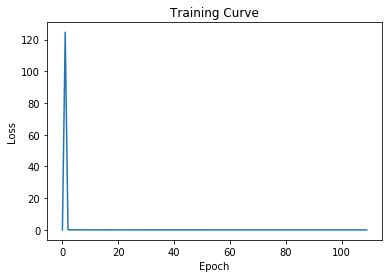

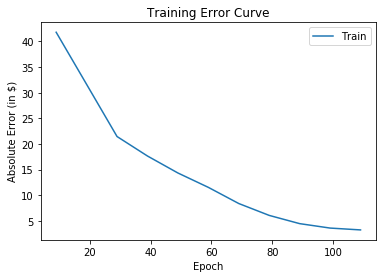

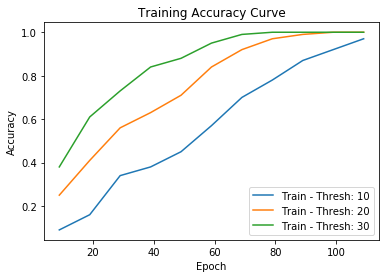

[EPOCH 111] loss: 0.000200  time: 0.241
[EPOCH 112] loss: 0.000196  time: 0.247
[EPOCH 113] loss: 0.000195  time: 0.264
[EPOCH 114] loss: 0.000203  time: 0.271
[EPOCH 115] loss: 0.000217  time: 0.250
[EPOCH 116] loss: 0.000258  time: 0.257
[EPOCH 117] loss: 0.000297  time: 0.264
[EPOCH 118] loss: 0.000393  time: 0.255
[EPOCH 119] loss: 0.000407  time: 0.222
[EPOCH 120] loss: 0.000455  time: 0.705


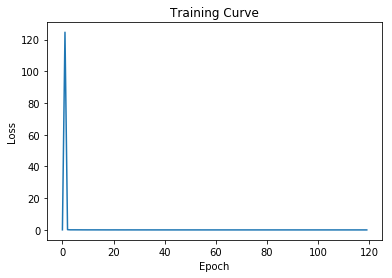

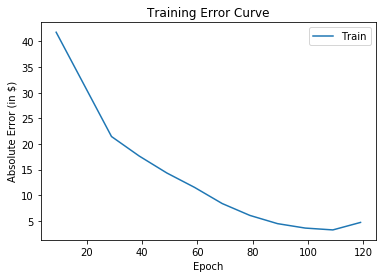

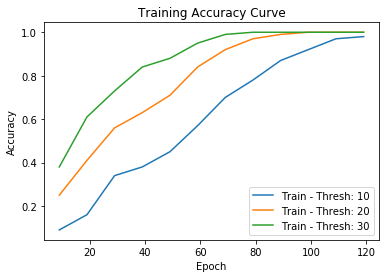

[EPOCH 121] loss: 0.000302  time: 0.533
[EPOCH 122] loss: 0.000180  time: 0.472
[EPOCH 123] loss: 0.000122  time: 0.325
[EPOCH 124] loss: 0.000173  time: 0.335
[EPOCH 125] loss: 0.000262  time: 0.399
[EPOCH 126] loss: 0.000245  time: 0.343
[EPOCH 127] loss: 0.000193  time: 0.365
[EPOCH 128] loss: 0.000113  time: 0.317
[EPOCH 129] loss: 0.000110  time: 0.338
[EPOCH 130] loss: 0.000163  time: 0.775


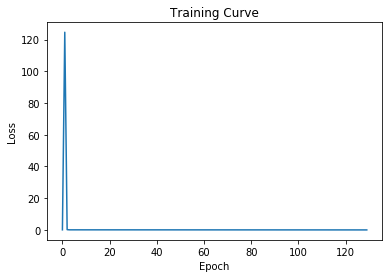

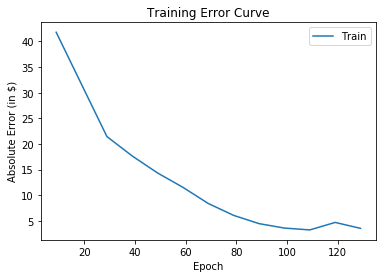

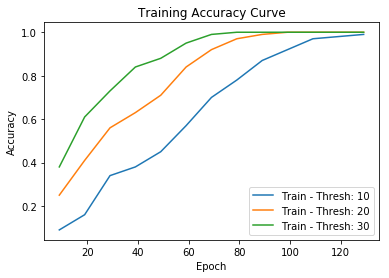

[EPOCH 131] loss: 0.000179  time: 0.606
[EPOCH 132] loss: 0.000164  time: 0.496
[EPOCH 133] loss: 0.000108  time: 0.329
[EPOCH 134] loss: 0.000082  time: 0.330
[EPOCH 135] loss: 0.000099  time: 0.299
[EPOCH 136] loss: 0.000124  time: 0.354
[EPOCH 137] loss: 0.000133  time: 0.382
[EPOCH 138] loss: 0.000104  time: 0.340
[EPOCH 139] loss: 0.000077  time: 0.372
[EPOCH 140] loss: 0.000067  time: 0.856


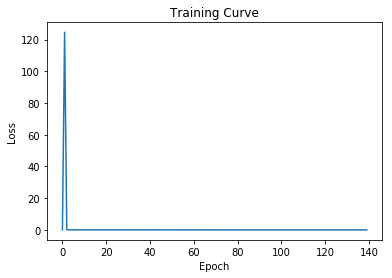

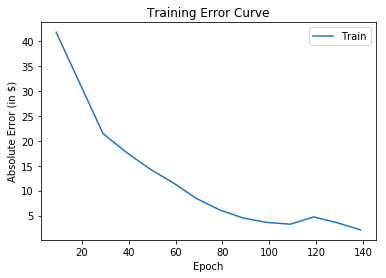

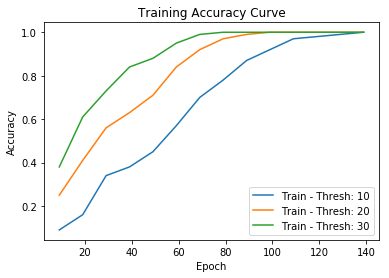

[EPOCH 141] loss: 0.000077  time: 0.375
[EPOCH 142] loss: 0.000094  time: 0.328
[EPOCH 143] loss: 0.000095  time: 0.304
[EPOCH 144] loss: 0.000087  time: 0.319
[EPOCH 145] loss: 0.000068  time: 0.281
[EPOCH 146] loss: 0.000056  time: 0.293
[EPOCH 147] loss: 0.000054  time: 0.255
[EPOCH 148] loss: 0.000060  time: 0.256
[EPOCH 149] loss: 0.000068  time: 0.239
[EPOCH 150] loss: 0.000069  time: 0.667


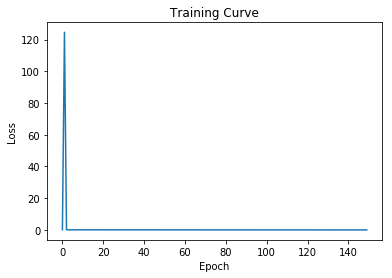

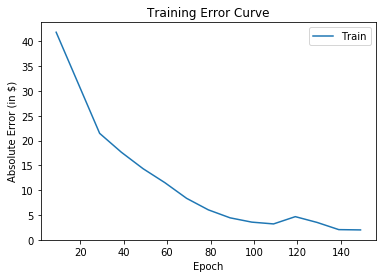

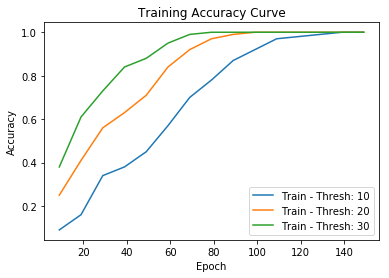

[EPOCH 151] loss: 0.000067  time: 0.198
[EPOCH 152] loss: 0.000058  time: 0.231
[EPOCH 153] loss: 0.000050  time: 0.269
[EPOCH 154] loss: 0.000043  time: 0.245
[EPOCH 155] loss: 0.000041  time: 0.251
[EPOCH 156] loss: 0.000040  time: 0.251
[EPOCH 157] loss: 0.000041  time: 0.219
[EPOCH 158] loss: 0.000043  time: 0.237
[EPOCH 159] loss: 0.000044  time: 0.239
[EPOCH 160] loss: 0.000047  time: 0.742


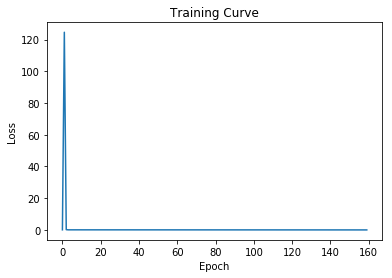

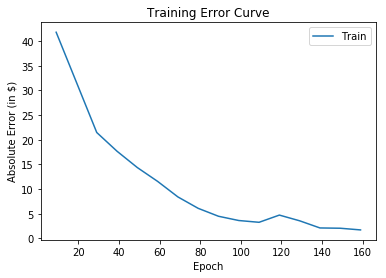

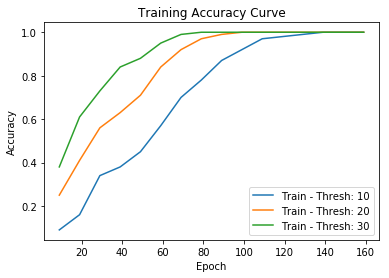

[EPOCH 161] loss: 0.000049  time: 0.231
[EPOCH 162] loss: 0.000056  time: 0.274
[EPOCH 163] loss: 0.000064  time: 0.228
[EPOCH 164] loss: 0.000084  time: 0.245
[EPOCH 165] loss: 0.000102  time: 0.259
[EPOCH 166] loss: 0.000144  time: 0.259
[EPOCH 167] loss: 0.000165  time: 0.264
[EPOCH 168] loss: 0.000228  time: 0.265
[EPOCH 169] loss: 0.000220  time: 0.241
[EPOCH 170] loss: 0.000240  time: 0.807


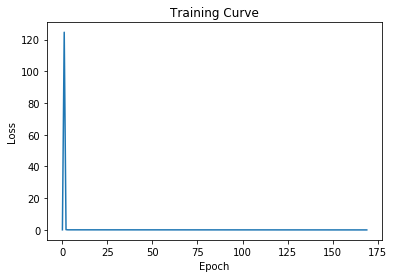

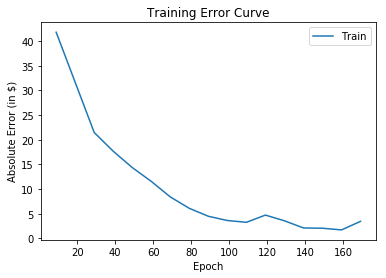

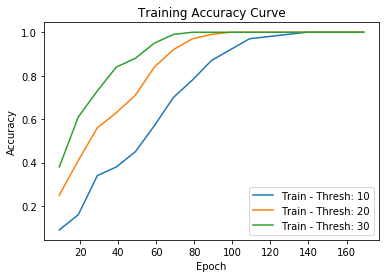

[EPOCH 171] loss: 0.000162  time: 0.263
[EPOCH 172] loss: 0.000100  time: 0.258
[EPOCH 173] loss: 0.000040  time: 0.280
[EPOCH 174] loss: 0.000027  time: 0.270
[EPOCH 175] loss: 0.000058  time: 0.279
[EPOCH 176] loss: 0.000092  time: 0.264
[EPOCH 177] loss: 0.000115  time: 0.267
[EPOCH 178] loss: 0.000089  time: 0.276
[EPOCH 179] loss: 0.000057  time: 0.244
[EPOCH 180] loss: 0.000027  time: 0.682


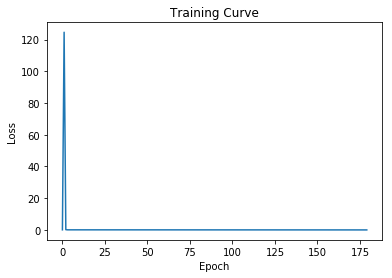

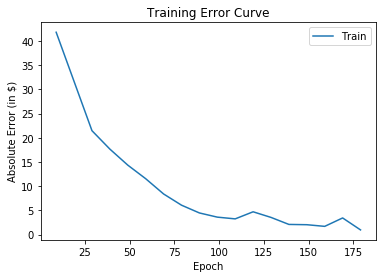

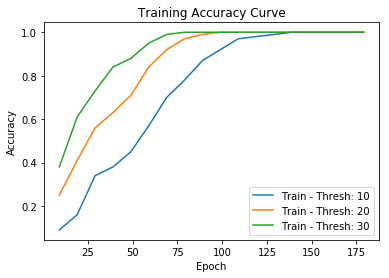

[EPOCH 181] loss: 0.000022  time: 0.299
[EPOCH 182] loss: 0.000039  time: 0.263
[EPOCH 183] loss: 0.000057  time: 0.269
[EPOCH 184] loss: 0.000068  time: 0.254
[EPOCH 185] loss: 0.000058  time: 0.230
[EPOCH 186] loss: 0.000042  time: 0.285
[EPOCH 187] loss: 0.000024  time: 0.265
[EPOCH 188] loss: 0.000017  time: 0.296
[EPOCH 189] loss: 0.000022  time: 0.248
[EPOCH 190] loss: 0.000032  time: 0.762


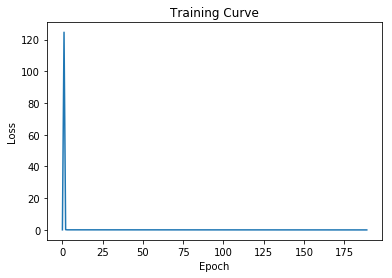

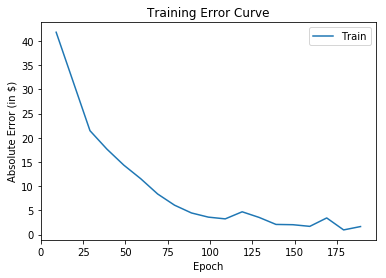

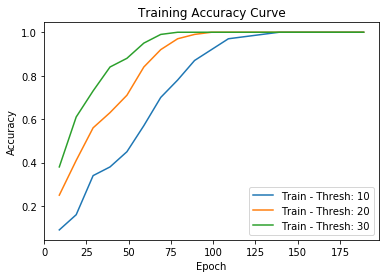

[EPOCH 191] loss: 0.000040  time: 0.852
[EPOCH 192] loss: 0.000040  time: 0.541
[EPOCH 193] loss: 0.000036  time: 0.936
[EPOCH 194] loss: 0.000027  time: 0.685
[EPOCH 195] loss: 0.000019  time: 0.938
[EPOCH 196] loss: 0.000014  time: 0.643
[EPOCH 197] loss: 0.000014  time: 1.169
[EPOCH 198] loss: 0.000018  time: 1.610
[EPOCH 199] loss: 0.000022  time: 0.705
[EPOCH 200] loss: 0.000026  time: 1.268


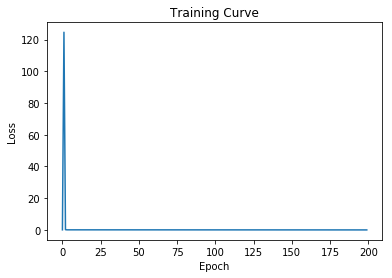

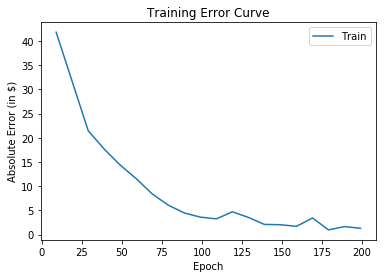

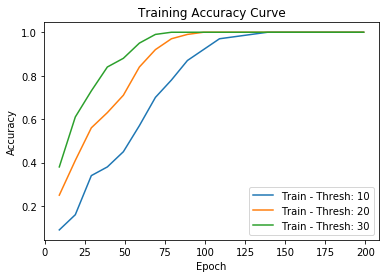

Training Completed...
[FINAL] loss: 0.000026  time: 141.958


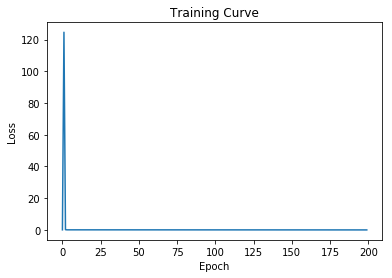

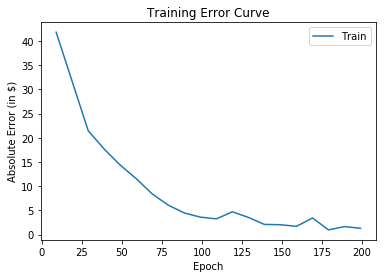

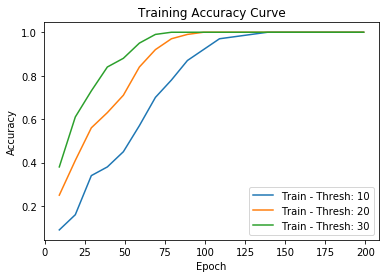

In [13]:
#Using adam optimizer
net = airbnb_net()
path = os.getcwd() # get current path
path = path[:-5]+"test/Helen/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

train(net, train_loader, val_loader, [min_price, max_price], rootdir)

Starting Training...
[EPOCH 1] loss: 0.068558  time: 0.819
[EPOCH 2] loss: 0.061759  time: 1.357
[EPOCH 3] loss: 0.050706  time: 0.539
[EPOCH 4] loss: 0.038732  time: 0.487
[EPOCH 5] loss: 0.028862  time: 0.320
[EPOCH 6] loss: 0.023031  time: 0.318
[EPOCH 7] loss: 0.021746  time: 0.290
[EPOCH 8] loss: 0.024099  time: 0.354
[EPOCH 9] loss: 0.028249  time: 0.290
[EPOCH 10] loss: 0.032110  time: 0.783


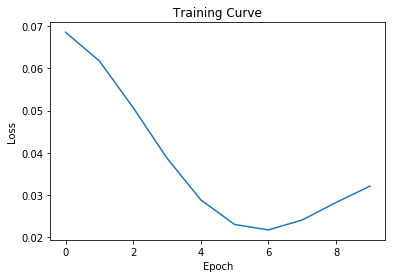

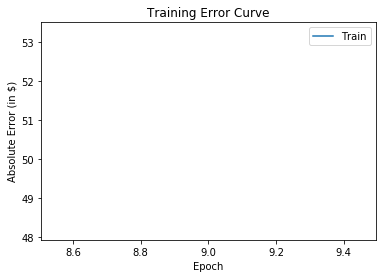

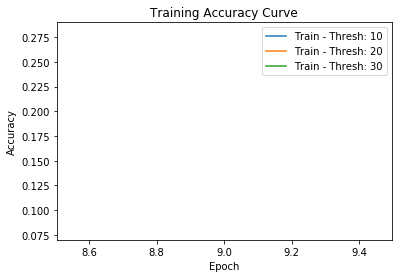

[EPOCH 11] loss: 0.034085  time: 0.184
[EPOCH 12] loss: 0.033557  time: 0.324
[EPOCH 13] loss: 0.030935  time: 0.257
[EPOCH 14] loss: 0.027262  time: 0.267
[EPOCH 15] loss: 0.023683  time: 0.256
[EPOCH 16] loss: 0.021044  time: 0.256
[EPOCH 17] loss: 0.019679  time: 0.257
[EPOCH 18] loss: 0.019487  time: 0.239
[EPOCH 19] loss: 0.020096  time: 0.229
[EPOCH 20] loss: 0.021027  time: 0.634


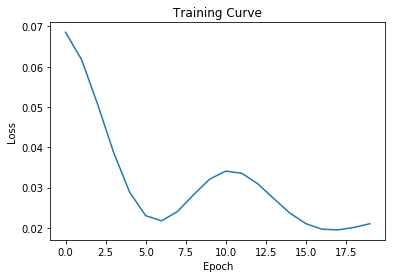

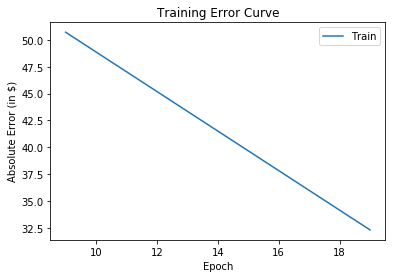

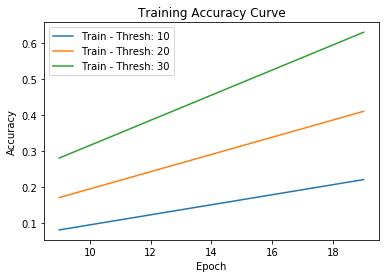

[EPOCH 21] loss: 0.021854  time: 0.775
[EPOCH 22] loss: 0.022280  time: 0.871
[EPOCH 23] loss: 0.022173  time: 0.737
[EPOCH 24] loss: 0.021553  time: 0.686
[EPOCH 25] loss: 0.020561  time: 0.576
[EPOCH 26] loss: 0.019405  time: 0.414
[EPOCH 27] loss: 0.018305  time: 0.507
[EPOCH 28] loss: 0.017441  time: 0.398
[EPOCH 29] loss: 0.016909  time: 0.339
[EPOCH 30] loss: 0.016707  time: 0.856


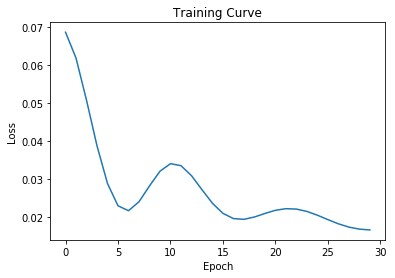

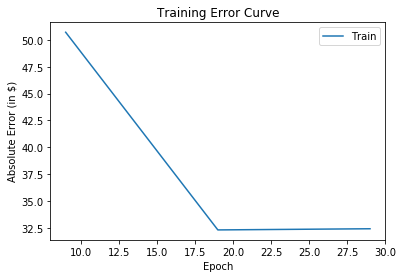

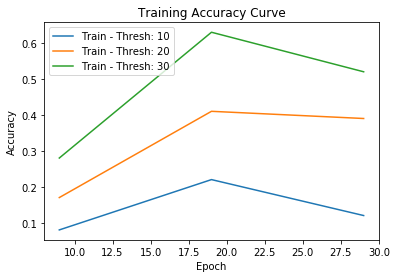

[EPOCH 31] loss: 0.016755  time: 0.435
[EPOCH 32] loss: 0.016912  time: 0.515
[EPOCH 33] loss: 0.017030  time: 0.439
[EPOCH 34] loss: 0.016997  time: 0.431
[EPOCH 35] loss: 0.016766  time: 0.431
[EPOCH 36] loss: 0.016362  time: 0.448
[EPOCH 37] loss: 0.015861  time: 0.496
[EPOCH 38] loss: 0.015358  time: 0.477
[EPOCH 39] loss: 0.014939  time: 0.456
[EPOCH 40] loss: 0.014648  time: 1.195


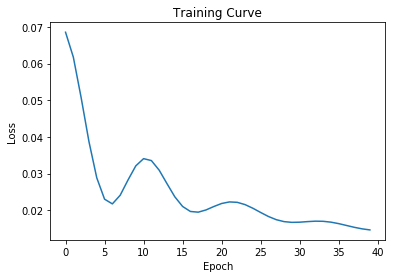

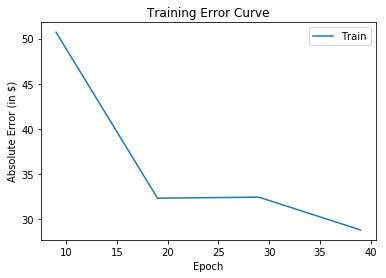

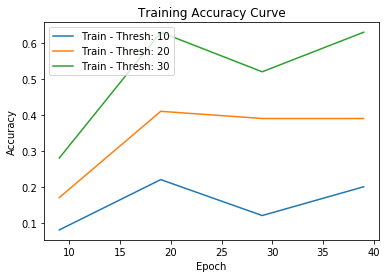

[EPOCH 41] loss: 0.014480  time: 0.364
[EPOCH 42] loss: 0.014406  time: 0.467
[EPOCH 43] loss: 0.014366  time: 0.429
[EPOCH 44] loss: 0.014308  time: 0.448
[EPOCH 45] loss: 0.014194  time: 0.486
[EPOCH 46] loss: 0.014013  time: 0.442
[EPOCH 47] loss: 0.013779  time: 0.461
[EPOCH 48] loss: 0.013522  time: 0.466
[EPOCH 49] loss: 0.013274  time: 0.455
[EPOCH 50] loss: 0.013065  time: 1.191


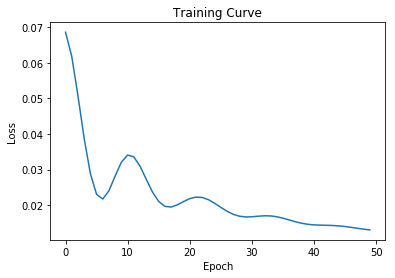

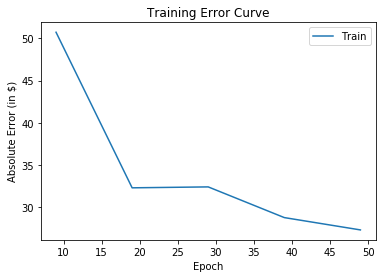

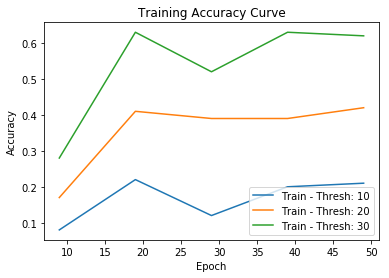

[EPOCH 51] loss: 0.012907  time: 0.421
[EPOCH 52] loss: 0.012797  time: 0.492
[EPOCH 53] loss: 0.012717  time: 0.413
[EPOCH 54] loss: 0.012641  time: 0.456
[EPOCH 55] loss: 0.012550  time: 0.425
[EPOCH 56] loss: 0.012435  time: 0.425
[EPOCH 57] loss: 0.012297  time: 0.468
[EPOCH 58] loss: 0.012148  time: 0.458
[EPOCH 59] loss: 0.012002  time: 0.445
[EPOCH 60] loss: 0.011872  time: 1.315


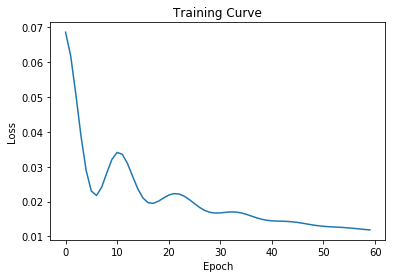

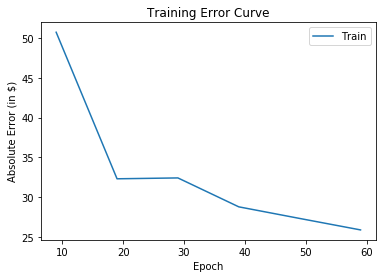

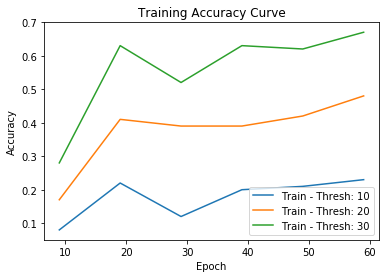

[EPOCH 61] loss: 0.011764  time: 0.364
[EPOCH 62] loss: 0.011676  time: 0.484
[EPOCH 63] loss: 0.011600  time: 0.469
[EPOCH 64] loss: 0.011526  time: 0.473
[EPOCH 65] loss: 0.011446  time: 0.441
[EPOCH 66] loss: 0.011358  time: 0.456
[EPOCH 67] loss: 0.011264  time: 0.480
[EPOCH 68] loss: 0.011167  time: 0.447
[EPOCH 69] loss: 0.011074  time: 0.439
[EPOCH 70] loss: 0.010989  time: 1.315


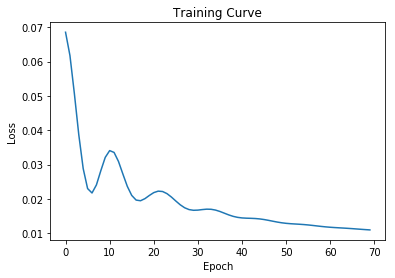

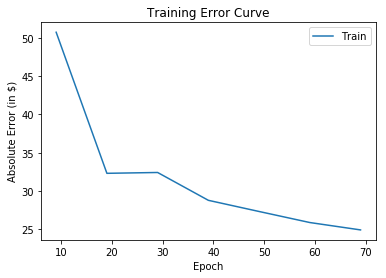

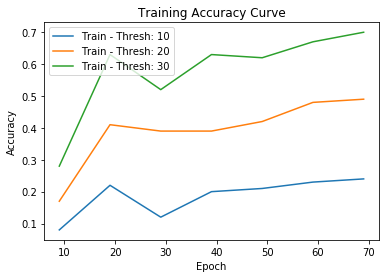

[EPOCH 71] loss: 0.010913  time: 0.338
[EPOCH 72] loss: 0.010843  time: 0.461
[EPOCH 73] loss: 0.010778  time: 0.457
[EPOCH 74] loss: 0.010712  time: 0.451
[EPOCH 75] loss: 0.010644  time: 0.469
[EPOCH 76] loss: 0.010573  time: 0.423
[EPOCH 77] loss: 0.010501  time: 0.473
[EPOCH 78] loss: 0.010432  time: 0.475
[EPOCH 79] loss: 0.010365  time: 0.418
[EPOCH 80] loss: 0.010302  time: 1.217


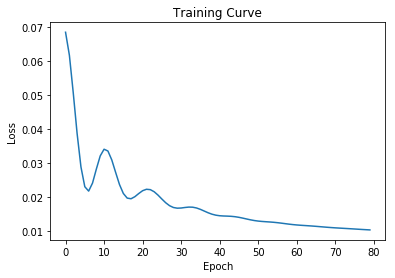

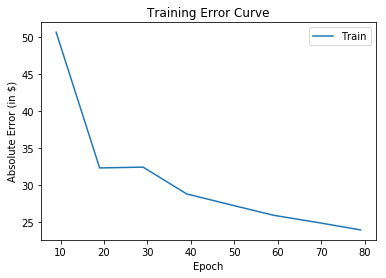

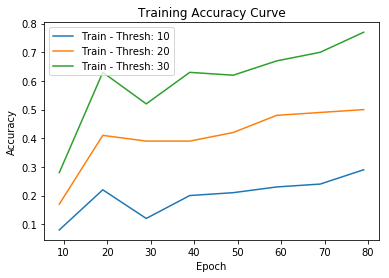

[EPOCH 81] loss: 0.010242  time: 0.363
[EPOCH 82] loss: 0.010184  time: 0.452
[EPOCH 83] loss: 0.010127  time: 0.474
[EPOCH 84] loss: 0.010069  time: 0.428
[EPOCH 85] loss: 0.010010  time: 0.470
[EPOCH 86] loss: 0.009951  time: 0.499
[EPOCH 87] loss: 0.009893  time: 0.481
[EPOCH 88] loss: 0.009837  time: 0.410
[EPOCH 89] loss: 0.009783  time: 0.441
[EPOCH 90] loss: 0.009730  time: 1.172


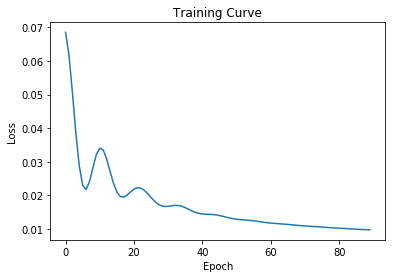

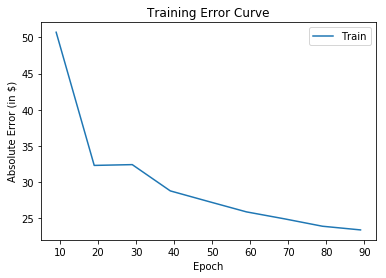

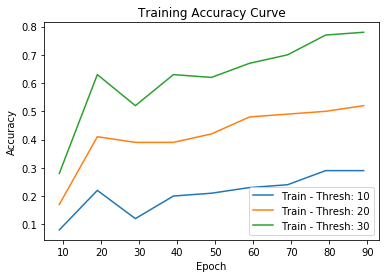

[EPOCH 91] loss: 0.009677  time: 0.412
[EPOCH 92] loss: 0.009625  time: 0.382
[EPOCH 93] loss: 0.009573  time: 0.360
[EPOCH 94] loss: 0.009521  time: 0.465
[EPOCH 95] loss: 0.009469  time: 0.481
[EPOCH 96] loss: 0.009417  time: 0.445
[EPOCH 97] loss: 0.009367  time: 0.440
[EPOCH 98] loss: 0.009317  time: 0.462
[EPOCH 99] loss: 0.009268  time: 0.439
[EPOCH 100] loss: 0.009219  time: 1.221


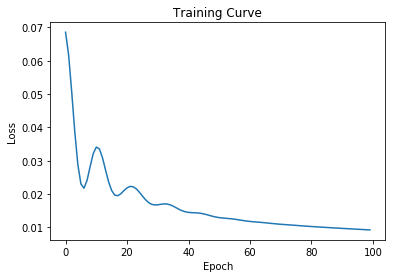

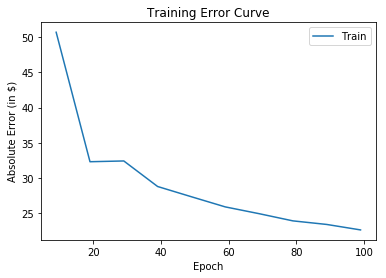

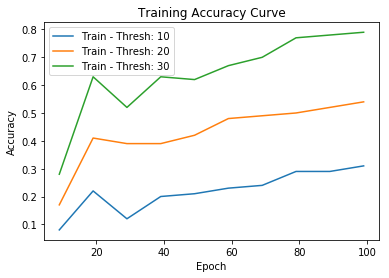

[EPOCH 101] loss: 0.009171  time: 0.370
[EPOCH 102] loss: 0.009122  time: 0.464
[EPOCH 103] loss: 0.009073  time: 0.477
[EPOCH 104] loss: 0.009025  time: 0.569
[EPOCH 105] loss: 0.008977  time: 0.524
[EPOCH 106] loss: 0.008930  time: 0.467
[EPOCH 107] loss: 0.008884  time: 0.463
[EPOCH 108] loss: 0.008838  time: 0.488
[EPOCH 109] loss: 0.008793  time: 0.447
[EPOCH 110] loss: 0.008747  time: 1.270


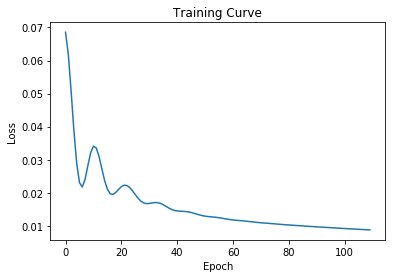

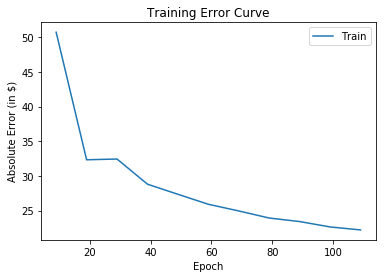

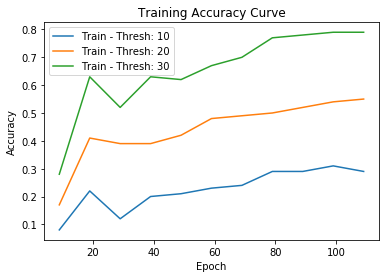

[EPOCH 111] loss: 0.008702  time: 0.436
[EPOCH 112] loss: 0.008658  time: 0.467
[EPOCH 113] loss: 0.008615  time: 0.487
[EPOCH 114] loss: 0.008573  time: 0.420
[EPOCH 115] loss: 0.008531  time: 0.448
[EPOCH 116] loss: 0.008489  time: 0.449
[EPOCH 117] loss: 0.008448  time: 0.449
[EPOCH 118] loss: 0.008406  time: 0.432
[EPOCH 119] loss: 0.008365  time: 0.452
[EPOCH 120] loss: 0.008324  time: 1.286


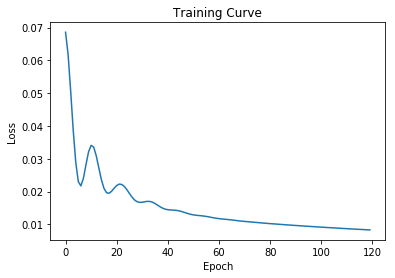

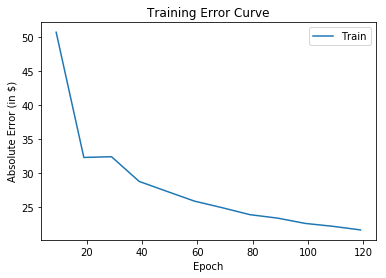

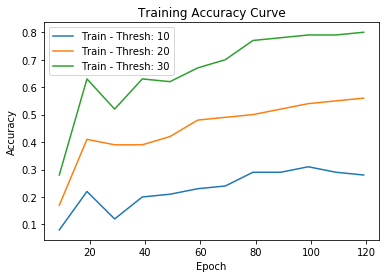

[EPOCH 121] loss: 0.008284  time: 0.374
[EPOCH 122] loss: 0.008244  time: 0.432
[EPOCH 123] loss: 0.008204  time: 0.487
[EPOCH 124] loss: 0.008164  time: 0.416
[EPOCH 125] loss: 0.008125  time: 0.425
[EPOCH 126] loss: 0.008086  time: 0.507
[EPOCH 127] loss: 0.008047  time: 0.445
[EPOCH 128] loss: 0.008008  time: 0.467
[EPOCH 129] loss: 0.007970  time: 0.403
[EPOCH 130] loss: 0.007931  time: 1.169


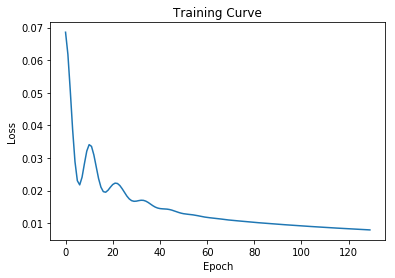

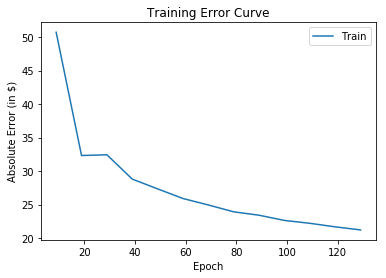

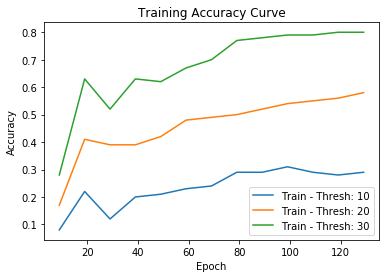

[EPOCH 131] loss: 0.007893  time: 0.478
[EPOCH 132] loss: 0.007855  time: 0.414
[EPOCH 133] loss: 0.007817  time: 0.415
[EPOCH 134] loss: 0.007779  time: 0.418
[EPOCH 135] loss: 0.007742  time: 0.577
[EPOCH 136] loss: 0.007705  time: 0.599
[EPOCH 137] loss: 0.007667  time: 0.437
[EPOCH 138] loss: 0.007630  time: 0.421
[EPOCH 139] loss: 0.007593  time: 0.448
[EPOCH 140] loss: 0.007557  time: 1.170


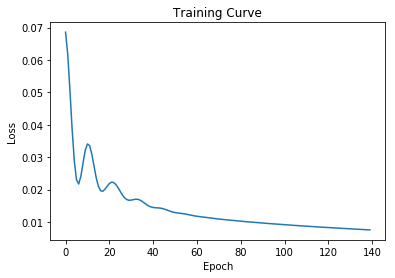

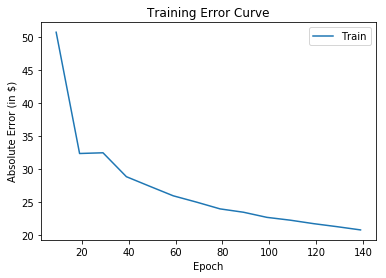

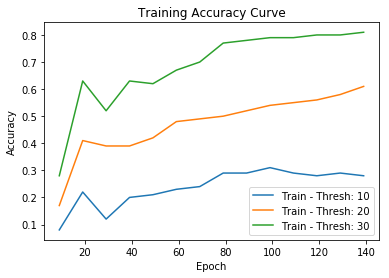

[EPOCH 141] loss: 0.007520  time: 0.427
[EPOCH 142] loss: 0.007484  time: 0.503
[EPOCH 143] loss: 0.007447  time: 0.497
[EPOCH 144] loss: 0.007412  time: 0.512
[EPOCH 145] loss: 0.007376  time: 0.447
[EPOCH 146] loss: 0.007341  time: 0.421
[EPOCH 147] loss: 0.007306  time: 0.360
[EPOCH 148] loss: 0.007271  time: 0.341
[EPOCH 149] loss: 0.007236  time: 0.361
[EPOCH 150] loss: 0.007202  time: 0.985


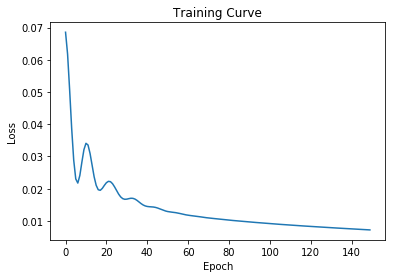

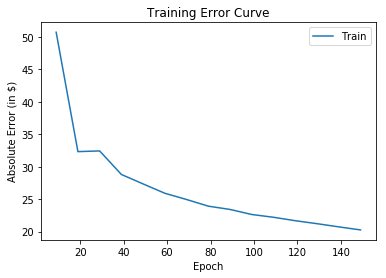

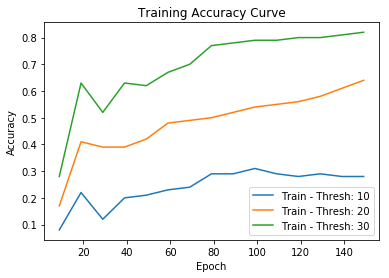

[EPOCH 151] loss: 0.007168  time: 0.631
[EPOCH 152] loss: 0.007134  time: 0.458
[EPOCH 153] loss: 0.007100  time: 0.444
[EPOCH 154] loss: 0.007066  time: 0.504
[EPOCH 155] loss: 0.007032  time: 0.416
[EPOCH 156] loss: 0.006999  time: 0.449
[EPOCH 157] loss: 0.006966  time: 0.441
[EPOCH 158] loss: 0.006932  time: 0.432
[EPOCH 159] loss: 0.006899  time: 0.413
[EPOCH 160] loss: 0.006866  time: 1.110


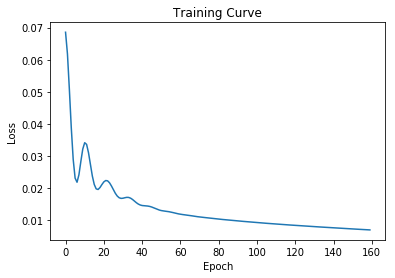

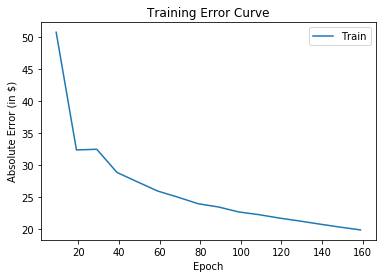

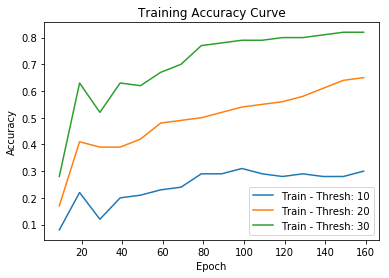

[EPOCH 161] loss: 0.006833  time: 0.353
[EPOCH 162] loss: 0.006800  time: 0.418
[EPOCH 163] loss: 0.006768  time: 0.423
[EPOCH 164] loss: 0.006735  time: 0.410
[EPOCH 165] loss: 0.006703  time: 0.429
[EPOCH 166] loss: 0.006671  time: 0.442
[EPOCH 167] loss: 0.006638  time: 0.460
[EPOCH 168] loss: 0.006606  time: 0.471
[EPOCH 169] loss: 0.006574  time: 0.475
[EPOCH 170] loss: 0.006543  time: 1.222


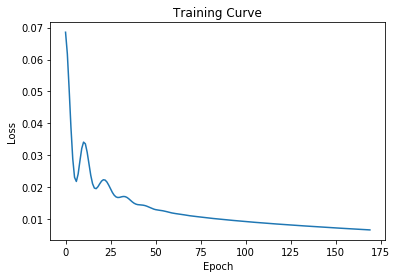

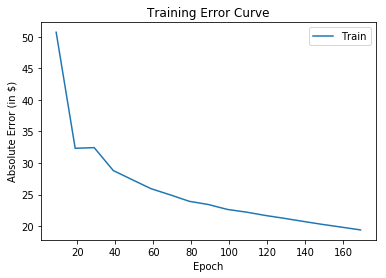

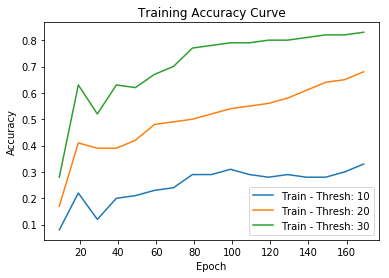

[EPOCH 171] loss: 0.006511  time: 0.679
[EPOCH 172] loss: 0.006479  time: 0.636
[EPOCH 173] loss: 0.006447  time: 0.517
[EPOCH 174] loss: 0.006416  time: 0.415
[EPOCH 175] loss: 0.006385  time: 0.324
[EPOCH 176] loss: 0.006354  time: 0.312
[EPOCH 177] loss: 0.006323  time: 0.316
[EPOCH 178] loss: 0.006292  time: 0.309
[EPOCH 179] loss: 0.006261  time: 0.271
[EPOCH 180] loss: 0.006231  time: 0.705


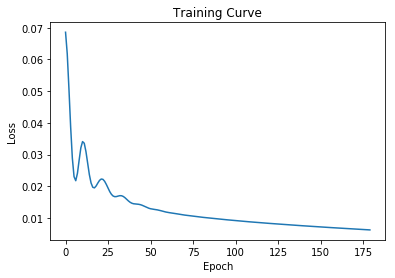

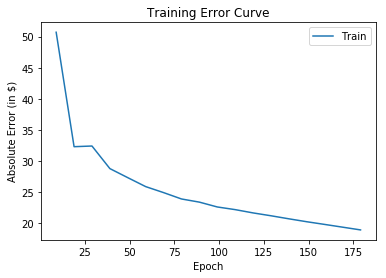

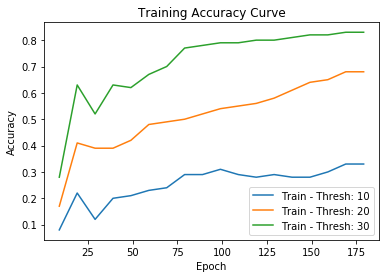

[EPOCH 181] loss: 0.006200  time: 0.447
[EPOCH 182] loss: 0.006169  time: 0.556
[EPOCH 183] loss: 0.006139  time: 0.481
[EPOCH 184] loss: 0.006109  time: 0.427
[EPOCH 185] loss: 0.006078  time: 0.436
[EPOCH 186] loss: 0.006048  time: 0.454
[EPOCH 187] loss: 0.006018  time: 0.417
[EPOCH 188] loss: 0.005988  time: 0.459
[EPOCH 189] loss: 0.005958  time: 0.435
[EPOCH 190] loss: 0.005929  time: 1.195


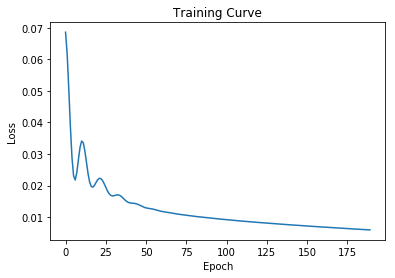

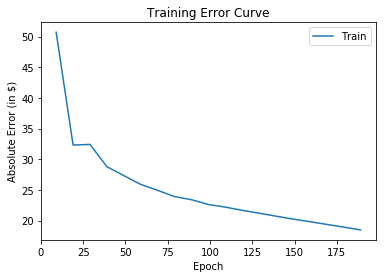

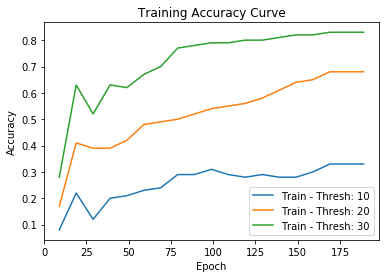

[EPOCH 191] loss: 0.005899  time: 0.352
[EPOCH 192] loss: 0.005869  time: 0.427
[EPOCH 193] loss: 0.005839  time: 0.625
[EPOCH 194] loss: 0.005809  time: 0.575
[EPOCH 195] loss: 0.005780  time: 0.585
[EPOCH 196] loss: 0.005750  time: 0.552
[EPOCH 197] loss: 0.005721  time: 0.577
[EPOCH 198] loss: 0.005691  time: 0.400
[EPOCH 199] loss: 0.005662  time: 0.364
[EPOCH 200] loss: 0.005632  time: 0.897


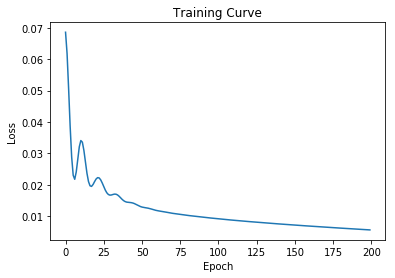

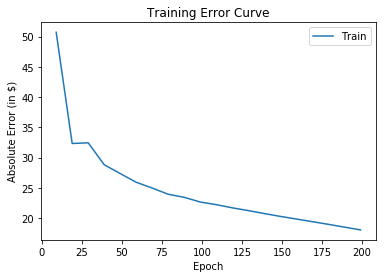

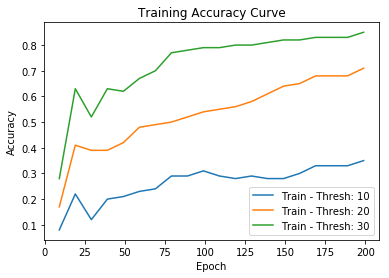

Training Completed...
[FINAL] loss: 0.005632  time: 148.600


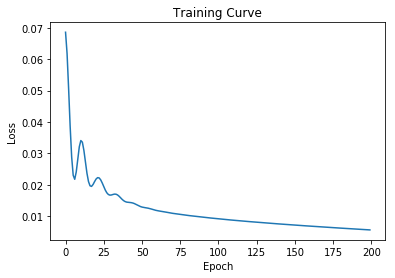

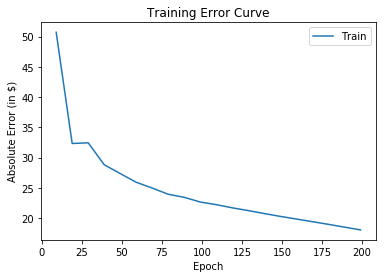

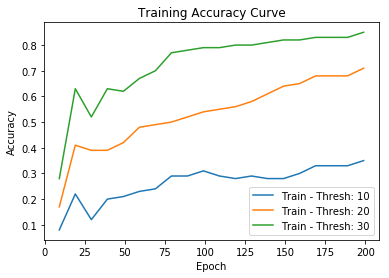

In [11]:
#Using sgd optimizer
net = airbnb_net()
path = os.getcwd() # get current path
path = path[:-5]+"test/Helen/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

train(net, train_loader, val_loader, [min_price, max_price], rootdir)

In [11]:
print(get_error(net, train_loader, val_loader, [10, 20, 30], [min_price, max_price]))

(90.85531782302883, [0.040699688257706965, 0.11941461724974022, 0.19085555940422583], 90.5234578675109, [0.0438961038961039, 0.12389610389610389, 0.19246753246753245])


Starting Training...
[EPOCH 1] loss: 0.085134  time: 1.080
[EPOCH 2] loss: 0.075733  time: 0.696
[EPOCH 3] loss: 0.060520  time: 0.564
[EPOCH 4] loss: 0.044148  time: 0.533
[EPOCH 5] loss: 0.030843  time: 0.596
[EPOCH 6] loss: 0.023241  time: 0.556
[EPOCH 7] loss: 0.021837  time: 0.584
[EPOCH 8] loss: 0.025260  time: 0.860
[EPOCH 9] loss: 0.030947  time: 1.148
[EPOCH 10] loss: 0.036081  time: 2.242


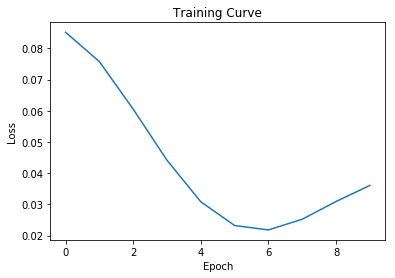

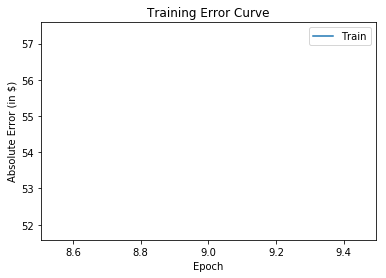

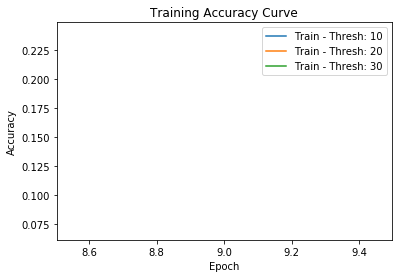

[EPOCH 11] loss: 0.038572  time: 0.336
[EPOCH 12] loss: 0.037707  time: 0.296
[EPOCH 13] loss: 0.034136  time: 0.292
[EPOCH 14] loss: 0.029323  time: 0.360
[EPOCH 15] loss: 0.024769  time: 0.336
[EPOCH 16] loss: 0.021489  time: 0.248
[EPOCH 17] loss: 0.019861  time: 0.256
[EPOCH 18] loss: 0.019714  time: 0.320
[EPOCH 19] loss: 0.020550  time: 0.376
[EPOCH 20] loss: 0.021782  time: 0.800


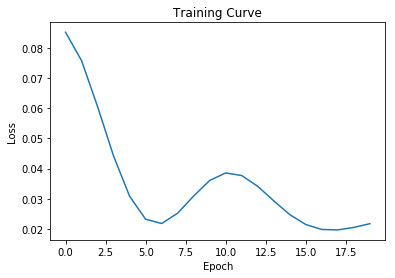

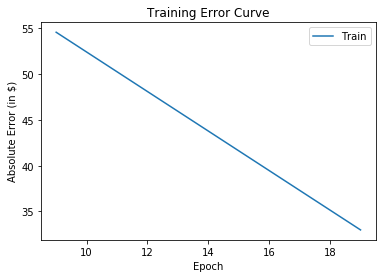

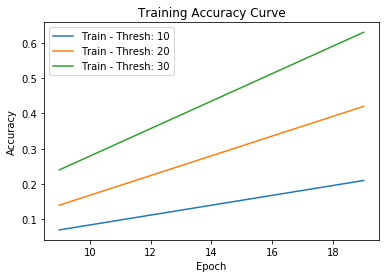

[EPOCH 21] loss: 0.022897  time: 0.677
[EPOCH 22] loss: 0.023544  time: 0.436
[EPOCH 23] loss: 0.023553  time: 0.352
[EPOCH 24] loss: 0.022935  time: 0.788
[EPOCH 25] loss: 0.021833  time: 1.132
[EPOCH 26] loss: 0.020480  time: 1.180
[EPOCH 27] loss: 0.019130  time: 0.652
[EPOCH 28] loss: 0.018000  time: 0.612
[EPOCH 29] loss: 0.017239  time: 0.596
[EPOCH 30] loss: 0.016884  time: 1.000


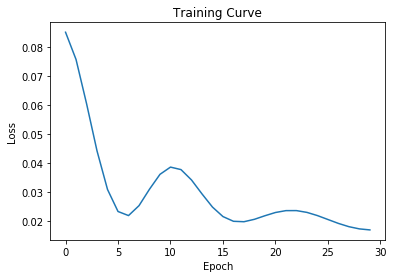

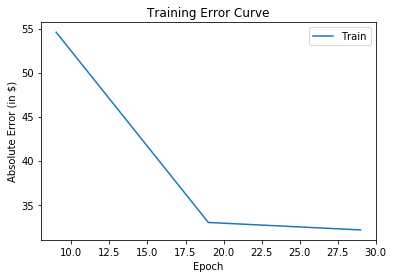

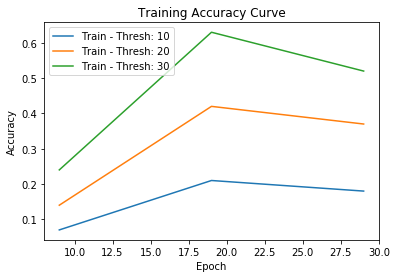

[EPOCH 31] loss: 0.016873  time: 0.348
[EPOCH 32] loss: 0.017067  time: 0.420
[EPOCH 33] loss: 0.017294  time: 0.328
[EPOCH 34] loss: 0.017402  time: 0.304
[EPOCH 35] loss: 0.017296  time: 0.260
[EPOCH 36] loss: 0.016963  time: 0.352
[EPOCH 37] loss: 0.016461  time: 0.300
[EPOCH 38] loss: 0.015888  time: 0.336
[EPOCH 39] loss: 0.015348  time: 0.300
[EPOCH 40] loss: 0.014918  time: 0.647


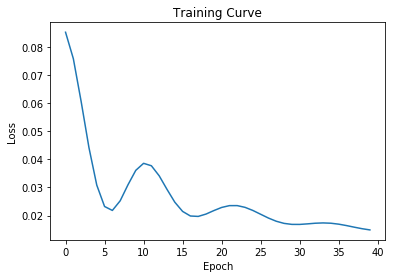

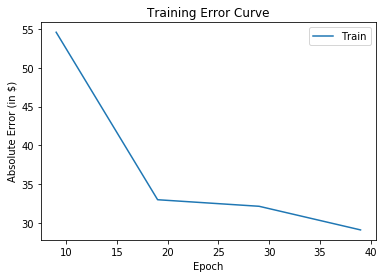

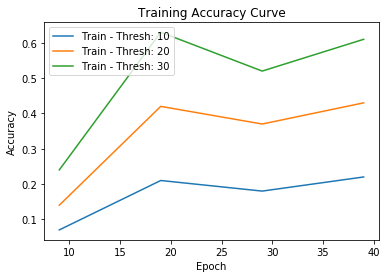

[EPOCH 41] loss: 0.014635  time: 0.700
[EPOCH 42] loss: 0.014486  time: 0.624
[EPOCH 43] loss: 0.014427  time: 0.751
[EPOCH 44] loss: 0.014396  time: 0.536
[EPOCH 45] loss: 0.014340  time: 0.491
[EPOCH 46] loss: 0.014223  time: 0.664
[EPOCH 47] loss: 0.014034  time: 0.556
[EPOCH 48] loss: 0.013786  time: 0.460
[EPOCH 49] loss: 0.013510  time: 0.712
[EPOCH 50] loss: 0.013240  time: 2.105


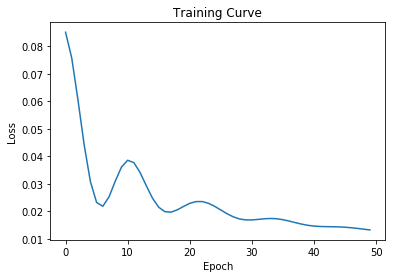

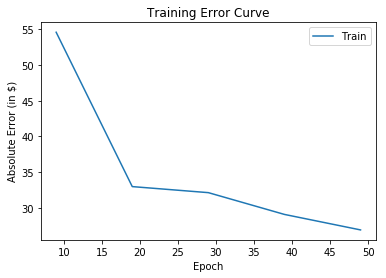

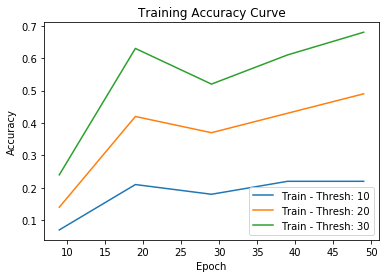

[EPOCH 51] loss: 0.013005  time: 0.552
[EPOCH 52] loss: 0.012824  time: 0.400
[EPOCH 53] loss: 0.012693  time: 0.396
[EPOCH 54] loss: 0.012597  time: 0.286
[EPOCH 55] loss: 0.012515  time: 0.328
[EPOCH 56] loss: 0.012423  time: 0.321
[EPOCH 57] loss: 0.012309  time: 0.280
[EPOCH 58] loss: 0.012170  time: 0.244
[EPOCH 59] loss: 0.012013  time: 0.224
[EPOCH 60] loss: 0.011854  time: 0.688


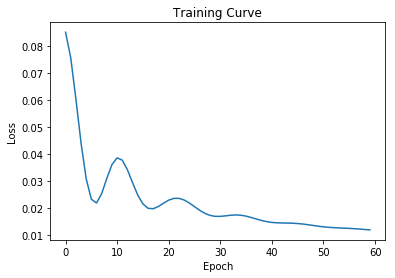

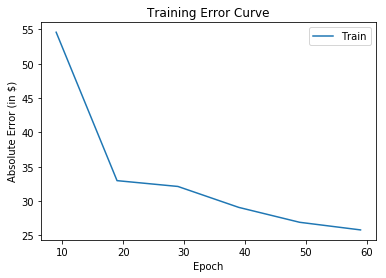

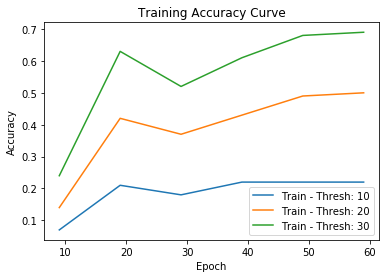

[EPOCH 61] loss: 0.011705  time: 0.188
[EPOCH 62] loss: 0.011578  time: 0.208
[EPOCH 63] loss: 0.011475  time: 0.212
[EPOCH 64] loss: 0.011389  time: 0.208
[EPOCH 65] loss: 0.011312  time: 0.208
[EPOCH 66] loss: 0.011235  time: 0.204
[EPOCH 67] loss: 0.011151  time: 0.212
[EPOCH 68] loss: 0.011057  time: 0.216
[EPOCH 69] loss: 0.010957  time: 0.204
[EPOCH 70] loss: 0.010857  time: 0.608


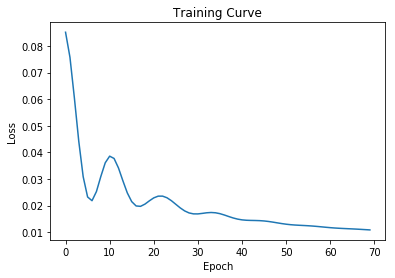

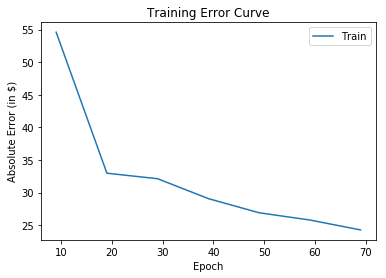

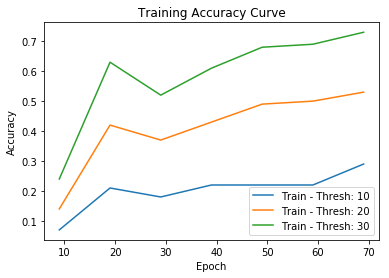

[EPOCH 71] loss: 0.010761  time: 0.476
[EPOCH 72] loss: 0.010673  time: 0.552
[EPOCH 73] loss: 0.010595  time: 0.484
[EPOCH 74] loss: 0.010523  time: 0.456
[EPOCH 75] loss: 0.010456  time: 0.476
[EPOCH 76] loss: 0.010388  time: 0.460
[EPOCH 77] loss: 0.010319  time: 0.472
[EPOCH 78] loss: 0.010246  time: 0.460
[EPOCH 79] loss: 0.010172  time: 0.484
[EPOCH 80] loss: 0.010100  time: 1.308


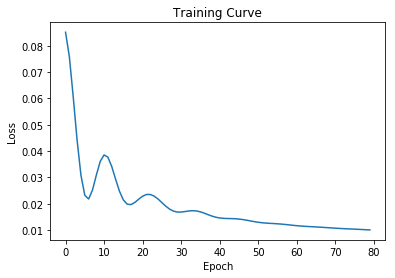

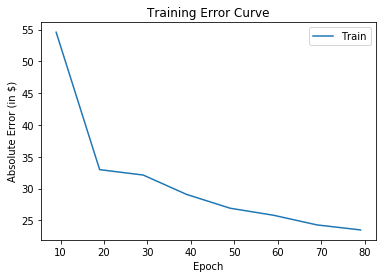

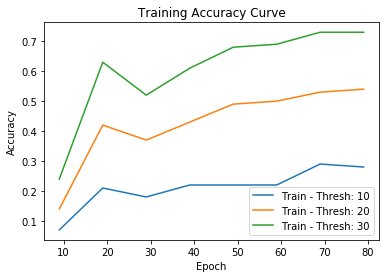

[EPOCH 81] loss: 0.010030  time: 0.464
[EPOCH 82] loss: 0.009964  time: 0.464
[EPOCH 83] loss: 0.009903  time: 0.460
[EPOCH 84] loss: 0.009844  time: 0.468
[EPOCH 85] loss: 0.009787  time: 0.488
[EPOCH 86] loss: 0.009730  time: 0.468
[EPOCH 87] loss: 0.009672  time: 0.436
[EPOCH 88] loss: 0.009614  time: 0.460
[EPOCH 89] loss: 0.009555  time: 0.444
[EPOCH 90] loss: 0.009499  time: 1.232


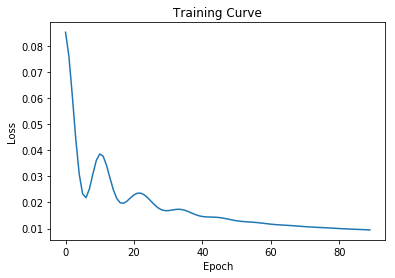

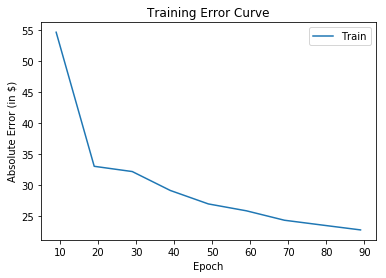

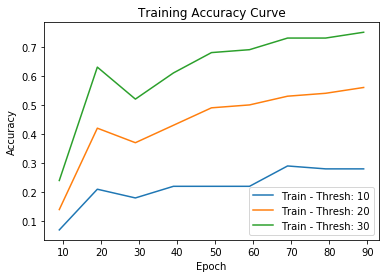

[EPOCH 91] loss: 0.009445  time: 0.384
[EPOCH 92] loss: 0.009392  time: 0.476
[EPOCH 93] loss: 0.009341  time: 0.592
[EPOCH 94] loss: 0.009291  time: 0.536
[EPOCH 95] loss: 0.009241  time: 0.756
[EPOCH 96] loss: 0.009191  time: 0.620
[EPOCH 97] loss: 0.009140  time: 0.584
[EPOCH 98] loss: 0.009091  time: 0.656
[EPOCH 99] loss: 0.009042  time: 0.584
[EPOCH 100] loss: 0.008994  time: 1.312


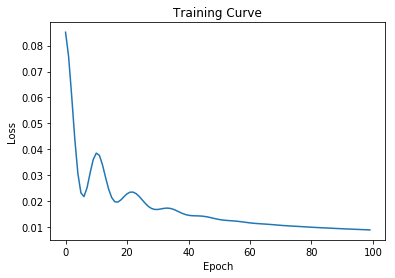

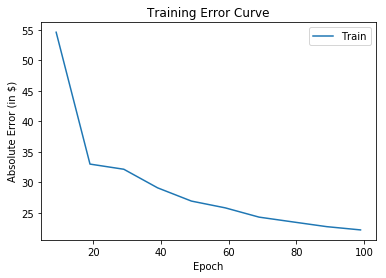

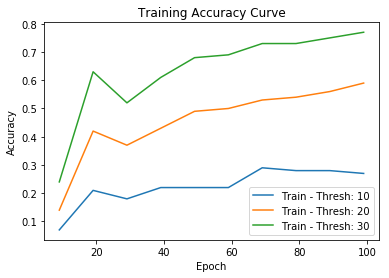

[EPOCH 101] loss: 0.008948  time: 0.568
[EPOCH 102] loss: 0.008902  time: 0.544
[EPOCH 103] loss: 0.008856  time: 0.472
[EPOCH 104] loss: 0.008810  time: 0.448
[EPOCH 105] loss: 0.008765  time: 0.448
[EPOCH 106] loss: 0.008719  time: 0.700
[EPOCH 107] loss: 0.008674  time: 0.480
[EPOCH 108] loss: 0.008629  time: 0.436
[EPOCH 109] loss: 0.008584  time: 0.448
[EPOCH 110] loss: 0.008540  time: 1.236


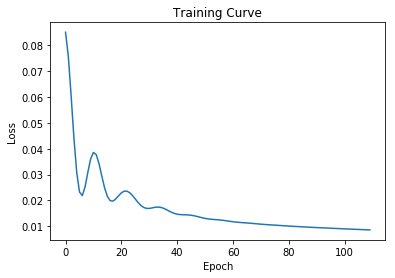

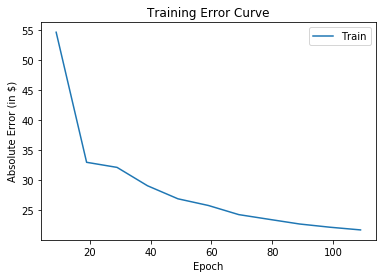

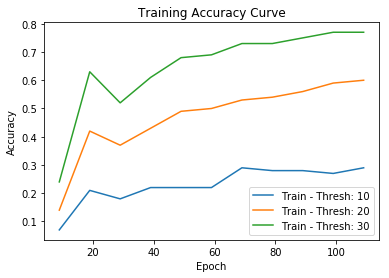

[EPOCH 111] loss: 0.008497  time: 0.336
[EPOCH 112] loss: 0.008454  time: 0.480
[EPOCH 113] loss: 0.008411  time: 0.444
[EPOCH 114] loss: 0.008368  time: 0.448
[EPOCH 115] loss: 0.008325  time: 0.448
[EPOCH 116] loss: 0.008282  time: 0.464
[EPOCH 117] loss: 0.008239  time: 0.440
[EPOCH 118] loss: 0.008197  time: 0.460
[EPOCH 119] loss: 0.008155  time: 0.448
[EPOCH 120] loss: 0.008114  time: 1.228


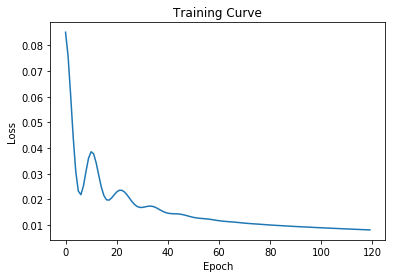

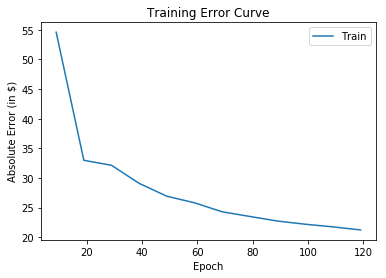

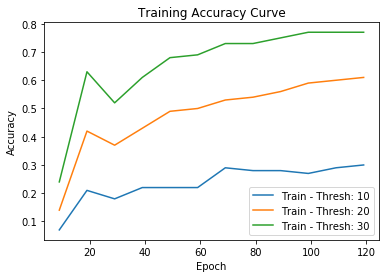

[EPOCH 121] loss: 0.008074  time: 0.588
[EPOCH 122] loss: 0.008033  time: 0.680
[EPOCH 123] loss: 0.007993  time: 0.572
[EPOCH 124] loss: 0.007953  time: 0.416
[EPOCH 125] loss: 0.007914  time: 0.401
[EPOCH 126] loss: 0.007874  time: 0.364
[EPOCH 127] loss: 0.007835  time: 0.416
[EPOCH 128] loss: 0.007796  time: 0.304
[EPOCH 129] loss: 0.007757  time: 0.304
[EPOCH 130] loss: 0.007718  time: 0.816


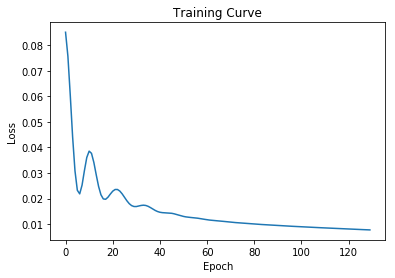

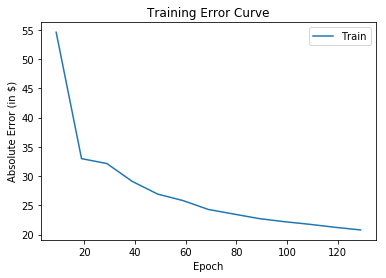

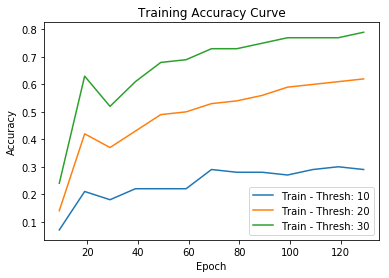

[EPOCH 131] loss: 0.007680  time: 0.340
[EPOCH 132] loss: 0.007642  time: 0.504
[EPOCH 133] loss: 0.007604  time: 0.468
[EPOCH 134] loss: 0.007566  time: 0.440
[EPOCH 135] loss: 0.007528  time: 0.448
[EPOCH 136] loss: 0.007491  time: 0.456
[EPOCH 137] loss: 0.007453  time: 0.615
[EPOCH 138] loss: 0.007416  time: 0.476
[EPOCH 139] loss: 0.007379  time: 0.448
[EPOCH 140] loss: 0.007342  time: 1.240


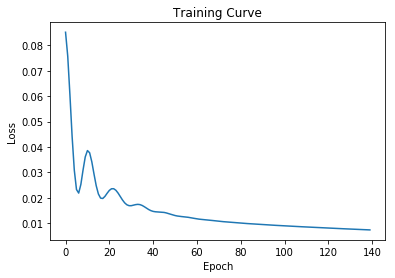

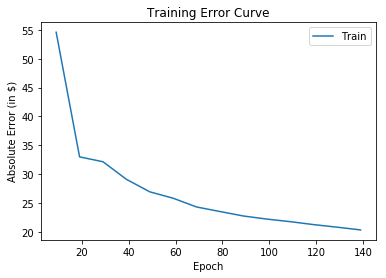

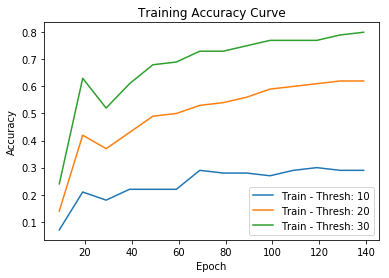

[EPOCH 141] loss: 0.007306  time: 0.328
[EPOCH 142] loss: 0.007269  time: 0.660
[EPOCH 143] loss: 0.007233  time: 0.660
[EPOCH 144] loss: 0.007197  time: 0.652
[EPOCH 145] loss: 0.007161  time: 0.524
[EPOCH 146] loss: 0.007125  time: 0.440
[EPOCH 147] loss: 0.007090  time: 0.369
[EPOCH 148] loss: 0.007055  time: 0.380
[EPOCH 149] loss: 0.007020  time: 0.348
[EPOCH 150] loss: 0.006984  time: 0.900


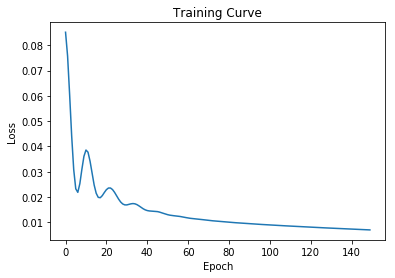

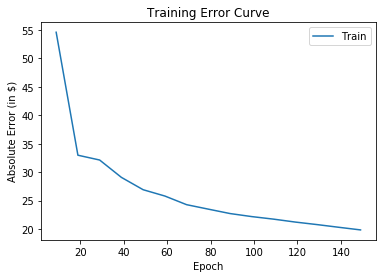

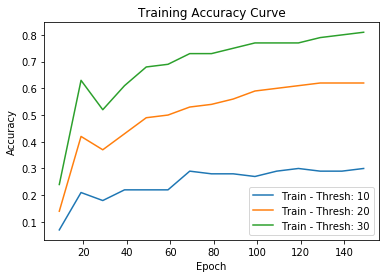

[EPOCH 151] loss: 0.006949  time: 0.360
[EPOCH 152] loss: 0.006914  time: 0.500
[EPOCH 153] loss: 0.006879  time: 0.440
[EPOCH 154] loss: 0.006845  time: 0.432
[EPOCH 155] loss: 0.006812  time: 0.464
[EPOCH 156] loss: 0.006778  time: 0.444
[EPOCH 157] loss: 0.006744  time: 0.444
[EPOCH 158] loss: 0.006711  time: 0.436
[EPOCH 159] loss: 0.006678  time: 0.456
[EPOCH 160] loss: 0.006645  time: 1.276


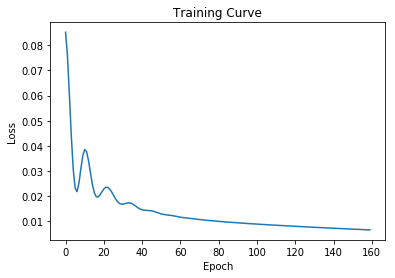

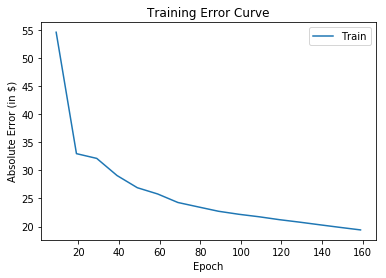

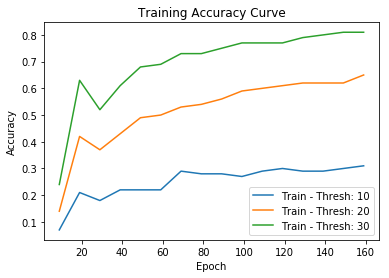

[EPOCH 161] loss: 0.006612  time: 1.812
[EPOCH 162] loss: 0.006579  time: 0.851
[EPOCH 163] loss: 0.006547  time: 0.920
[EPOCH 164] loss: 0.006515  time: 0.390
[EPOCH 165] loss: 0.006483  time: 0.721
[EPOCH 166] loss: 0.006451  time: 0.588
[EPOCH 167] loss: 0.006419  time: 0.456
[EPOCH 168] loss: 0.006387  time: 0.356
[EPOCH 169] loss: 0.006356  time: 0.276
[EPOCH 170] loss: 0.006324  time: 0.620


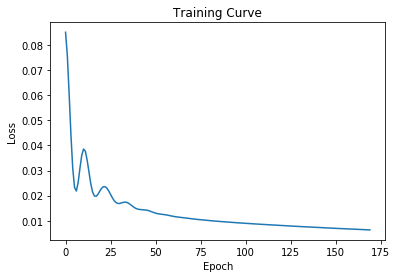

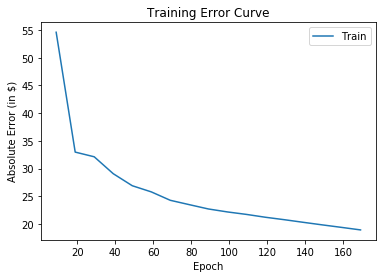

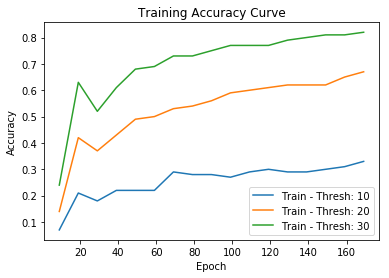

[EPOCH 171] loss: 0.006293  time: 0.772
[EPOCH 172] loss: 0.006261  time: 0.621
[EPOCH 173] loss: 0.006230  time: 0.476
[EPOCH 174] loss: 0.006199  time: 0.472
[EPOCH 175] loss: 0.006168  time: 0.700
[EPOCH 176] loss: 0.006137  time: 0.612
[EPOCH 177] loss: 0.006106  time: 0.528
[EPOCH 178] loss: 0.006076  time: 1.711
[EPOCH 179] loss: 0.006045  time: 1.063
[EPOCH 180] loss: 0.006014  time: 2.114


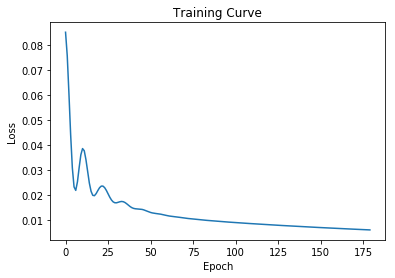

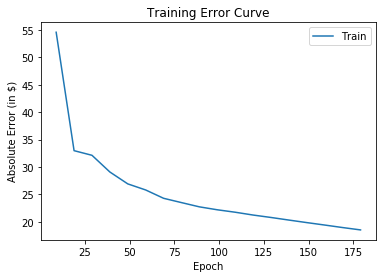

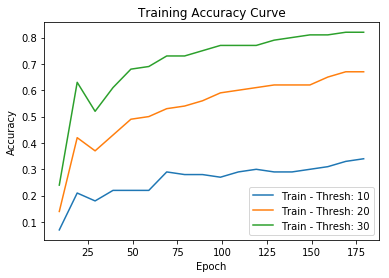

[EPOCH 181] loss: 0.005984  time: 0.523
[EPOCH 182] loss: 0.005954  time: 0.495
[EPOCH 183] loss: 0.005923  time: 0.466
[EPOCH 184] loss: 0.005893  time: 0.468
[EPOCH 185] loss: 0.005863  time: 0.436
[EPOCH 186] loss: 0.005833  time: 0.448
[EPOCH 187] loss: 0.005804  time: 0.484
[EPOCH 188] loss: 0.005774  time: 0.449
[EPOCH 189] loss: 0.005744  time: 0.459
[EPOCH 190] loss: 0.005715  time: 1.720


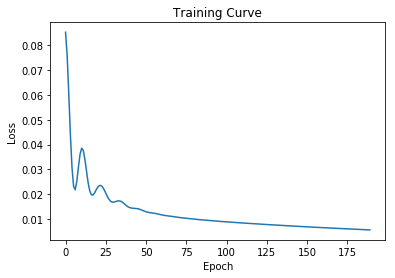

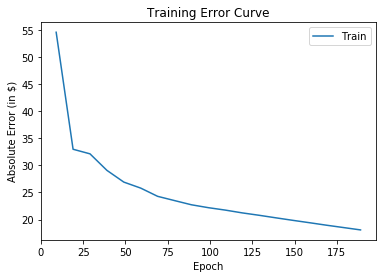

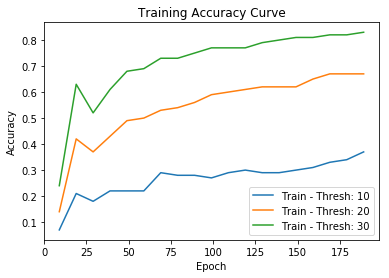

[EPOCH 191] loss: 0.005686  time: 0.336
[EPOCH 192] loss: 0.005656  time: 0.508
[EPOCH 193] loss: 0.005627  time: 0.492
[EPOCH 194] loss: 0.005598  time: 0.464
[EPOCH 195] loss: 0.005569  time: 0.444
[EPOCH 196] loss: 0.005541  time: 0.440
[EPOCH 197] loss: 0.005512  time: 0.432
[EPOCH 198] loss: 0.005483  time: 0.448
[EPOCH 199] loss: 0.005455  time: 0.440
[EPOCH 200] loss: 0.005426  time: 1.380


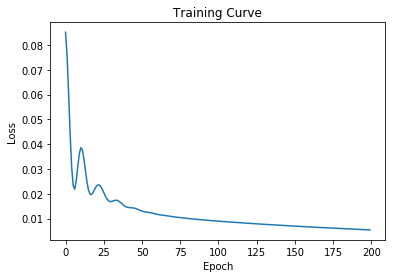

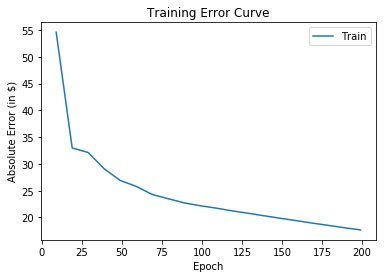

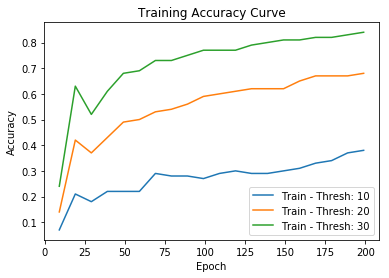

Training Completed...
[FINAL] loss: 0.005426  time: 152.736


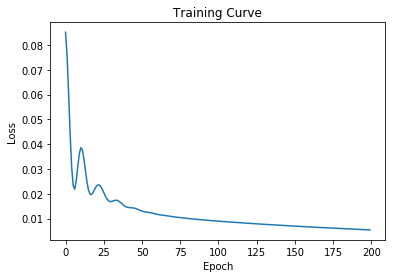

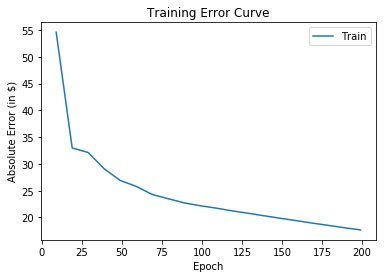

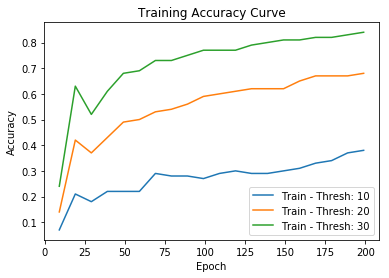

In [23]:
#training small dataset
train(net, train_loader, val_loader, [min_price, max_price], rootdir)
#train(net, train_loader, val_loader, [min_price, max_price],)

In [ ]:
train(net, train_loader, val_loader, [min_price, max_price], rootdir)

Starting Training...
---[ITER 10] loss: 0.082693  time: 39.391
---[ITER 20] loss: 0.046635  time: 36.375
---[ITER 30] loss: 0.037277  time: 37.083
---[ITER 40] loss: 0.030716  time: 43.509
---[ITER 50] loss: 0.028698  time: 51.384
---[ITER 60] loss: 0.027119  time: 37.824
---[ITER 70] loss: 0.026732  time: 48.988
---[ITER 80] loss: 0.026216  time: 37.403
---[ITER 90] loss: 0.025081  time: 44.197
---[ITER 100] loss: 0.026030  time: 35.591
---[ITER 110] loss: 0.025539  time: 13.878
---[ITER 120] loss: 0.024942  time: 1985.195
[EPOCH 1] loss: 0.033526  time: 2422.653
---[ITER 10] loss: 0.024865  time: 19.392
---[ITER 20] loss: 0.024838  time: 14.989
---[ITER 30] loss: 0.024162  time: 16.892
---[ITER 40] loss: 0.023532  time: 17.340
---[ITER 50] loss: 0.024027  time: 30.147
---[ITER 60] loss: 0.023176  time: 45.995
---[ITER 70] loss: 0.023564  time: 39.324
---[ITER 80] loss: 0.023430  time: 38.394
---[ITER 90] loss: 0.022759  time: 40.830
---[ITER 100] loss: 0.023777  time: 48.610
---[ITER

Starting Training...
[EPOCH 1] loss: 0.002828  time: 0.511
[EPOCH 2] loss: 0.002826  time: 0.598
[EPOCH 3] loss: 0.002822  time: 0.518
[EPOCH 4] loss: 0.002816  time: 0.426
[EPOCH 5] loss: 0.002809  time: 0.457


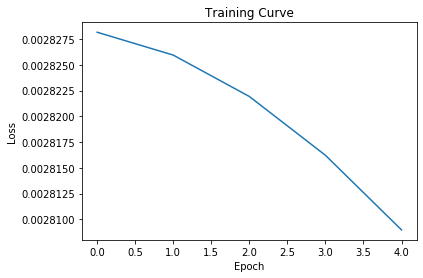

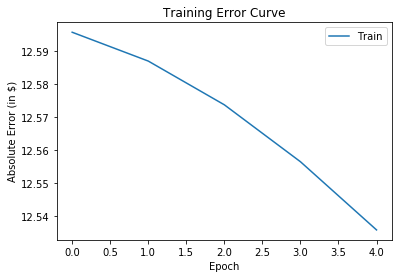

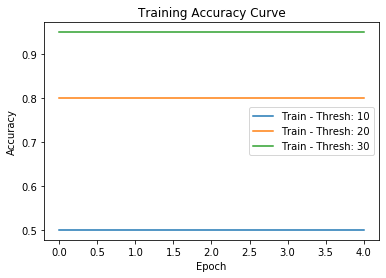

[EPOCH 6] loss: 0.002800  time: 0.445
[EPOCH 7] loss: 0.002791  time: 0.412
[EPOCH 8] loss: 0.002780  time: 0.423
[EPOCH 9] loss: 0.002768  time: 0.436
[EPOCH 10] loss: 0.002755  time: 0.417


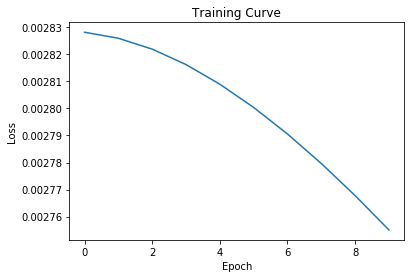

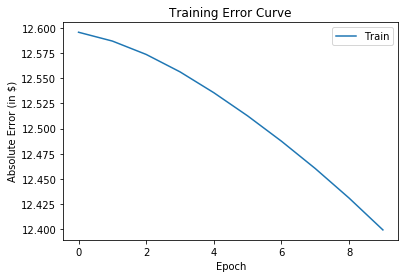

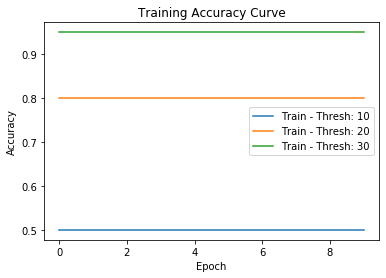

[EPOCH 11] loss: 0.002742  time: 0.447
[EPOCH 12] loss: 0.002727  time: 0.427
[EPOCH 13] loss: 0.002713  time: 0.413
[EPOCH 14] loss: 0.002697  time: 0.423
[EPOCH 15] loss: 0.002682  time: 0.411


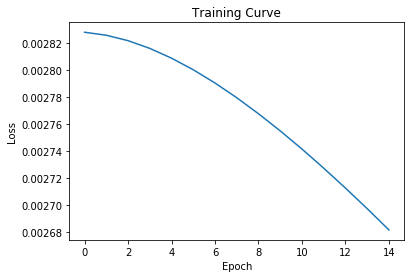

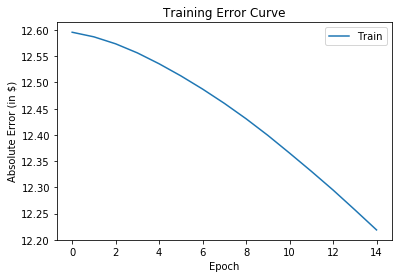

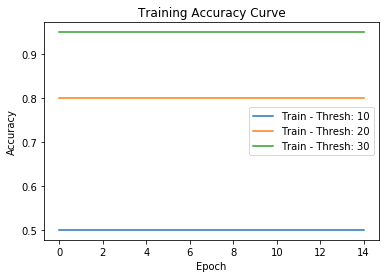

[EPOCH 16] loss: 0.002665  time: 0.424
[EPOCH 17] loss: 0.002649  time: 0.427
[EPOCH 18] loss: 0.002632  time: 0.413
[EPOCH 19] loss: 0.002615  time: 0.527
[EPOCH 20] loss: 0.002598  time: 0.534


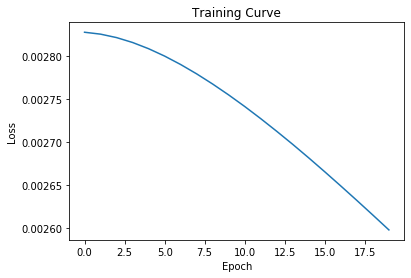

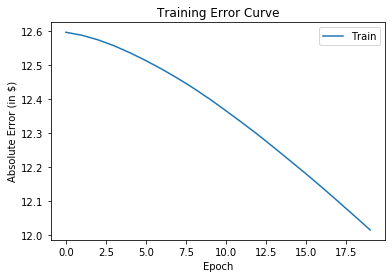

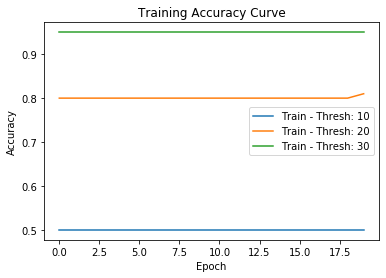

[EPOCH 21] loss: 0.002580  time: 0.421
[EPOCH 22] loss: 0.002563  time: 0.407
[EPOCH 23] loss: 0.002545  time: 0.396
[EPOCH 24] loss: 0.002527  time: 0.446
[EPOCH 25] loss: 0.002510  time: 0.416


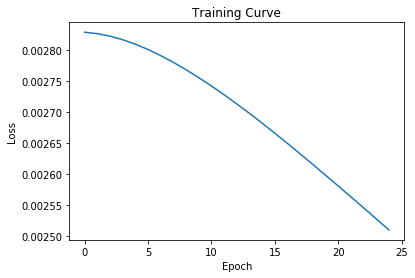

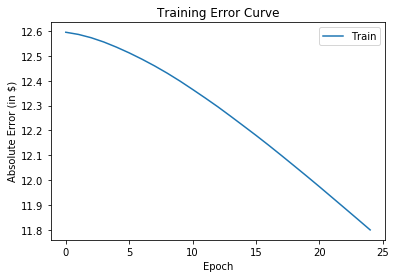

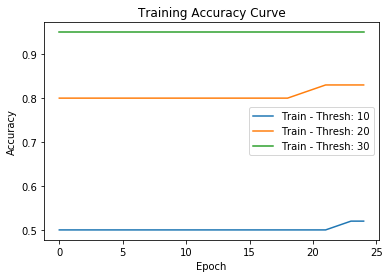

[EPOCH 26] loss: 0.002492  time: 0.411
[EPOCH 27] loss: 0.002474  time: 0.409
[EPOCH 28] loss: 0.002455  time: 0.439
[EPOCH 29] loss: 0.002437  time: 0.417
[EPOCH 30] loss: 0.002419  time: 0.415


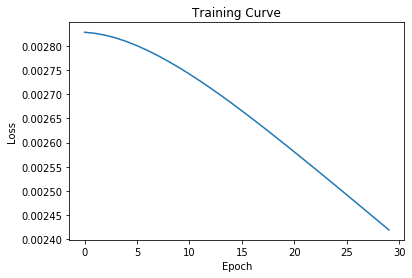

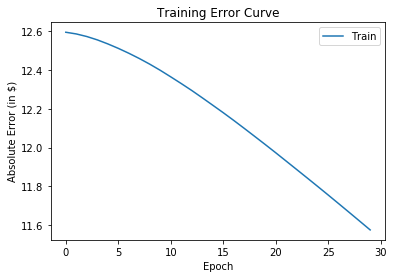

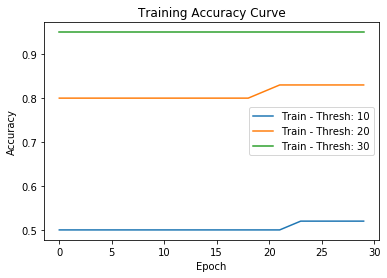

[EPOCH 31] loss: 0.002401  time: 0.409
[EPOCH 32] loss: 0.002383  time: 0.422
[EPOCH 33] loss: 0.002365  time: 0.409
[EPOCH 34] loss: 0.002347  time: 0.421
[EPOCH 35] loss: 0.002329  time: 0.410


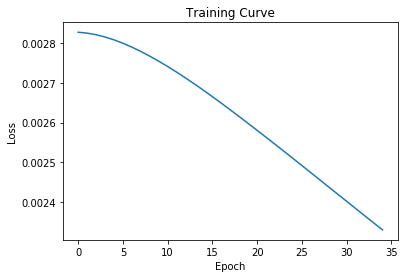

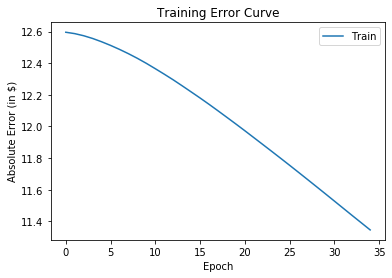

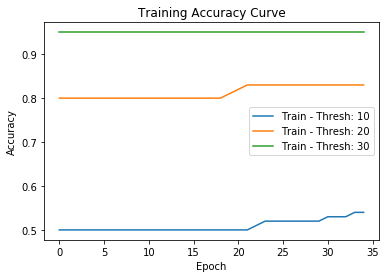

[EPOCH 36] loss: 0.002311  time: 0.407
[EPOCH 37] loss: 0.002294  time: 0.410
[EPOCH 38] loss: 0.002276  time: 0.422
[EPOCH 39] loss: 0.002258  time: 0.408
[EPOCH 40] loss: 0.002241  time: 0.421


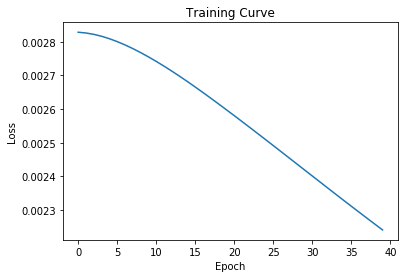

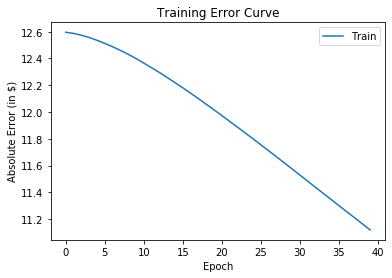

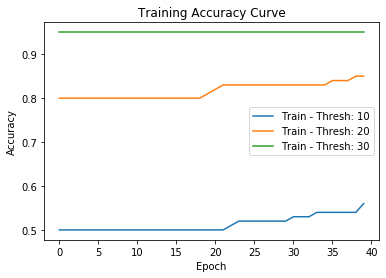

[EPOCH 41] loss: 0.002224  time: 0.461
[EPOCH 42] loss: 0.002206  time: 0.401
[EPOCH 43] loss: 0.002189  time: 0.398
[EPOCH 44] loss: 0.002172  time: 0.434
[EPOCH 45] loss: 0.002155  time: 0.407


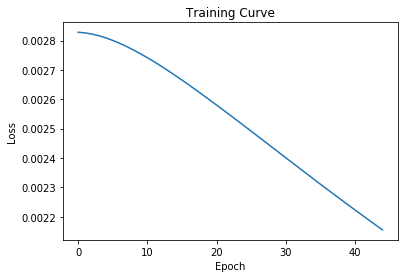

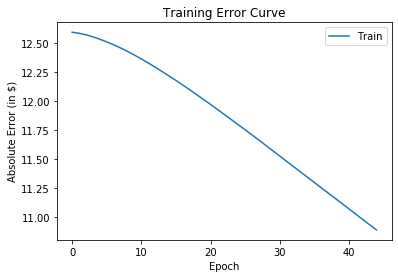

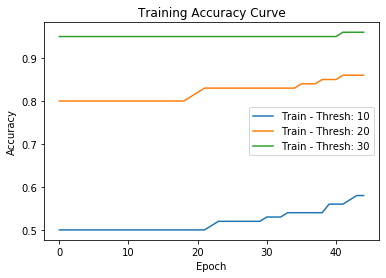

[EPOCH 46] loss: 0.002138  time: 0.407
[EPOCH 47] loss: 0.002122  time: 0.407
[EPOCH 48] loss: 0.002105  time: 0.426
[EPOCH 49] loss: 0.002088  time: 0.403
[EPOCH 50] loss: 0.002072  time: 0.413


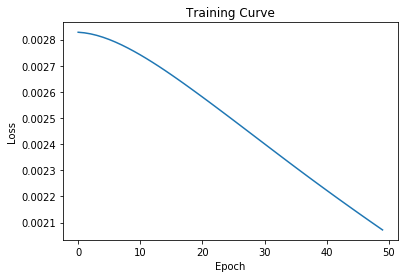

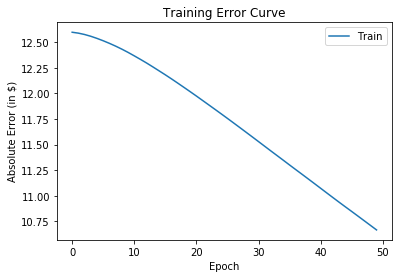

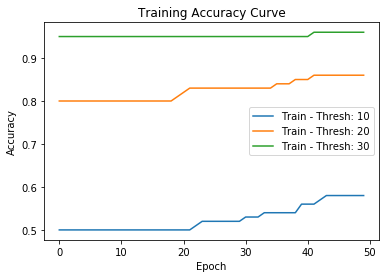

[EPOCH 51] loss: 0.002056  time: 0.402
[EPOCH 52] loss: 0.002040  time: 0.421
[EPOCH 53] loss: 0.002023  time: 0.410
[EPOCH 54] loss: 0.002007  time: 0.403
[EPOCH 55] loss: 0.001992  time: 0.405


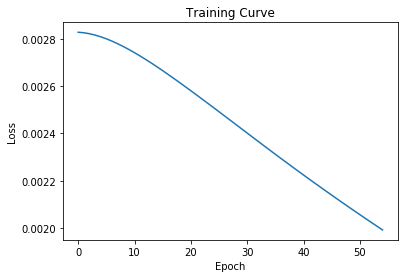

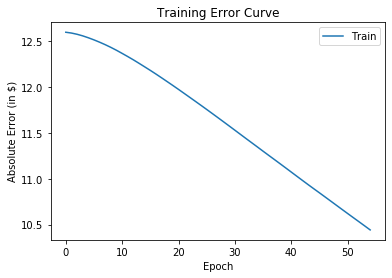

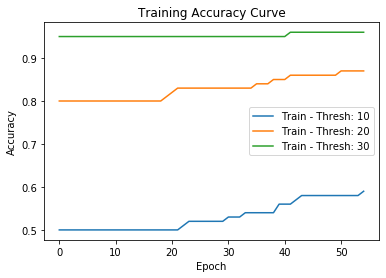

[EPOCH 56] loss: 0.001976  time: 0.405
[EPOCH 57] loss: 0.001960  time: 0.412
[EPOCH 58] loss: 0.001944  time: 0.416
[EPOCH 59] loss: 0.001929  time: 0.402
[EPOCH 60] loss: 0.001914  time: 0.400


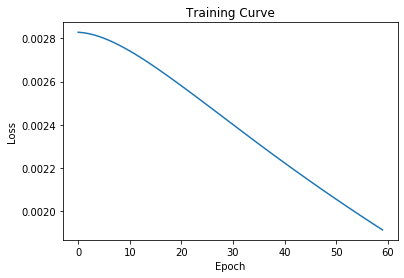

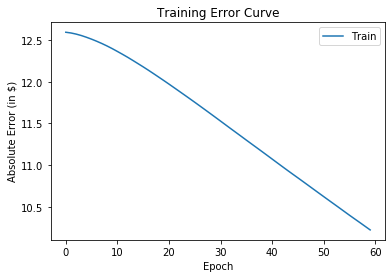

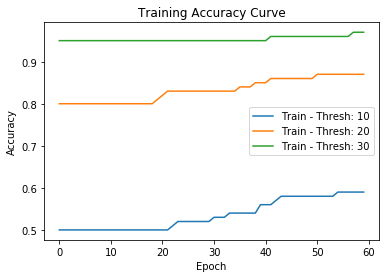

[EPOCH 61] loss: 0.001898  time: 0.413
[EPOCH 62] loss: 0.001883  time: 0.418
[EPOCH 63] loss: 0.001868  time: 0.412
[EPOCH 64] loss: 0.001853  time: 0.420
[EPOCH 65] loss: 0.001838  time: 0.420


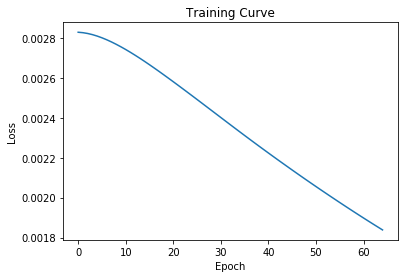

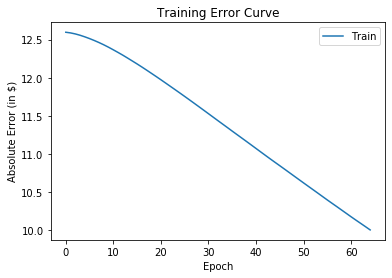

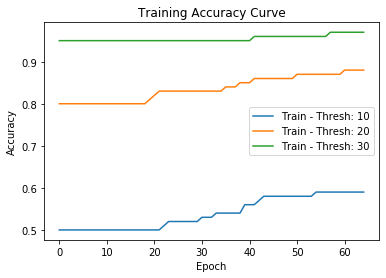

[EPOCH 66] loss: 0.001824  time: 0.412
[EPOCH 67] loss: 0.001809  time: 0.404
[EPOCH 68] loss: 0.001795  time: 0.435
[EPOCH 69] loss: 0.001780  time: 0.409
[EPOCH 70] loss: 0.001766  time: 0.414


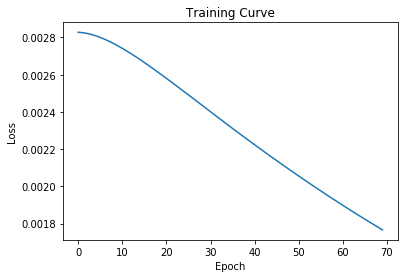

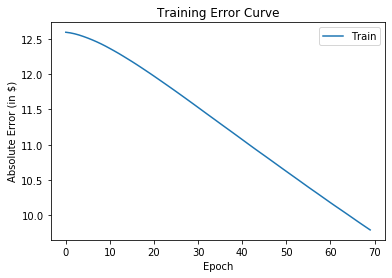

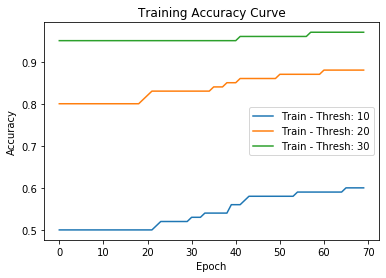

[EPOCH 71] loss: 0.001752  time: 0.407
[EPOCH 72] loss: 0.001738  time: 0.425
[EPOCH 73] loss: 0.001724  time: 0.416
[EPOCH 74] loss: 0.001710  time: 0.413
[EPOCH 75] loss: 0.001696  time: 0.398


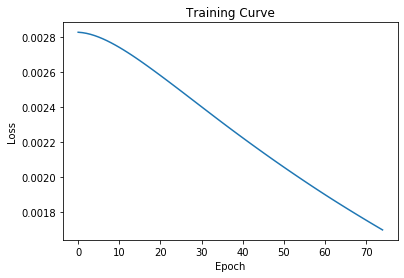

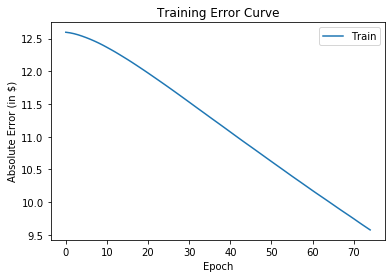

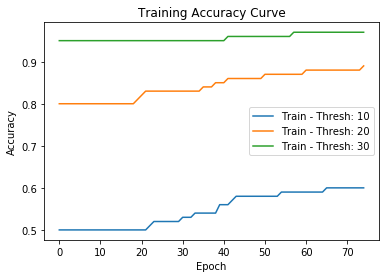

[EPOCH 76] loss: 0.001682  time: 0.418
[EPOCH 77] loss: 0.001669  time: 0.413
[EPOCH 78] loss: 0.001655  time: 0.415
[EPOCH 79] loss: 0.001642  time: 0.412
[EPOCH 80] loss: 0.001629  time: 0.412


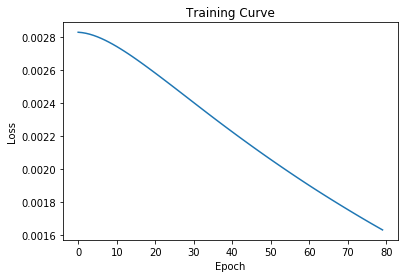

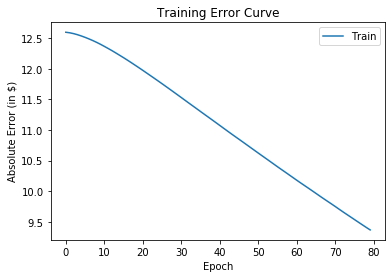

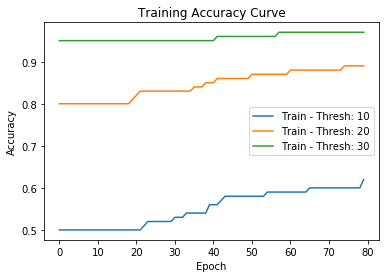

[EPOCH 81] loss: 0.001616  time: 0.411
[EPOCH 82] loss: 0.001603  time: 0.418
[EPOCH 83] loss: 0.001590  time: 0.406
[EPOCH 84] loss: 0.001577  time: 0.404
[EPOCH 85] loss: 0.001564  time: 0.430


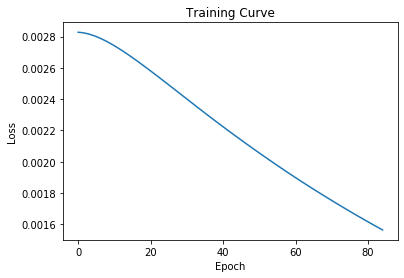

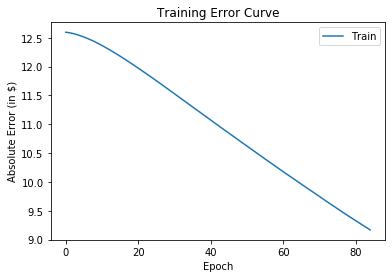

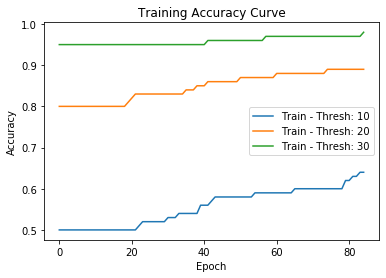

[EPOCH 86] loss: 0.001551  time: 0.408
[EPOCH 87] loss: 0.001539  time: 0.414
[EPOCH 88] loss: 0.001526  time: 0.407
[EPOCH 89] loss: 0.001514  time: 0.410
[EPOCH 90] loss: 0.001502  time: 0.410


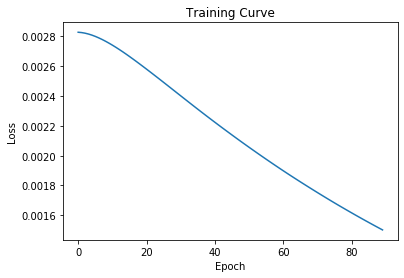

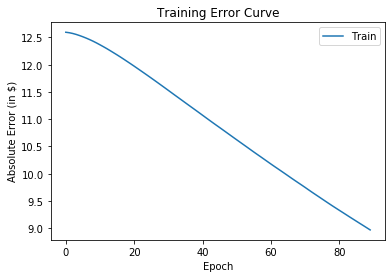

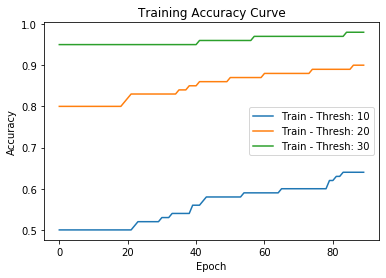

[EPOCH 91] loss: 0.001490  time: 0.409
[EPOCH 92] loss: 0.001477  time: 0.449
[EPOCH 93] loss: 0.001465  time: 0.407
[EPOCH 94] loss: 0.001454  time: 0.405
[EPOCH 95] loss: 0.001442  time: 0.417


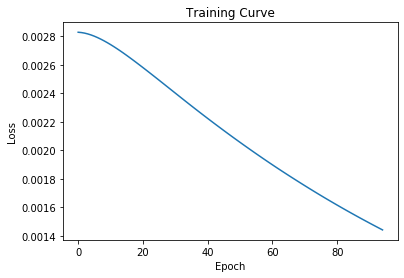

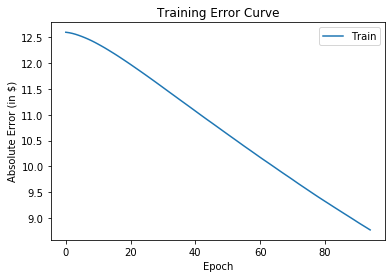

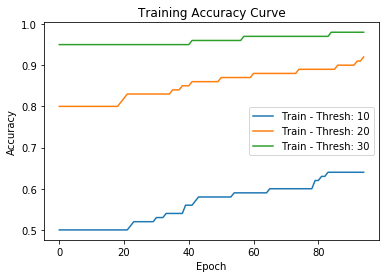

[EPOCH 96] loss: 0.001430  time: 0.431
[EPOCH 97] loss: 0.001418  time: 0.413
[EPOCH 98] loss: 0.001407  time: 0.408
[EPOCH 99] loss: 0.001395  time: 0.420
[EPOCH 100] loss: 0.001384  time: 0.400


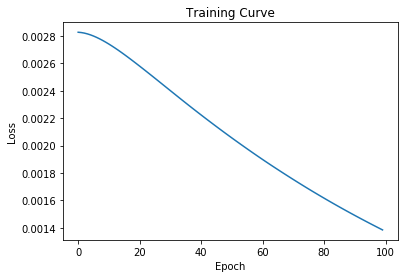

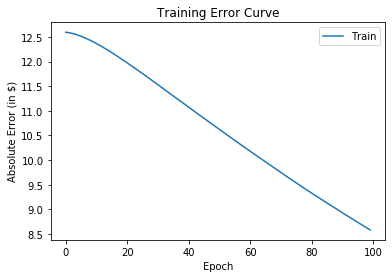

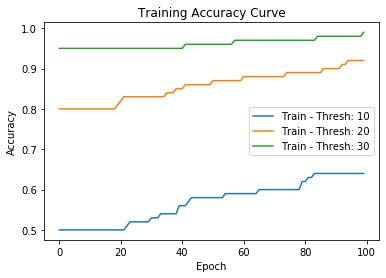

[EPOCH 101] loss: 0.001373  time: 0.405
[EPOCH 102] loss: 0.001361  time: 0.407
[EPOCH 103] loss: 0.001350  time: 0.417
[EPOCH 104] loss: 0.001339  time: 0.518
[EPOCH 105] loss: 0.001328  time: 0.483


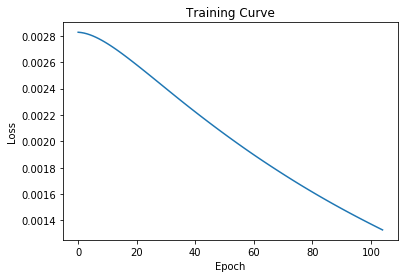

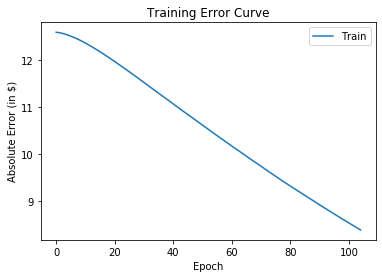

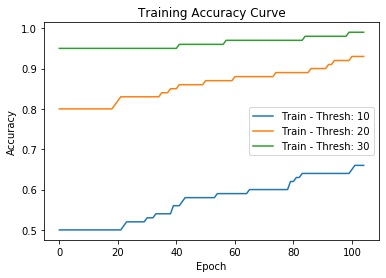

[EPOCH 106] loss: 0.001317  time: 0.420
[EPOCH 107] loss: 0.001306  time: 0.411
[EPOCH 108] loss: 0.001295  time: 0.429
[EPOCH 109] loss: 0.001285  time: 0.423
[EPOCH 110] loss: 0.001274  time: 0.399


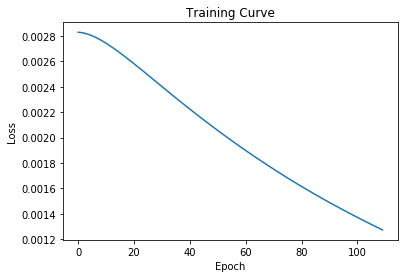

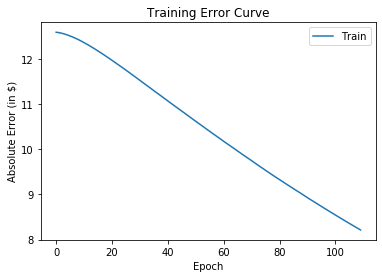

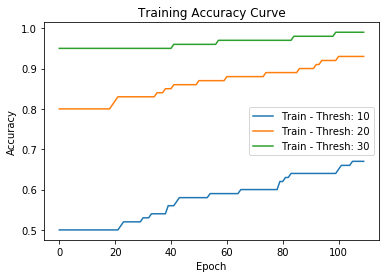

[EPOCH 111] loss: 0.001263  time: 0.401
[EPOCH 112] loss: 0.001253  time: 0.429
[EPOCH 113] loss: 0.001242  time: 0.413
[EPOCH 114] loss: 0.001232  time: 0.400
[EPOCH 115] loss: 0.001222  time: 0.417


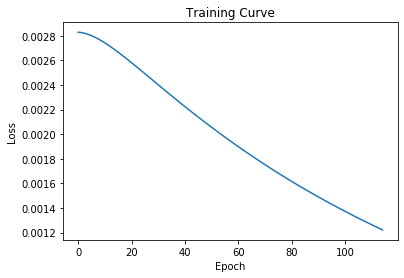

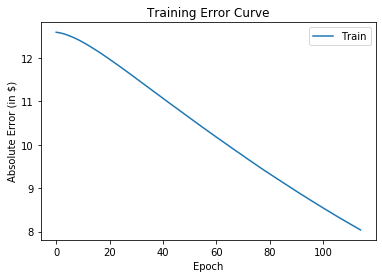

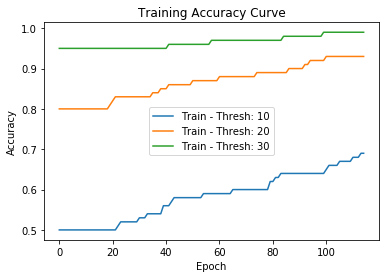

[EPOCH 116] loss: 0.001212  time: 0.423
[EPOCH 117] loss: 0.001202  time: 0.409
[EPOCH 118] loss: 0.001192  time: 0.416
[EPOCH 119] loss: 0.001182  time: 0.410
[EPOCH 120] loss: 0.001172  time: 0.423


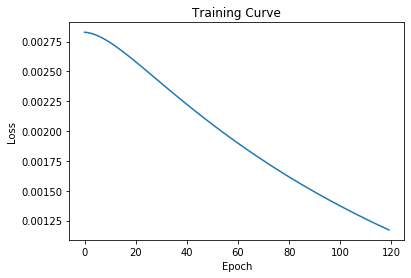

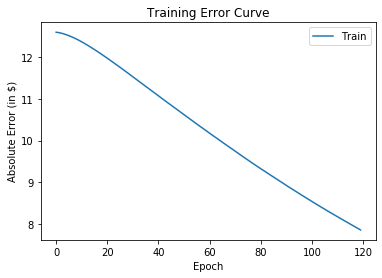

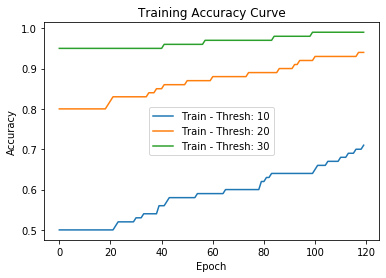

[EPOCH 121] loss: 0.001162  time: 0.426
[EPOCH 122] loss: 0.001153  time: 0.451
[EPOCH 123] loss: 0.001143  time: 0.416
[EPOCH 124] loss: 0.001134  time: 0.423
[EPOCH 125] loss: 0.001124  time: 0.445


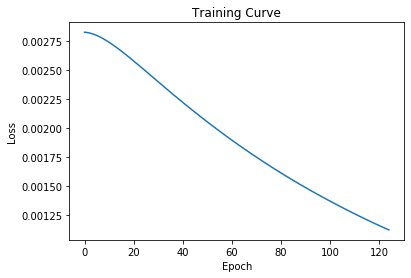

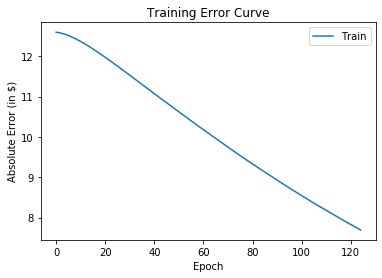

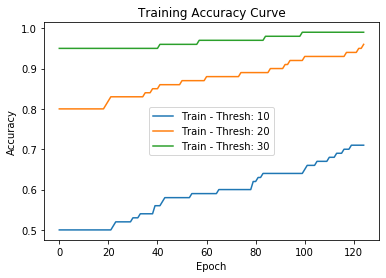

[EPOCH 126] loss: 0.001115  time: 0.425
[EPOCH 127] loss: 0.001106  time: 0.418
[EPOCH 128] loss: 0.001096  time: 0.401
[EPOCH 129] loss: 0.001087  time: 0.424
[EPOCH 130] loss: 0.001078  time: 0.415


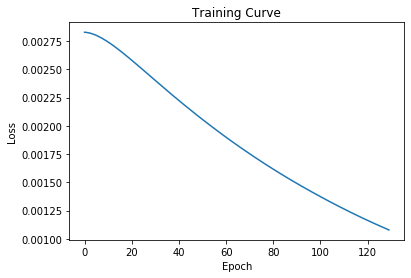

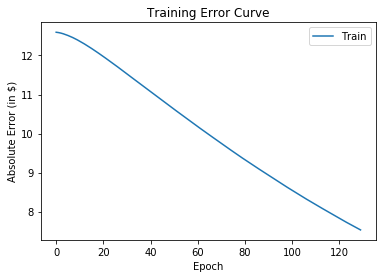

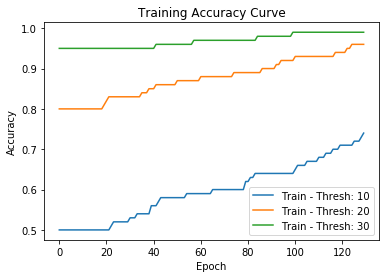

[EPOCH 131] loss: 0.001069  time: 0.407
[EPOCH 132] loss: 0.001060  time: 0.441
[EPOCH 133] loss: 0.001052  time: 0.406
[EPOCH 134] loss: 0.001043  time: 0.404
[EPOCH 135] loss: 0.001034  time: 0.462


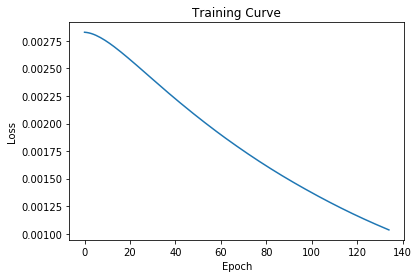

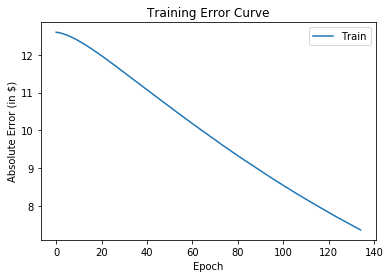

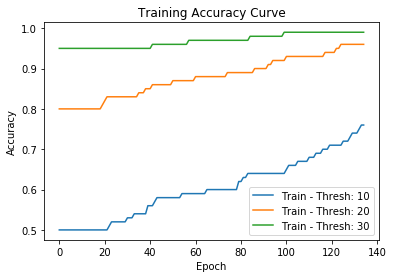

[EPOCH 136] loss: 0.001026  time: 0.421
[EPOCH 137] loss: 0.001017  time: 0.421
[EPOCH 138] loss: 0.001009  time: 0.446
[EPOCH 139] loss: 0.001000  time: 0.408
[EPOCH 140] loss: 0.000992  time: 0.438


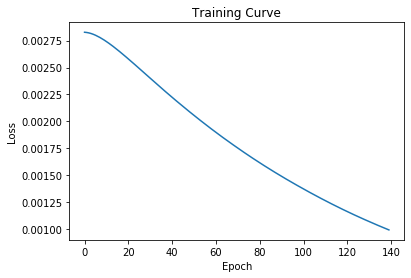

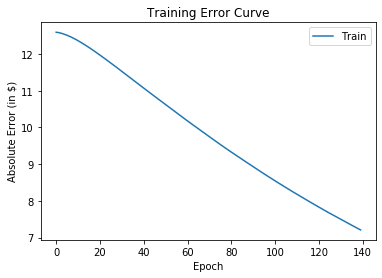

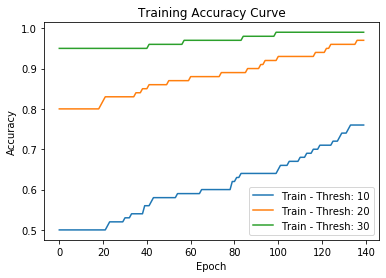

[EPOCH 141] loss: 0.000984  time: 0.513
[EPOCH 142] loss: 0.000976  time: 0.440
[EPOCH 143] loss: 0.000968  time: 0.431
[EPOCH 144] loss: 0.000960  time: 0.426
[EPOCH 145] loss: 0.000952  time: 0.412


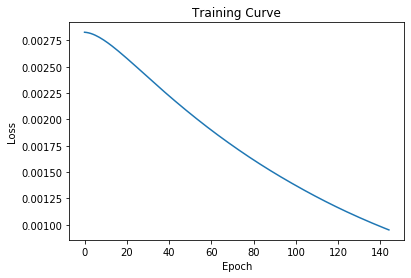

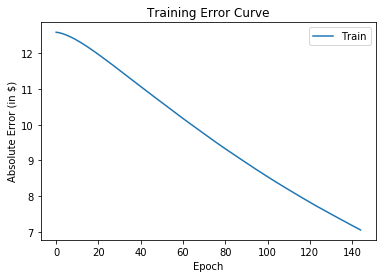

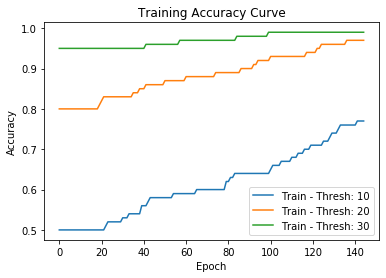

[EPOCH 146] loss: 0.000944  time: 0.406
[EPOCH 147] loss: 0.000936  time: 0.417
[EPOCH 148] loss: 0.000928  time: 0.424
[EPOCH 149] loss: 0.000920  time: 0.409
[EPOCH 150] loss: 0.000913  time: 0.447


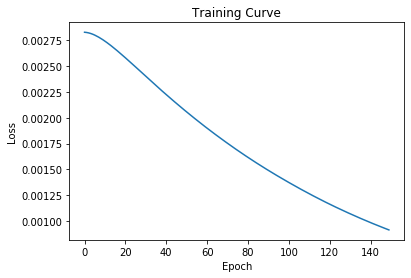

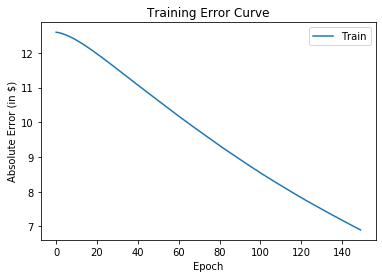

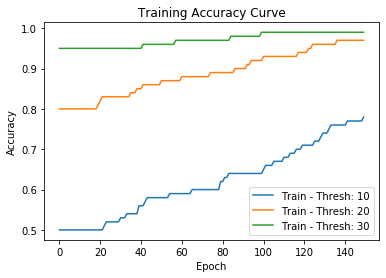

[EPOCH 151] loss: 0.000905  time: 0.418
[EPOCH 152] loss: 0.000898  time: 0.424
[EPOCH 153] loss: 0.000890  time: 0.409
[EPOCH 154] loss: 0.000883  time: 0.420
[EPOCH 155] loss: 0.000876  time: 0.417


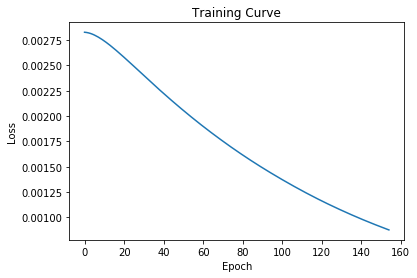

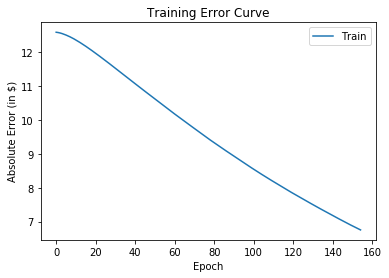

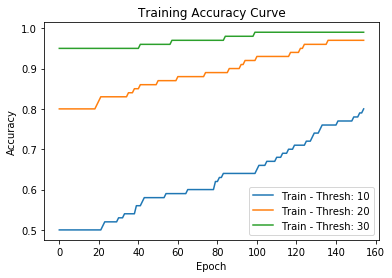

[EPOCH 156] loss: 0.000868  time: 0.411
[EPOCH 157] loss: 0.000861  time: 0.409
[EPOCH 158] loss: 0.000854  time: 0.414
[EPOCH 159] loss: 0.000847  time: 0.412
[EPOCH 160] loss: 0.000840  time: 0.422


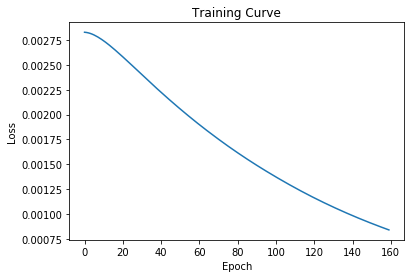

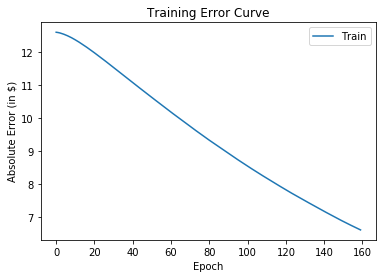

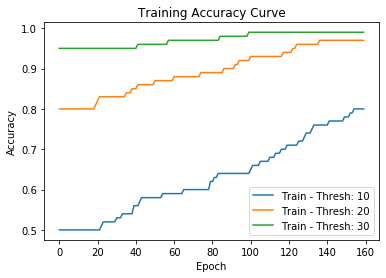

[EPOCH 161] loss: 0.000833  time: 0.401
[EPOCH 162] loss: 0.000826  time: 0.419
[EPOCH 163] loss: 0.000819  time: 0.406
[EPOCH 164] loss: 0.000813  time: 0.431
[EPOCH 165] loss: 0.000806  time: 0.404


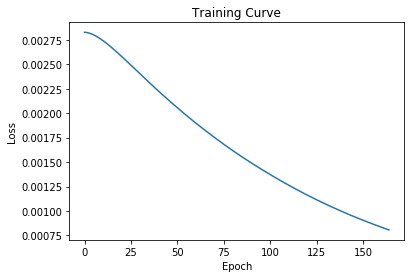

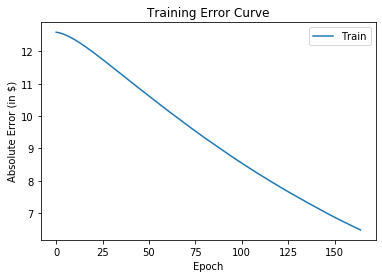

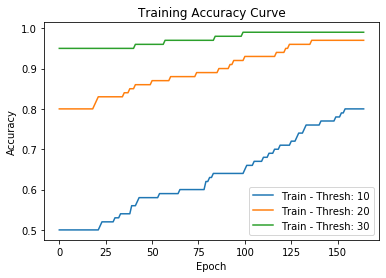

[EPOCH 166] loss: 0.000799  time: 0.399
[EPOCH 167] loss: 0.000793  time: 0.414
[EPOCH 168] loss: 0.000786  time: 0.423
[EPOCH 169] loss: 0.000780  time: 0.405
[EPOCH 170] loss: 0.000773  time: 0.415


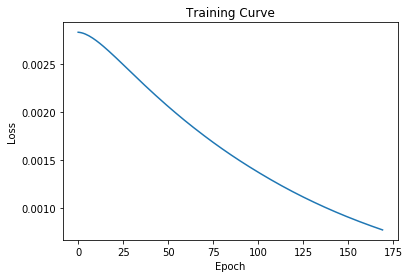

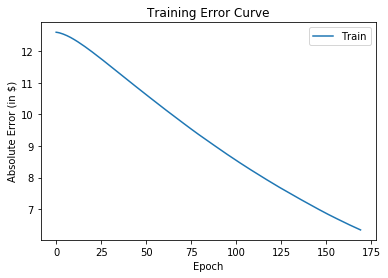

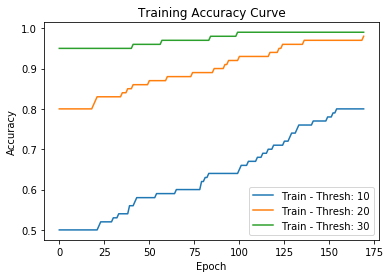

[EPOCH 171] loss: 0.000767  time: 0.409
[EPOCH 172] loss: 0.000760  time: 0.426
[EPOCH 173] loss: 0.000754  time: 0.409
[EPOCH 174] loss: 0.000748  time: 0.413
[EPOCH 175] loss: 0.000742  time: 0.408


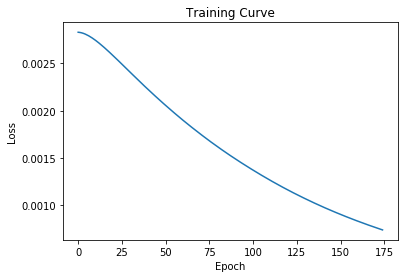

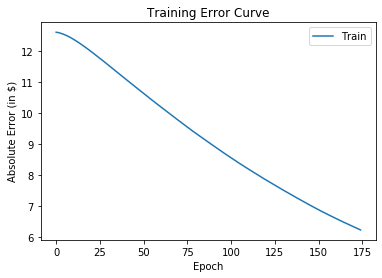

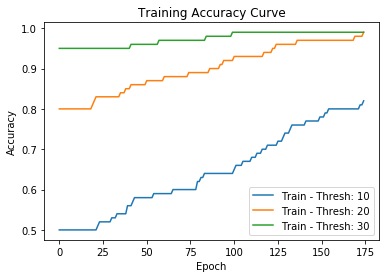

[EPOCH 176] loss: 0.000736  time: 0.430
[EPOCH 177] loss: 0.000729  time: 0.410
[EPOCH 178] loss: 0.000723  time: 0.416
[EPOCH 179] loss: 0.000717  time: 0.409
[EPOCH 180] loss: 0.000712  time: 0.403


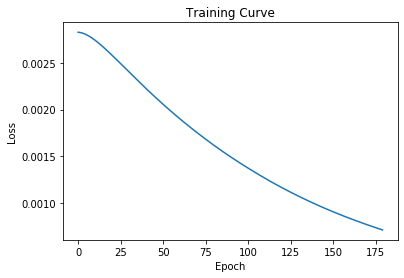

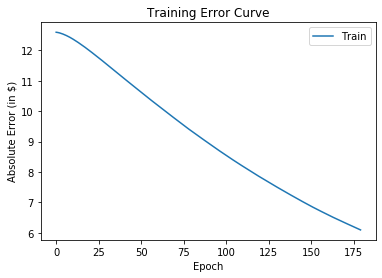

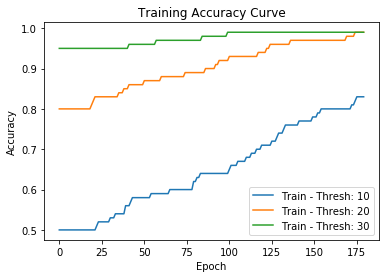

[EPOCH 181] loss: 0.000706  time: 0.412
[EPOCH 182] loss: 0.000700  time: 0.422
[EPOCH 183] loss: 0.000694  time: 0.408
[EPOCH 184] loss: 0.000688  time: 0.413
[EPOCH 185] loss: 0.000683  time: 0.422


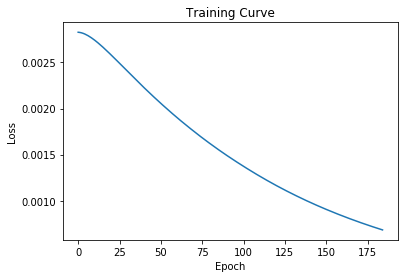

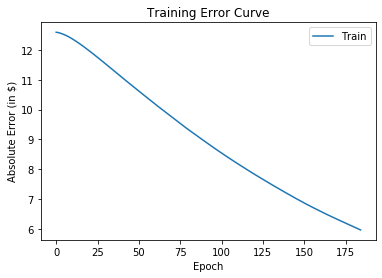

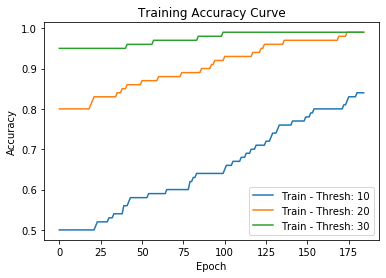

[EPOCH 186] loss: 0.000677  time: 0.417
[EPOCH 187] loss: 0.000671  time: 0.412
[EPOCH 188] loss: 0.000666  time: 0.424
[EPOCH 189] loss: 0.000661  time: 0.410
[EPOCH 190] loss: 0.000655  time: 0.440


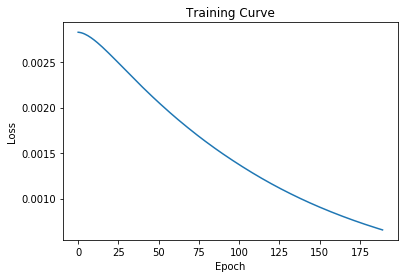

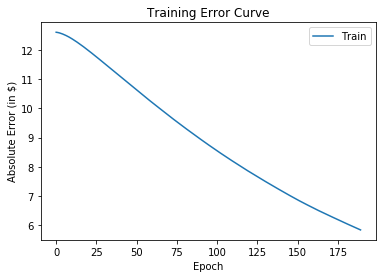

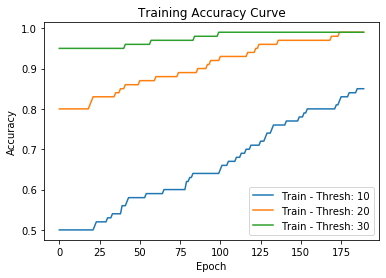

[EPOCH 191] loss: 0.000650  time: 0.413
[EPOCH 192] loss: 0.000644  time: 0.419
[EPOCH 193] loss: 0.000639  time: 0.414
[EPOCH 194] loss: 0.000634  time: 0.411
[EPOCH 195] loss: 0.000629  time: 0.423


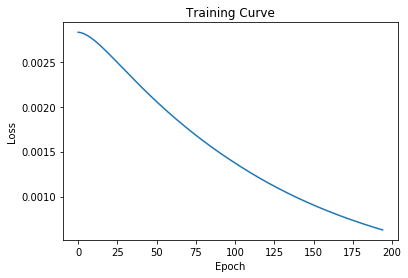

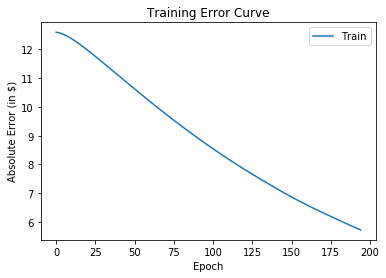

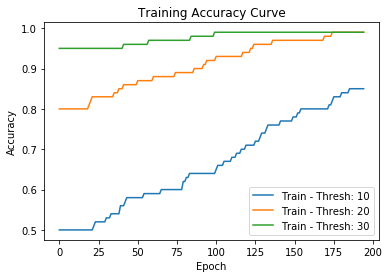

[EPOCH 196] loss: 0.000623  time: 0.423
[EPOCH 197] loss: 0.000618  time: 0.411
[EPOCH 198] loss: 0.000613  time: 0.410
[EPOCH 199] loss: 0.000608  time: 0.407
[EPOCH 200] loss: 0.000603  time: 0.410


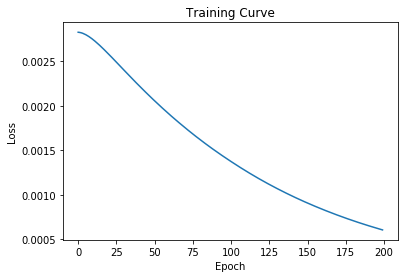

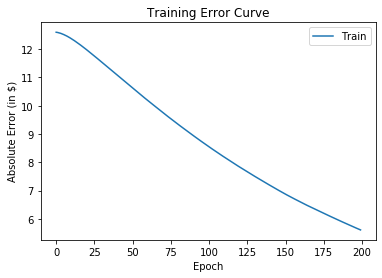

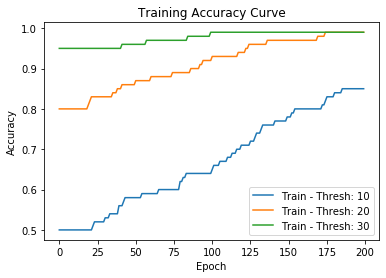

Training Completed...
[FINAL] loss: 0.000603  time: 100.514


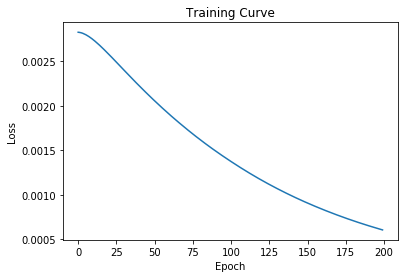

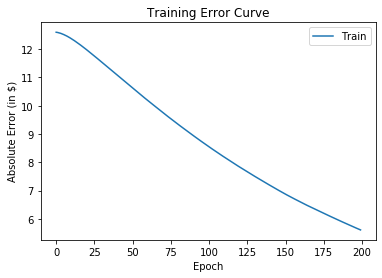

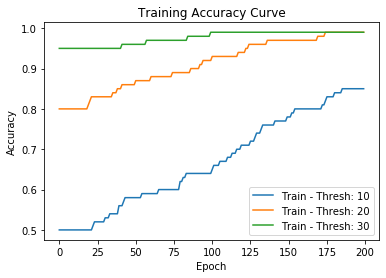

In [40]:
train(net, train_loader, val_loader, [minimum, maximum])

Starting Training...
[EPOCH 1] loss: 0.000598  time: 0.472
[EPOCH 2] loss: 0.000598  time: 0.446
[EPOCH 3] loss: 0.000597  time: 0.472
[EPOCH 4] loss: 0.000596  time: 0.420
[EPOCH 5] loss: 0.000594  time: 0.418


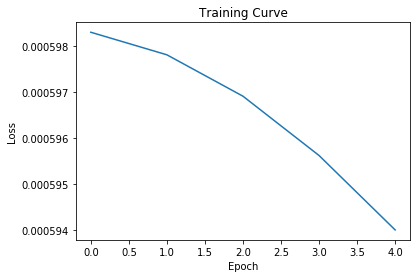

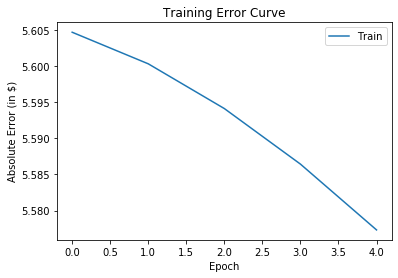

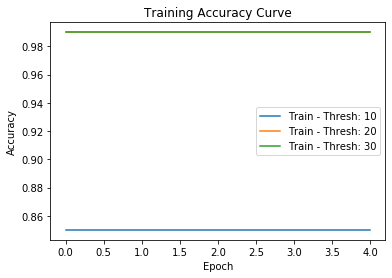

[EPOCH 6] loss: 0.000592  time: 0.422
[EPOCH 7] loss: 0.000590  time: 0.427
[EPOCH 8] loss: 0.000587  time: 0.419
[EPOCH 9] loss: 0.000585  time: 0.413
[EPOCH 10] loss: 0.000582  time: 0.521


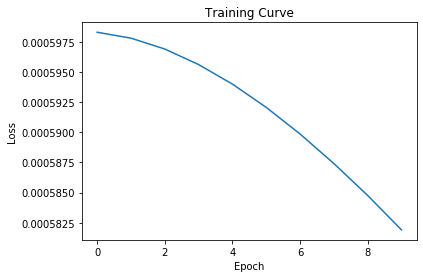

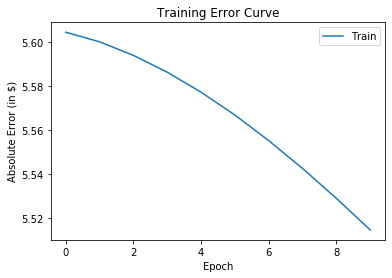

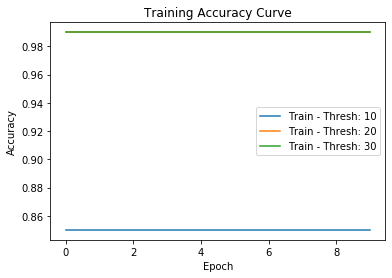

[EPOCH 11] loss: 0.000579  time: 0.488
[EPOCH 12] loss: 0.000576  time: 0.428
[EPOCH 13] loss: 0.000572  time: 0.482
[EPOCH 14] loss: 0.000569  time: 0.430
[EPOCH 15] loss: 0.000565  time: 0.471


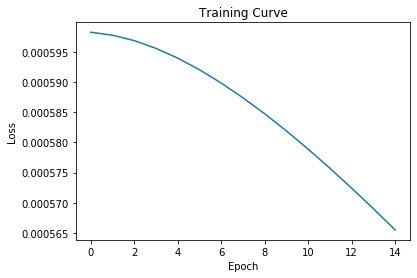

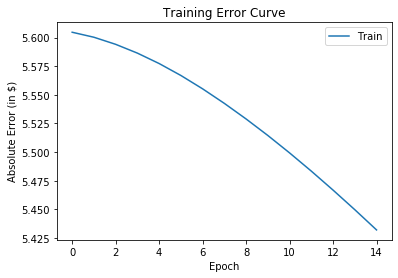

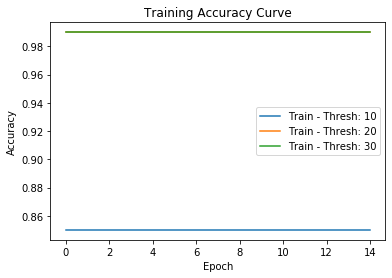

[EPOCH 16] loss: 0.000562  time: 0.420
[EPOCH 17] loss: 0.000558  time: 0.418
[EPOCH 18] loss: 0.000554  time: 0.407
[EPOCH 19] loss: 0.000551  time: 0.447
[EPOCH 20] loss: 0.000547  time: 0.417


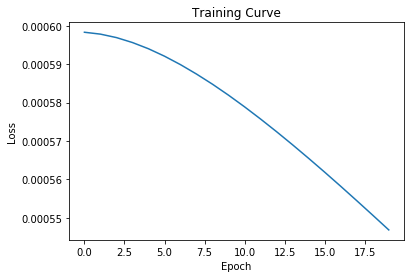

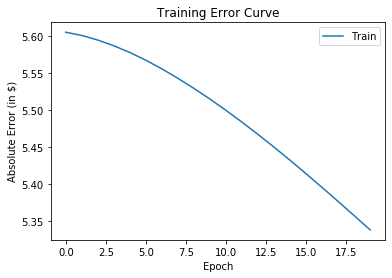

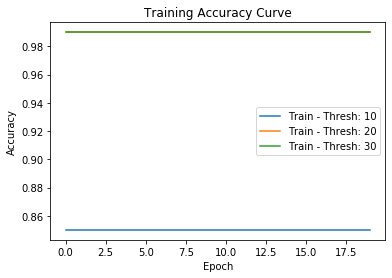

[EPOCH 21] loss: 0.000543  time: 0.413
[EPOCH 22] loss: 0.000539  time: 0.435
[EPOCH 23] loss: 0.000535  time: 0.414
[EPOCH 24] loss: 0.000531  time: 0.444
[EPOCH 25] loss: 0.000527  time: 0.428


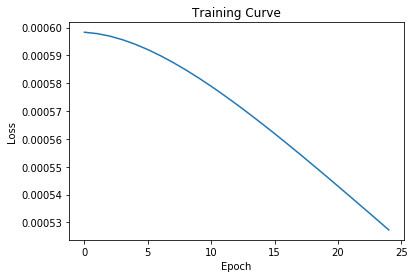

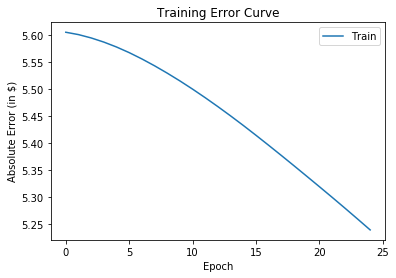

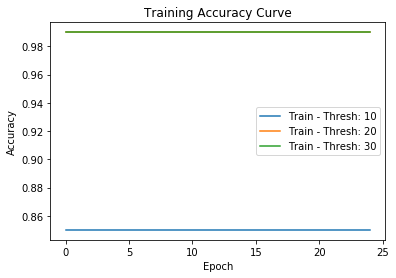

[EPOCH 26] loss: 0.000523  time: 0.424
[EPOCH 27] loss: 0.000519  time: 0.438
[EPOCH 28] loss: 0.000515  time: 0.427
[EPOCH 29] loss: 0.000512  time: 0.410
[EPOCH 30] loss: 0.000508  time: 0.408


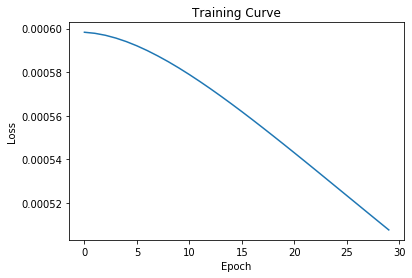

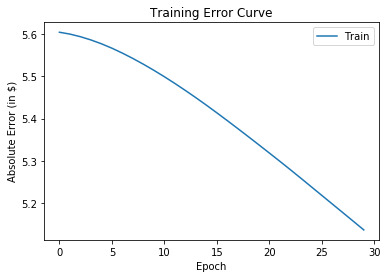

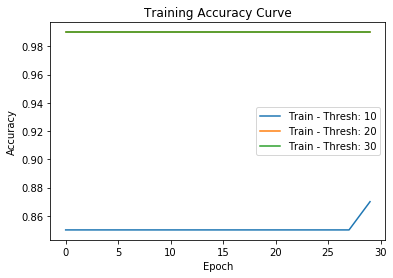

[EPOCH 31] loss: 0.000504  time: 0.430
[EPOCH 32] loss: 0.000500  time: 0.529
[EPOCH 33] loss: 0.000496  time: 0.530
[EPOCH 34] loss: 0.000492  time: 0.468
[EPOCH 35] loss: 0.000488  time: 0.403


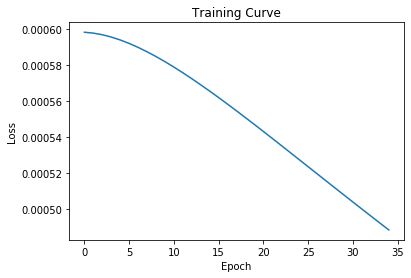

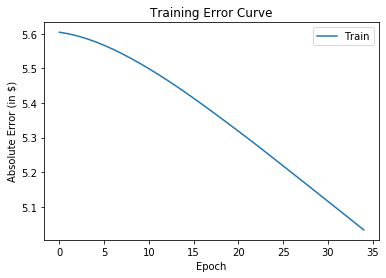

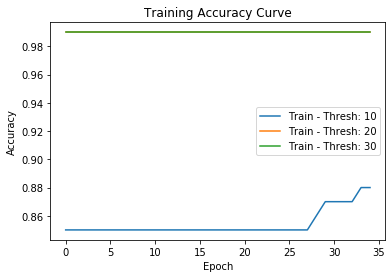

[EPOCH 36] loss: 0.000484  time: 0.405
[EPOCH 37] loss: 0.000481  time: 0.411
[EPOCH 38] loss: 0.000477  time: 0.422
[EPOCH 39] loss: 0.000473  time: 0.411
[EPOCH 40] loss: 0.000469  time: 0.433


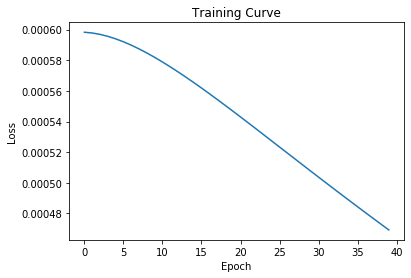

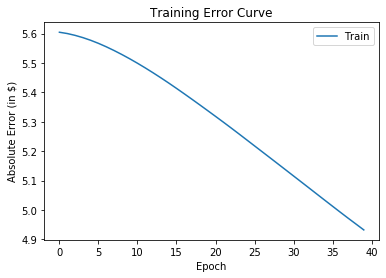

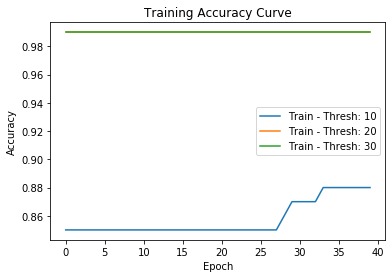

[EPOCH 41] loss: 0.000465  time: 0.420
[EPOCH 42] loss: 0.000462  time: 0.420
[EPOCH 43] loss: 0.000458  time: 0.409
[EPOCH 44] loss: 0.000454  time: 0.424
[EPOCH 45] loss: 0.000451  time: 0.410


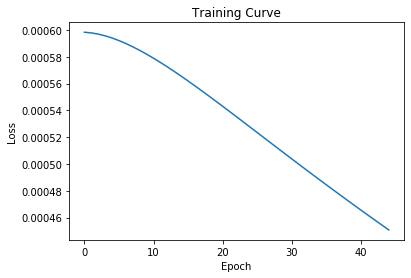

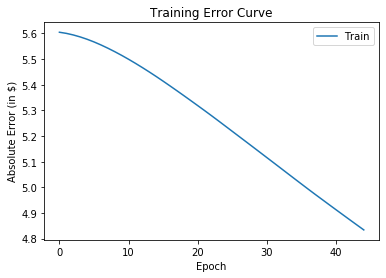

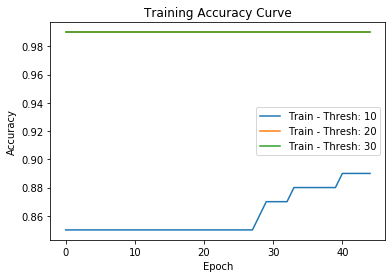

[EPOCH 46] loss: 0.000447  time: 0.409
[EPOCH 47] loss: 0.000444  time: 0.435
[EPOCH 48] loss: 0.000440  time: 0.443
[EPOCH 49] loss: 0.000437  time: 0.407
[EPOCH 50] loss: 0.000433  time: 0.413


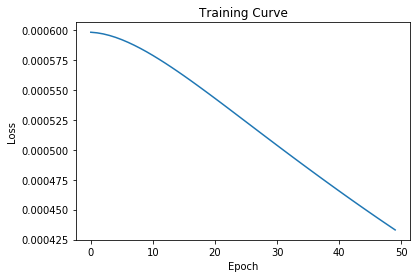

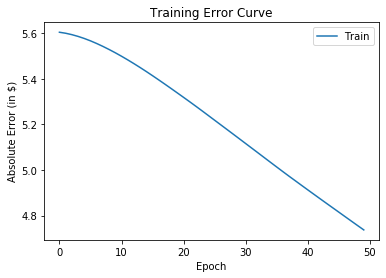

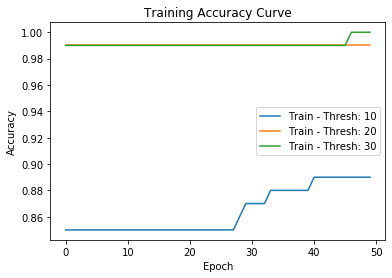

[EPOCH 51] loss: 0.000430  time: 0.402
[EPOCH 52] loss: 0.000426  time: 0.429
[EPOCH 53] loss: 0.000423  time: 0.405
[EPOCH 54] loss: 0.000419  time: 0.419
[EPOCH 55] loss: 0.000416  time: 0.417


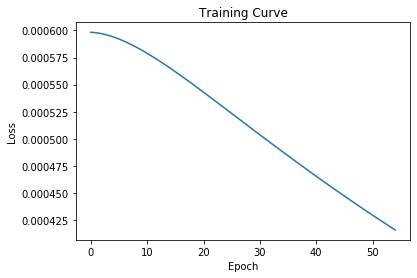

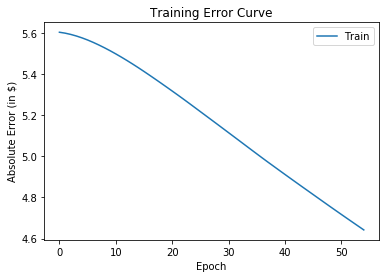

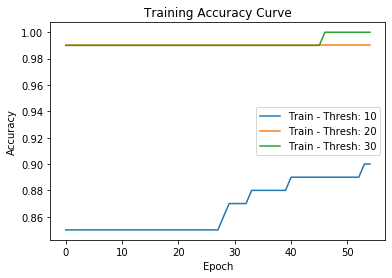

[EPOCH 56] loss: 0.000413  time: 0.419
[EPOCH 57] loss: 0.000409  time: 0.411
[EPOCH 58] loss: 0.000406  time: 0.421
[EPOCH 59] loss: 0.000403  time: 0.409
[EPOCH 60] loss: 0.000400  time: 0.430


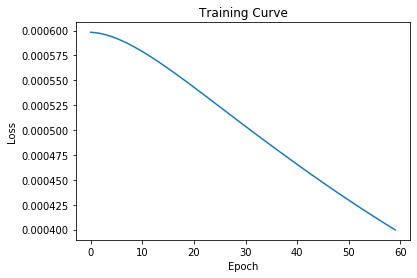

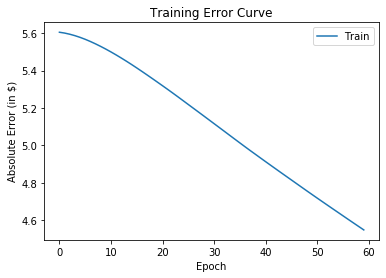

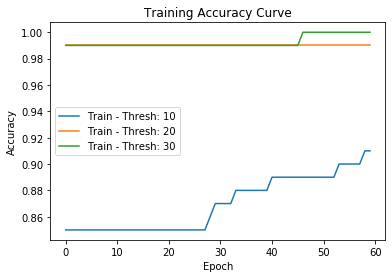

[EPOCH 61] loss: 0.000396  time: 0.408
[EPOCH 62] loss: 0.000393  time: 0.410
[EPOCH 63] loss: 0.000390  time: 0.414
[EPOCH 64] loss: 0.000387  time: 0.414
[EPOCH 65] loss: 0.000384  time: 0.409


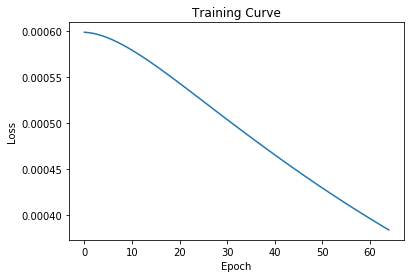

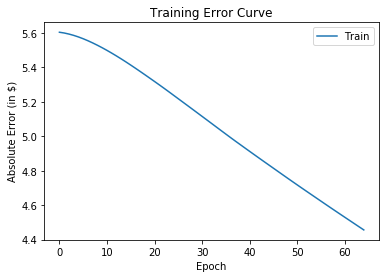

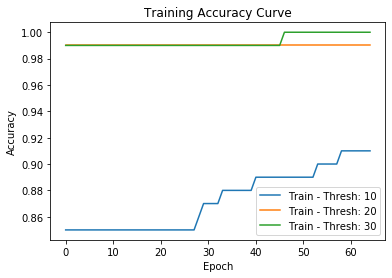

[EPOCH 66] loss: 0.000381  time: 0.413
[EPOCH 67] loss: 0.000378  time: 0.418
[EPOCH 68] loss: 0.000375  time: 0.430
[EPOCH 69] loss: 0.000372  time: 0.404
[EPOCH 70] loss: 0.000369  time: 0.425


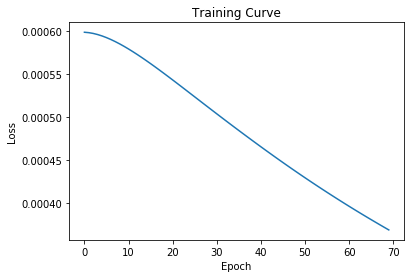

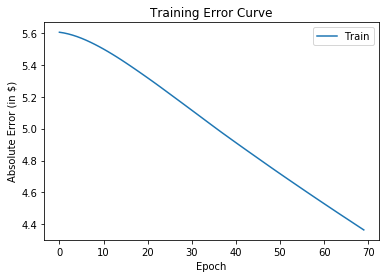

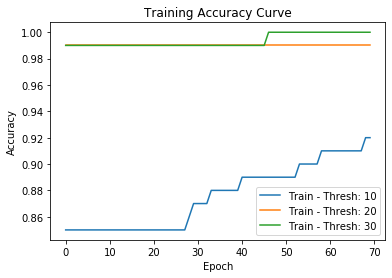

[EPOCH 71] loss: 0.000366  time: 0.411
[EPOCH 72] loss: 0.000363  time: 0.414
[EPOCH 73] loss: 0.000360  time: 0.408
[EPOCH 74] loss: 0.000357  time: 0.399
[EPOCH 75] loss: 0.000355  time: 0.425


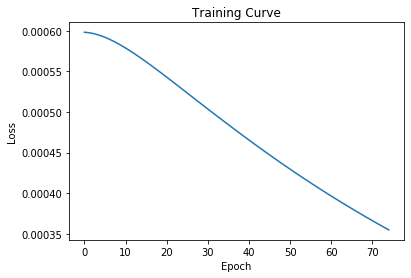

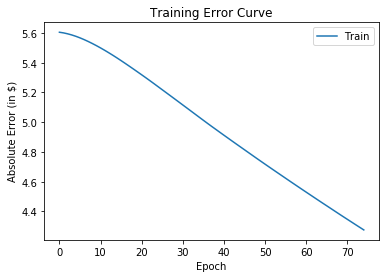

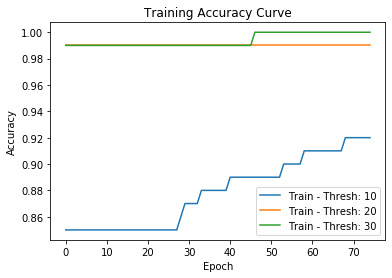

[EPOCH 76] loss: 0.000352  time: 0.422
[EPOCH 77] loss: 0.000349  time: 0.413
[EPOCH 78] loss: 0.000346  time: 0.410
[EPOCH 79] loss: 0.000344  time: 0.401
[EPOCH 80] loss: 0.000341  time: 0.414


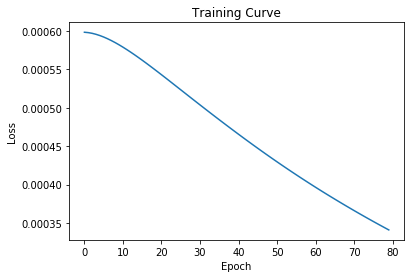

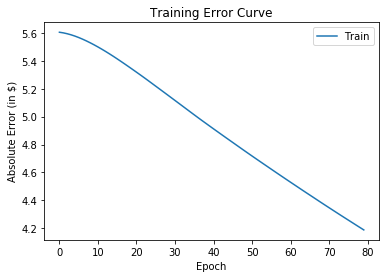

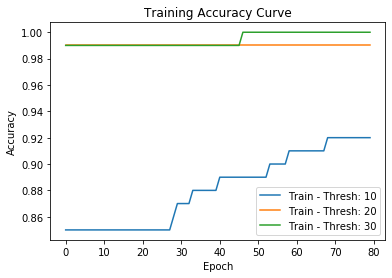

[EPOCH 81] loss: 0.000338  time: 0.407
[EPOCH 82] loss: 0.000336  time: 0.417
[EPOCH 83] loss: 0.000333  time: 0.412
[EPOCH 84] loss: 0.000330  time: 0.427
[EPOCH 85] loss: 0.000328  time: 0.400


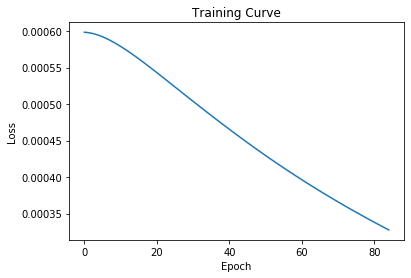

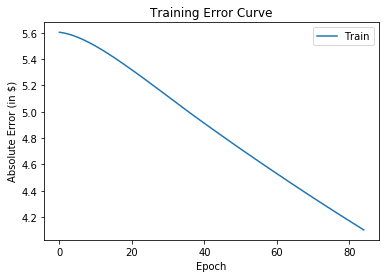

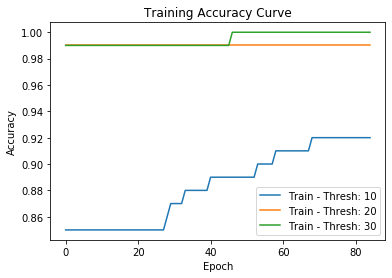

[EPOCH 86] loss: 0.000325  time: 0.451
[EPOCH 87] loss: 0.000323  time: 0.407
[EPOCH 88] loss: 0.000320  time: 0.433
[EPOCH 89] loss: 0.000318  time: 0.409
[EPOCH 90] loss: 0.000315  time: 0.417


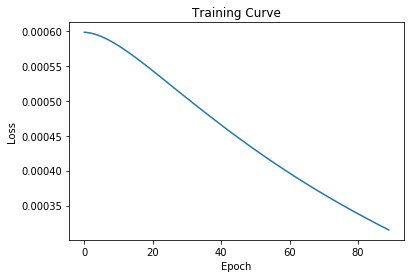

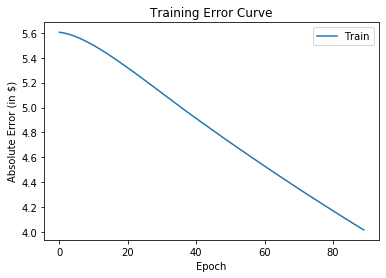

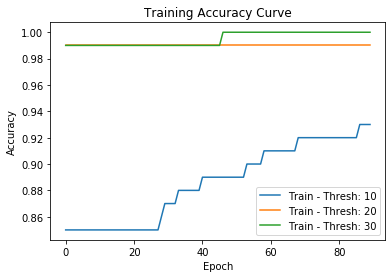

[EPOCH 91] loss: 0.000313  time: 0.409
[EPOCH 92] loss: 0.000310  time: 0.422
[EPOCH 93] loss: 0.000308  time: 0.409
[EPOCH 94] loss: 0.000305  time: 0.421
[EPOCH 95] loss: 0.000303  time: 0.411


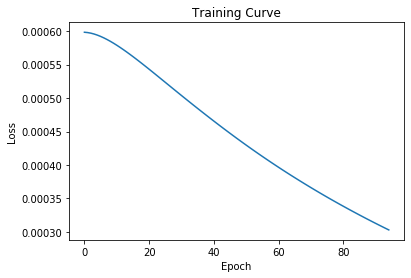

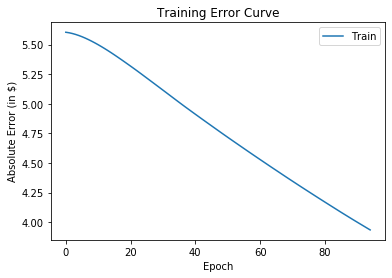

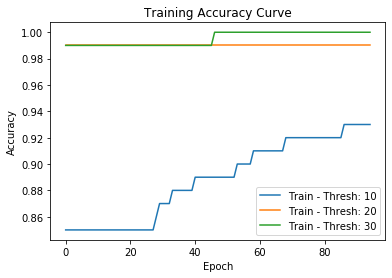

[EPOCH 96] loss: 0.000301  time: 0.414
[EPOCH 97] loss: 0.000298  time: 0.406
[EPOCH 98] loss: 0.000296  time: 0.420
[EPOCH 99] loss: 0.000294  time: 0.419
[EPOCH 100] loss: 0.000291  time: 0.412


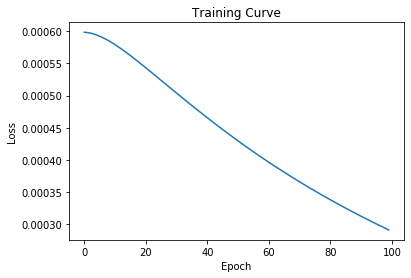

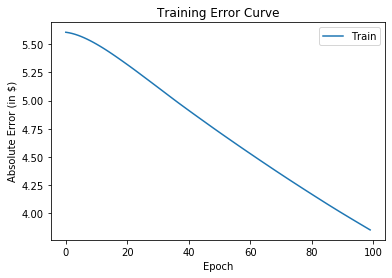

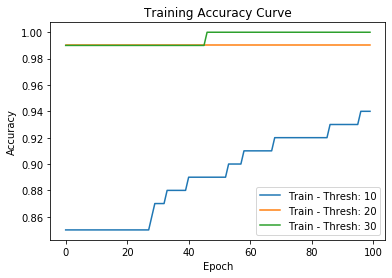

[EPOCH 101] loss: 0.000289  time: 0.406
[EPOCH 102] loss: 0.000287  time: 0.420
[EPOCH 103] loss: 0.000285  time: 0.408
[EPOCH 104] loss: 0.000283  time: 0.414
[EPOCH 105] loss: 0.000280  time: 0.431


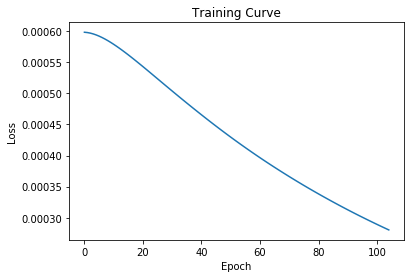

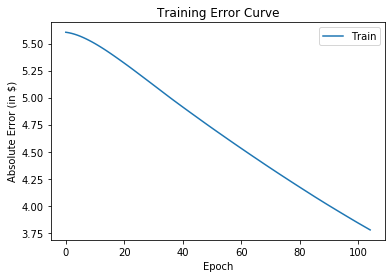

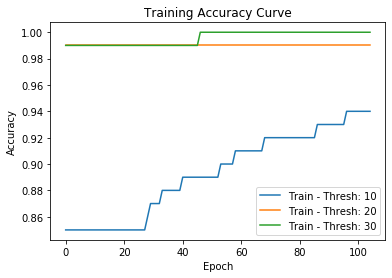

[EPOCH 106] loss: 0.000278  time: 0.406
[EPOCH 107] loss: 0.000276  time: 0.411
[EPOCH 108] loss: 0.000274  time: 0.429
[EPOCH 109] loss: 0.000272  time: 0.413
[EPOCH 110] loss: 0.000270  time: 0.399


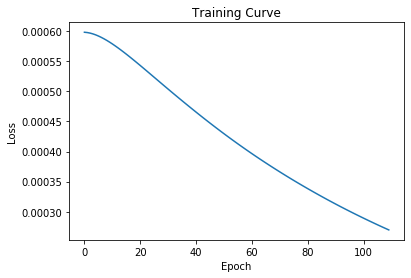

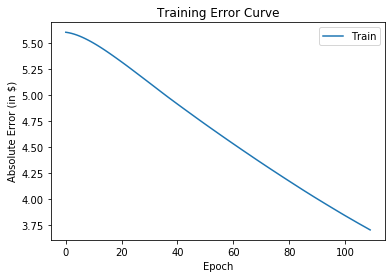

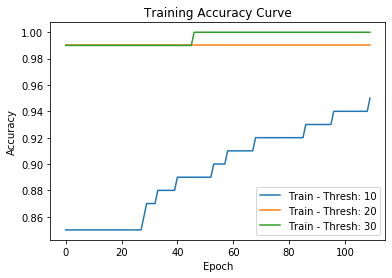

[EPOCH 111] loss: 0.000268  time: 0.417
[EPOCH 112] loss: 0.000266  time: 0.425
[EPOCH 113] loss: 0.000264  time: 0.408
[EPOCH 114] loss: 0.000262  time: 0.412
[EPOCH 115] loss: 0.000260  time: 0.406


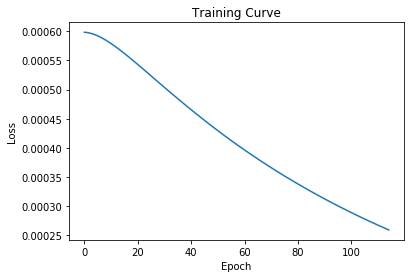

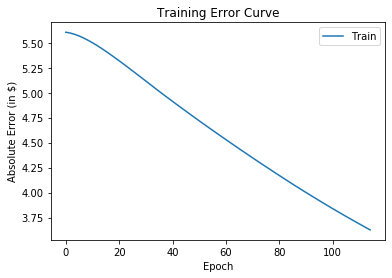

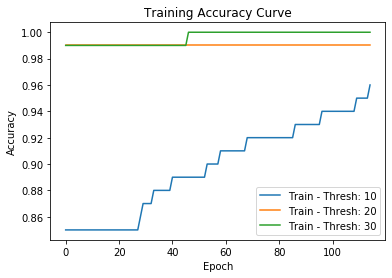

[EPOCH 116] loss: 0.000258  time: 0.428
[EPOCH 117] loss: 0.000256  time: 0.410
[EPOCH 118] loss: 0.000254  time: 0.413
[EPOCH 119] loss: 0.000252  time: 0.418
[EPOCH 120] loss: 0.000250  time: 0.411


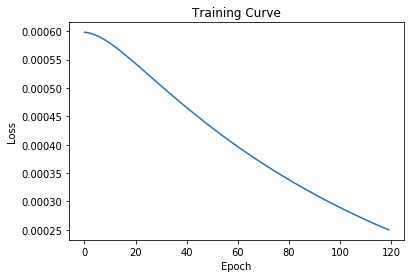

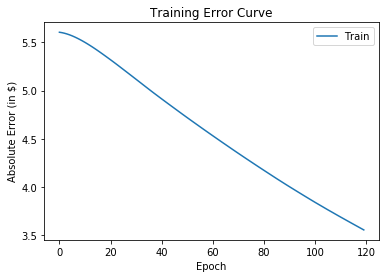

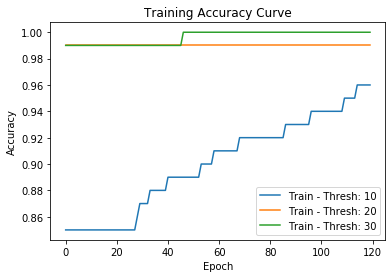

[EPOCH 121] loss: 0.000248  time: 0.403
[EPOCH 122] loss: 0.000246  time: 0.422
[EPOCH 123] loss: 0.000244  time: 0.412
[EPOCH 124] loss: 0.000242  time: 0.402
[EPOCH 125] loss: 0.000241  time: 0.423


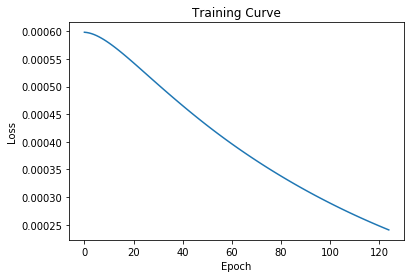

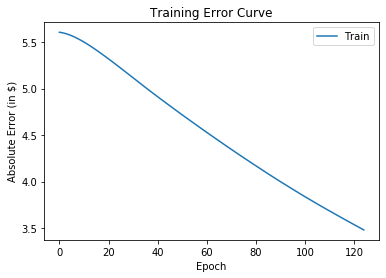

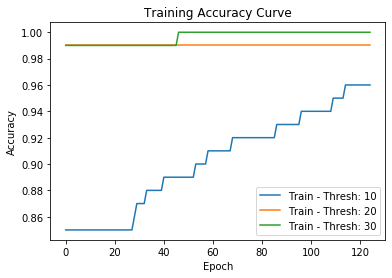

[EPOCH 126] loss: 0.000239  time: 0.429
[EPOCH 127] loss: 0.000237  time: 0.411
[EPOCH 128] loss: 0.000235  time: 0.409
[EPOCH 129] loss: 0.000233  time: 0.436
[EPOCH 130] loss: 0.000232  time: 0.409


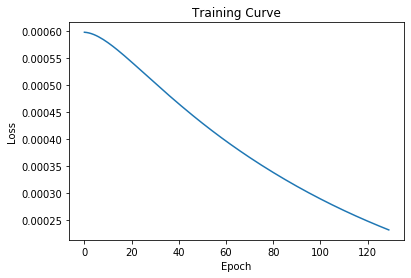

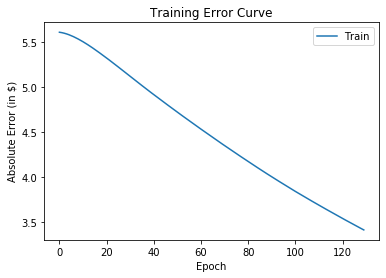

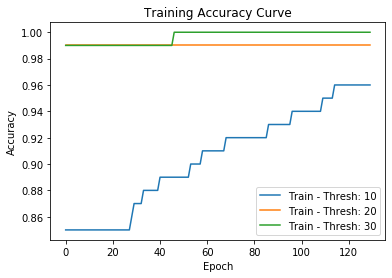

[EPOCH 131] loss: 0.000230  time: 0.416
[EPOCH 132] loss: 0.000228  time: 0.439
[EPOCH 133] loss: 0.000226  time: 0.443
[EPOCH 134] loss: 0.000225  time: 0.434
[EPOCH 135] loss: 0.000223  time: 0.418


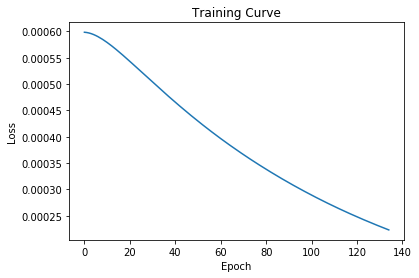

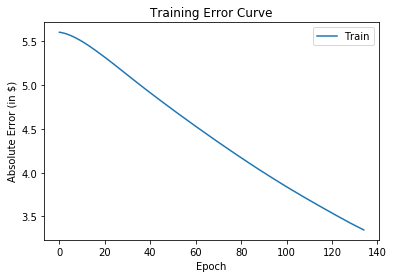

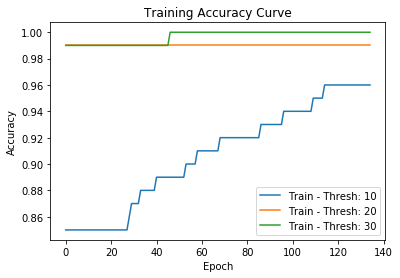

[EPOCH 136] loss: 0.000221  time: 0.432
[EPOCH 137] loss: 0.000220  time: 0.418
[EPOCH 138] loss: 0.000218  time: 0.453
[EPOCH 139] loss: 0.000216  time: 0.420
[EPOCH 140] loss: 0.000215  time: 0.428


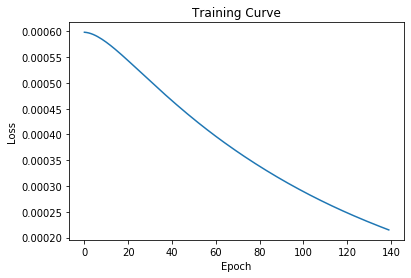

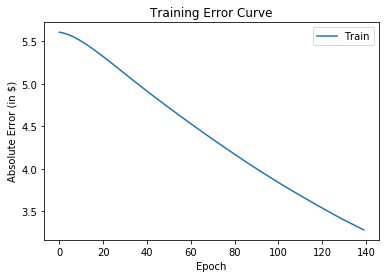

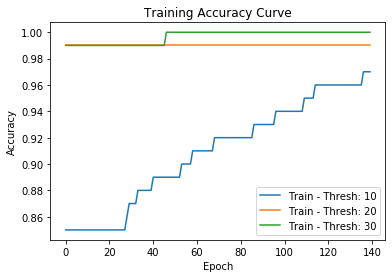

[EPOCH 141] loss: 0.000213  time: 0.400
[EPOCH 142] loss: 0.000212  time: 0.416
[EPOCH 143] loss: 0.000210  time: 0.413
[EPOCH 144] loss: 0.000208  time: 0.409
[EPOCH 145] loss: 0.000207  time: 0.419


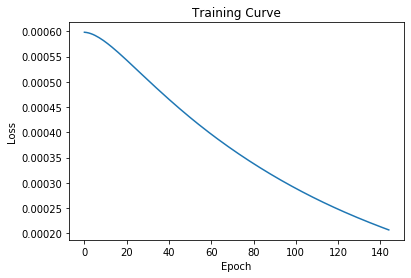

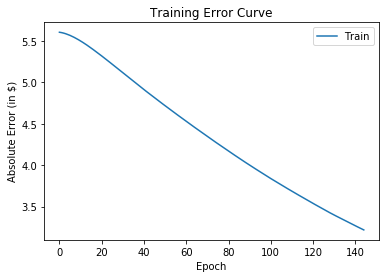

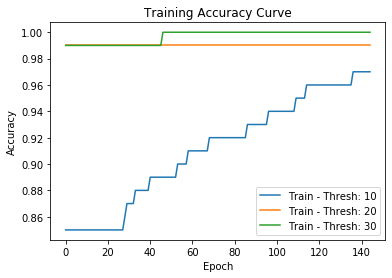

[EPOCH 146] loss: 0.000205  time: 0.411
[EPOCH 147] loss: 0.000204  time: 0.411
[EPOCH 148] loss: 0.000202  time: 0.421
[EPOCH 149] loss: 0.000201  time: 0.419
[EPOCH 150] loss: 0.000199  time: 0.431


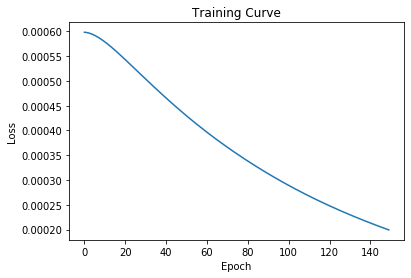

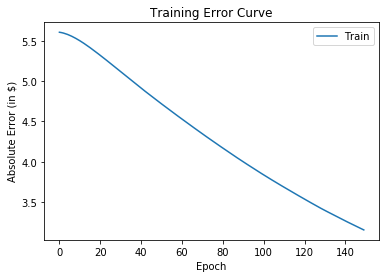

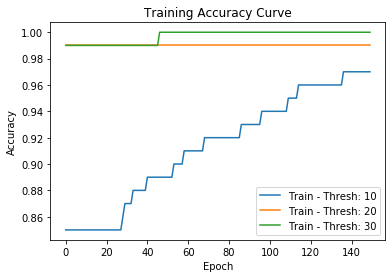

[EPOCH 151] loss: 0.000198  time: 0.415
[EPOCH 152] loss: 0.000196  time: 0.411
[EPOCH 153] loss: 0.000195  time: 0.489
[EPOCH 154] loss: 0.000193  time: 0.566
[EPOCH 155] loss: 0.000192  time: 0.492


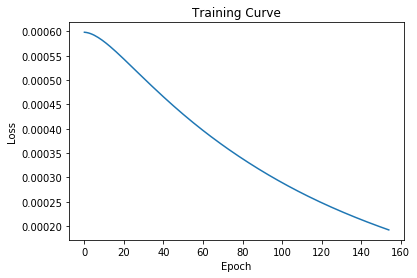

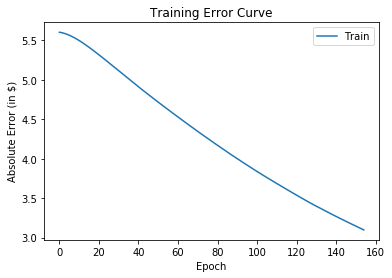

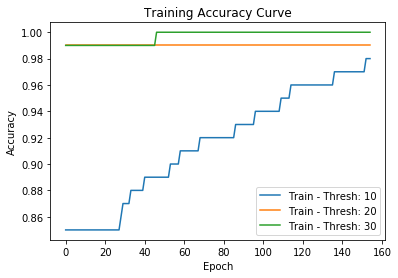

[EPOCH 156] loss: 0.000191  time: 0.415
[EPOCH 157] loss: 0.000189  time: 0.412
[EPOCH 158] loss: 0.000188  time: 0.416
[EPOCH 159] loss: 0.000186  time: 0.417
[EPOCH 160] loss: 0.000185  time: 0.416


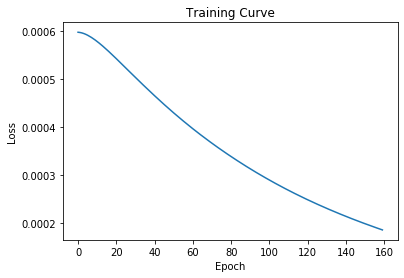

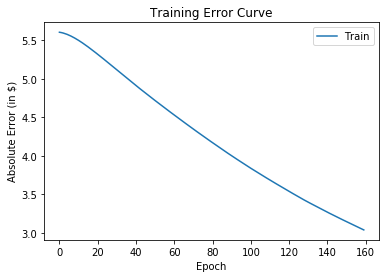

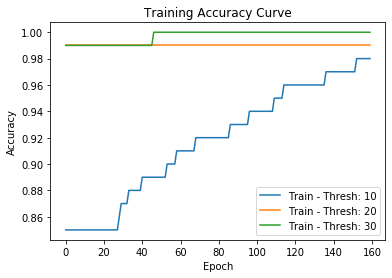

[EPOCH 161] loss: 0.000184  time: 0.413
[EPOCH 162] loss: 0.000182  time: 0.419
[EPOCH 163] loss: 0.000181  time: 0.407
[EPOCH 164] loss: 0.000180  time: 0.418
[EPOCH 165] loss: 0.000178  time: 0.402


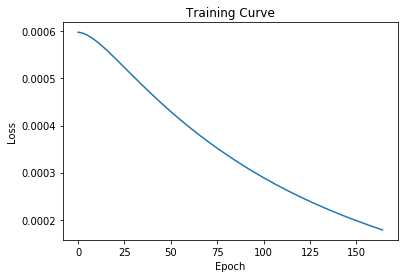

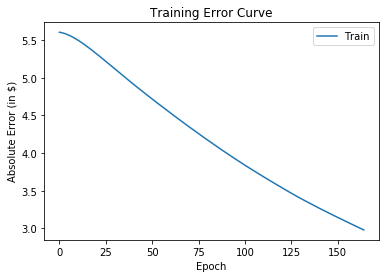

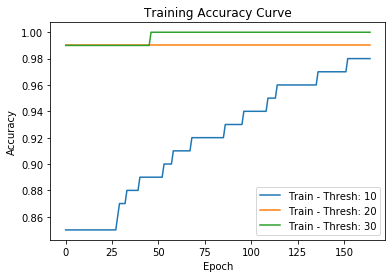

[EPOCH 166] loss: 0.000177  time: 0.419
[EPOCH 167] loss: 0.000176  time: 0.411
[EPOCH 168] loss: 0.000174  time: 0.421
[EPOCH 169] loss: 0.000173  time: 0.414
[EPOCH 170] loss: 0.000172  time: 0.406


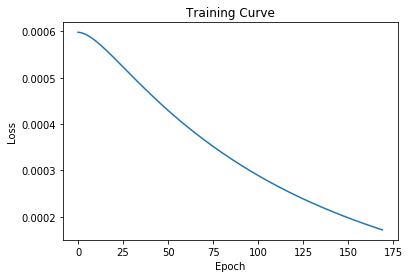

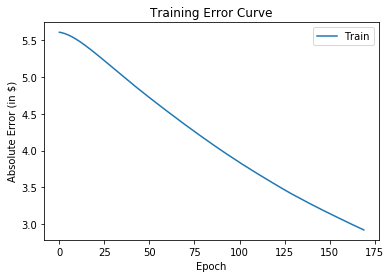

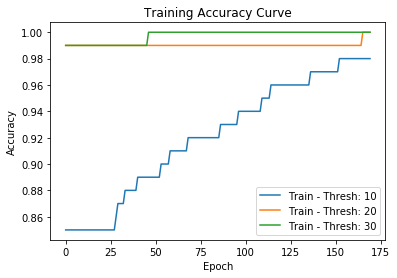

[EPOCH 171] loss: 0.000170  time: 0.438
[EPOCH 172] loss: 0.000169  time: 0.426
[EPOCH 173] loss: 0.000168  time: 0.406
[EPOCH 174] loss: 0.000167  time: 0.413
[EPOCH 175] loss: 0.000165  time: 0.413


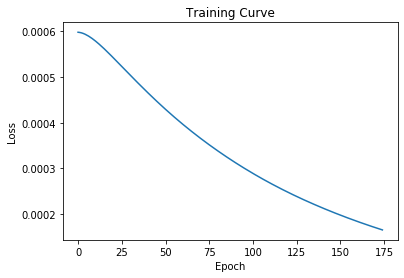

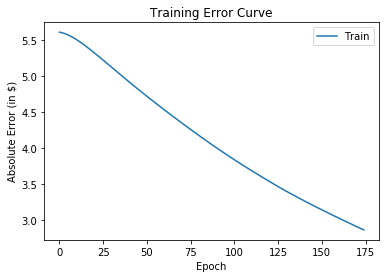

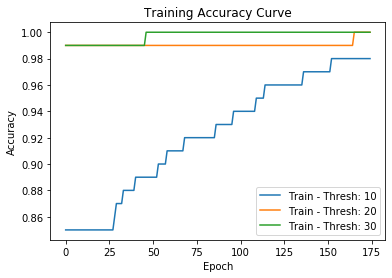

[EPOCH 176] loss: 0.000164  time: 0.412
[EPOCH 177] loss: 0.000163  time: 0.403
[EPOCH 178] loss: 0.000162  time: 0.425
[EPOCH 179] loss: 0.000161  time: 0.409
[EPOCH 180] loss: 0.000159  time: 0.423


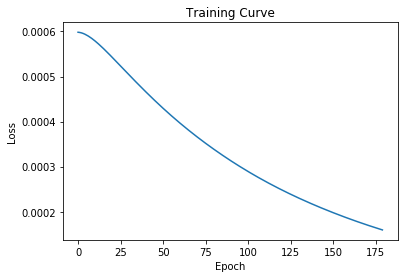

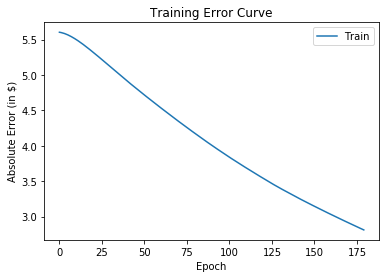

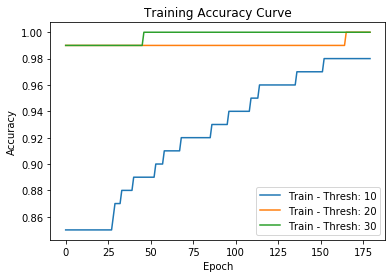

[EPOCH 181] loss: 0.000158  time: 0.411
[EPOCH 182] loss: 0.000157  time: 0.408
[EPOCH 183] loss: 0.000156  time: 0.411
[EPOCH 184] loss: 0.000155  time: 0.424
[EPOCH 185] loss: 0.000154  time: 0.408


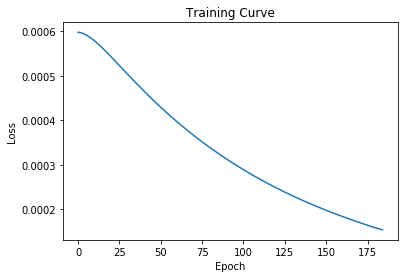

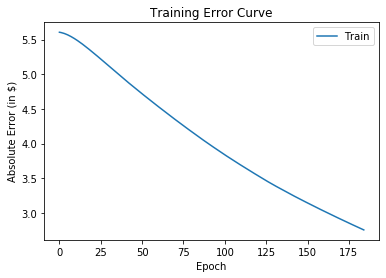

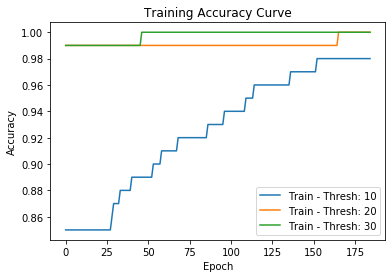

[EPOCH 186] loss: 0.000153  time: 0.413
[EPOCH 187] loss: 0.000151  time: 0.406
[EPOCH 188] loss: 0.000150  time: 0.421
[EPOCH 189] loss: 0.000149  time: 0.423
[EPOCH 190] loss: 0.000148  time: 0.419


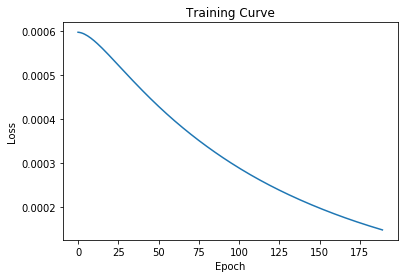

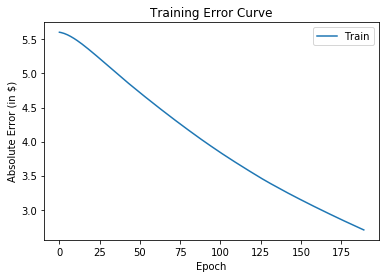

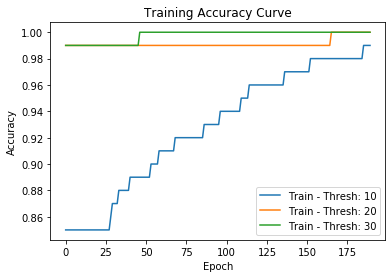

[EPOCH 191] loss: 0.000147  time: 0.415
[EPOCH 192] loss: 0.000146  time: 0.426
[EPOCH 193] loss: 0.000145  time: 0.417
[EPOCH 194] loss: 0.000144  time: 0.412
[EPOCH 195] loss: 0.000143  time: 0.407


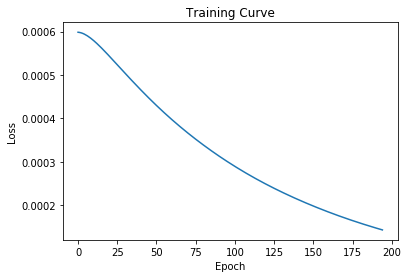

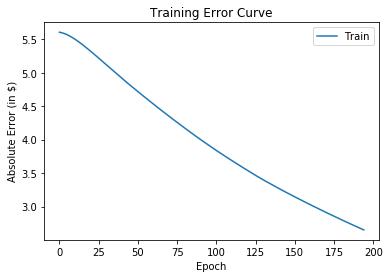

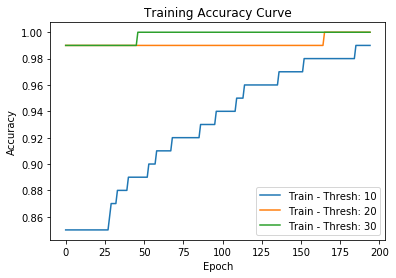

[EPOCH 196] loss: 0.000142  time: 0.428
[EPOCH 197] loss: 0.000141  time: 0.411
[EPOCH 198] loss: 0.000140  time: 0.412
[EPOCH 199] loss: 0.000139  time: 0.405
[EPOCH 200] loss: 0.000138  time: 0.425


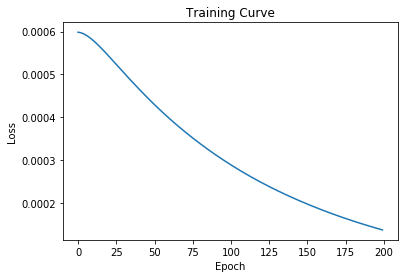

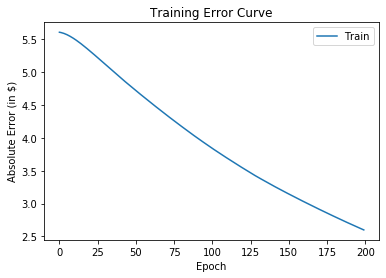

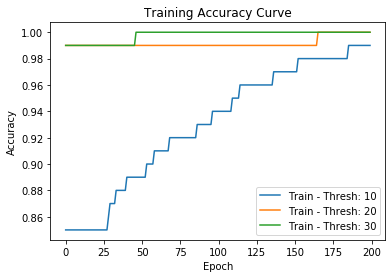

Training Completed...
[FINAL] loss: 0.000138  time: 100.840


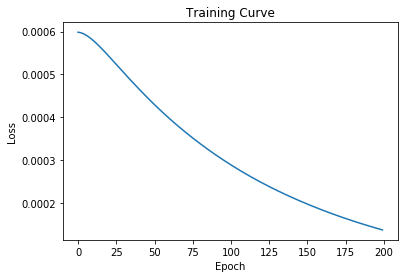

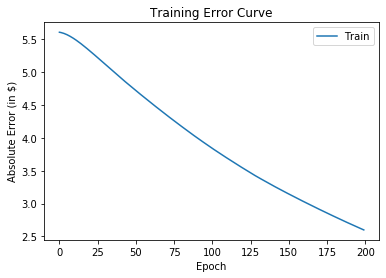

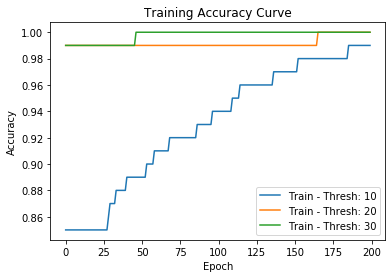

In [41]:
train(net, train_loader, val_loader, [minimum, maximum])

In [ ]:

(35.0024061050415, 0.178, 38.479926016671314, 0.16623376623376623)

(35.0024061050415, 0.345, 38.479926016671314, 0.3425974025974026)

(35.0024061050415, 0.538, 38.479926016671314, 0.5109090909090909)

In [54]:
accum = 0
accum1 = 0
for i in range(100):
    error = net(train_ds[i]["sample"]).item() - train_ds[i]["label"].item()
    accum += error
    accum1 += abs(error)
    print(net(train_ds[i]["sample"]).item(), train_ds[i]["label"].item(), error)
print("Error:", accum/100)

print("Abs Error:", accum1/100*(bounds[1]-bounds[0]))

0.4214916527271271 0.21405750513076782 0.20743414759635925
0.5276427268981934 0.3258785903453827 0.20176413655281067
0.2150266170501709 0.1405750811100006 0.07445153594017029
0.23273341357707977 0.03194888308644295 0.20078453049063683
0.09710259735584259 0.23642171919345856 -0.13931912183761597
0.41814690828323364 0.36421725153923035 0.053929656744003296
0.31207364797592163 0.2044728398323059 0.10760080814361572
0.1313839703798294 0.2651757299900055 -0.1337917596101761
0.08688503503799438 0.01277955248951912 0.07410548254847527
0.05793289840221405 0.028753994032740593 0.029178904369473457
0.31027013063430786 0.36421725153923035 -0.053947120904922485
0.3767816424369812 0.2843450605869293 0.09243658185005188
0.2956864833831787 0.2747603952884674 0.020926088094711304
0.20870961248874664 0.2044728398323059 0.004236772656440735
0.28128132224082947 0.1405750811100006 0.14070624113082886
0.2540990710258484 0.23642171919345856 0.01767735183238983
0.12372308224439621 0.04472843557596207 0.07899

In [ ]:
for i, data in enumerate(train_loader):
    print(len(data["label"]))
    break

In [ ]:
train_ds[4]["label"].item()


In [16]:
a = [3, 6, 9]
a = [i/3 for i in a]

In [17]:
a

[1.0, 2.0, 3.0]

In [26]:
[[], []]

[[], []]

4